<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

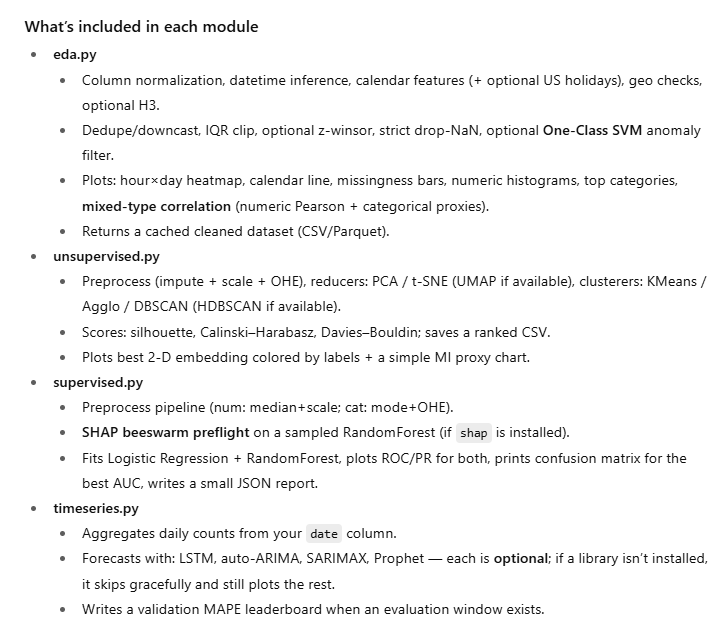

In [69]:
from eda import run_eda
from unsupervised import run_unsupervised
from supervised import run_supervised
from timeseries import run_timeseries

# EDA

In [70]:
# --- Date parsing helpers (LAPD) ----------------------------------------------
import re
from datetime import datetime

DATE_CANDIDATES = [
    "DATE OCC", "Date OCC", "date_occ", "Date Occurred", "Date Occured",
    "DATE RPTD", "Date Rptd", "date_rptd",
    "date_only", "Date", "DATE", "date"
]
TIME_CANDIDATES = ["TIME OCC", "Time OCC", "time_occ"]

def _parse_time_occ(s):
    """LAPD TIME OCC is often integer like 30, 930, 2359. Return (hour, minute) or (0,0) on fail."""
    try:
        if pd.isna(s): return 0, 0
        s = str(int(s)).zfill(4)  # "30" -> "0030", "930" -> "0930", "2359" -> "2359"
        hh = int(s[:2]); mm = int(s[2:])
        if 0 <= hh <= 23 and 0 <= mm <= 59:
            return hh, mm
        return 0, 0
    except Exception:
        return 0, 0

def _parse_any_date(series):
    """Try multiple common formats and pandas fallback; return pd.Series[datetime64[ns]] with NaT on fail."""
    # Fast path: let pandas try
    s = pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
    # If that did poorly (<80% valid), try manual formats
    valid_ratio = s.notna().mean()
    if valid_ratio >= 0.8:
        return s

    # manual attempts
    fmts = [
        "%m/%d/%Y %I:%M:%S %p",  # 12h with AM/PM
        "%m/%d/%Y %H:%M:%S",
        "%m/%d/%Y",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%d",
        "%m/%d/%y",
        "%d/%m/%Y",
    ]
    best = s.copy()
    for fmt in fmts:
        try:
            t = pd.to_datetime(series, format=fmt, errors="coerce")
            if t.notna().mean() > best.notna().mean():
                best = t
        except Exception:
            pass
    return best

def choose_best_date_column(df: pd.DataFrame) -> pd.Series:
    """Return a pd.Series[datetime64[ns]] named 'date_dt' built from DATE OCC + TIME OCC when available."""
    df = df.copy()
    # Prefer DATE OCC (+ TIME OCC)
    date_col = next((c for c in DATE_CANDIDATES if c in df.columns), None)
    time_col = next((c for c in TIME_CANDIDATES if c in df.columns), None)

    if date_col is not None:
        d = _parse_any_date(df[date_col])
        if time_col is not None:
            hhmm = df[time_col].apply(_parse_time_occ)
            hh = hhmm.apply(lambda t: t[0])
            mm = hhmm.apply(lambda t: t[1])
            # combine date + time safely
            d = d.dt.floor("D") + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")
        # if good enough, return
        if d.notna().any():
            d.name = "date_dt"
            return d

    # Fallback: try any column that parses well
    for c in df.columns:
        try:
            t = _parse_any_date(df[c])
            if t.notna().mean() > 0.8:
                t.name = "date_dt"
                return t
        except Exception:
            continue

    raise ValueError("Could not parse a valid date column from the raw data.")
def choose_best_date_column(df: pd.DataFrame) -> pd.Series:
    """
    Standardize LAPD dates into a single datetime column.
    Returns a pandas Series of datetime64[ns].
    """
    candidates = [
        "DATE OCC", "Date OCC", "date_occ", "date_occurred",
        "DATE", "Date", "date", "date_only",
        "Date Rptd", "DATE RPTD", "date_rptd"
    ]
    for col in candidates:
        if col in df.columns:
            s = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
            if s.notna().mean() > 0.5:  # at least half parsable
                return s

    # fallback: first column with >80% parse success
    for col in df.columns:
        s = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
        if s.notna().mean() > 0.8:
            return s

    raise ValueError("No suitable date column found")



In [71]:
# === LAPD EDA-only runner on ~5k stratified sample (Colab-friendly) ==========
# Place this in one Colab cell and run it.
# Requires ONLY: eda.py (exposes: run_eda)
#
# What it does:
# 1) Resolve RAW_PATH (CSV or ZIP) → CSV
# 2) Read CSV once, pick a stratify column (Crm Cd / Crm Cd Desc / AREA NAME)
#    and create an ~5k stratified sample (fallback to random if needed)
# 3) Save sample to /content/Crime_Data_stratified_5k.csv
# 4) Call run_eda() ONLY on the sample and save outputs under /content
#
# Tweakables:
SAMPLE_SIZE   = 5000
RAW_PATH      = "/content/Crime_Data_from_2020_to_Present.csv.zip"
OUT_DIR       = "/content"
EDA_FIGS      = f"{OUT_DIR}/figs_eda_5k"
SAMPLE_CSV    = f"{OUT_DIR}/Crime_Data_stratified_5k.csv"
CLEAN_PATH    = f"{OUT_DIR}/lapd_clean_5k.parquet"
RANDOM_STATE  = 42

# EDA config (safe/speedy defaults)
EDA_CONFIG = {
    "add_h3": False,
    "svms_outlier_clip": False,
    "preview_rows": 10000
}

# -----------------------------------------------------------------------------
import os, sys, zipfile, pandas as pd, numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Make sure we can import local eda.py
if "" not in sys.path:
    sys.path.insert(0, "")
try:
    from eda import run_eda   # <-- date parsing/standardization will happen inside run_eda
except Exception as e:
    raise ImportError("Couldn't import run_eda from eda.py. Make sure eda.py is in the working directory.") from e

os.makedirs(EDA_FIGS, exist_ok=True)

def _resolve_raw_path(p: str, out_dir: str) -> str:
    """Accept CSV or ZIP. If ZIP, extract first CSV to out_dir and return its path."""
    if not os.path.exists(p):
        raise FileNotFoundError(f"Raw file not found: {p}")
    if p.lower().endswith(".zip") and zipfile.is_zipfile(p):
        with zipfile.ZipFile(p) as zf:
            csv_members = [m for m in zf.namelist() if m.lower().endswith(".csv")]
            if not csv_members:
                raise ValueError("ZIP found but contains no CSV.")
            target = csv_members[0]
            zf.extract(target, out_dir)
            extracted_csv = os.path.join(out_dir, os.path.basename(target))
            print(f"[EDA Runner] Extracted CSV → {extracted_csv}")
            return extracted_csv
    if p.lower().endswith(".zip") and not zipfile.is_zipfile(p):
        maybe_csv = p[:-4]
        if os.path.exists(maybe_csv):
            print(f"[EDA Runner] {p} is not a zip; using CSV next to it → {maybe_csv}")
            return maybe_csv
        raise ValueError(f"{p} is not a valid ZIP and {maybe_csv} not found.")
    return p  # assume CSV

def _pick_stratify_col(cols):
    """Pick a good stratification column by preference order."""
    candidates = [
        "Crm Cd", "Crm Cd Desc", "Crime Code", "Crime Code Description",
        "AREA NAME", "Area Name", "AREA", "Area"
    ]
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

def _make_stratified_sample(df: pd.DataFrame, target_col: str, n: int, random_state: int) -> pd.DataFrame:
    """Use StratifiedShuffleSplit to select about n rows, preserving class proportions."""
    if n >= len(df):
        print(f"[EDA Runner] Requested sample size ({n}) >= dataset size ({len(df)}); using full data.")
        return df.copy()

    # Avoid NaNs in y
    y = df[target_col].astype(str).fillna("__NA__")
    frac = n / len(df)
    frac = max(min(frac, 0.9), 1e-6)  # keep in (0,1)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    for _, test_idx in sss.split(np.zeros(len(df)), y):  # indices as X, y as labels
        sample = df.iloc[test_idx].copy()
        break

    # Trim if slightly over n
    if len(sample) > n:
        sample = sample.sample(n=n, random_state=random_state)
    print(f"[EDA Runner] Stratified sample using '{target_col}': {len(sample):,} rows.")
    return sample

def _make_random_sample(df: pd.DataFrame, n: int, random_state: int) -> pd.DataFrame:
    if n >= len(df):
        return df.copy()
    sample = df.sample(n=n, random_state=random_state)
    print(f"[EDA Runner] Random sample (fallback): {len(sample):,} rows.")
    return sample




In [72]:
# 2) Read CSV once, CLEAN it, then pick stratify col, build ~5k sample
print("[EDA Runner] Reading full CSV once to derive ~5k stratified sample...")
df_full = pd.read_csv(raw_csv, low_memory=False)
print(f"[EDA Runner] Full shape (raw): {df_full.shape}")

# --- Light clean: treat empty strings as NaN ---
df_full = df_full.replace(r'^\s*$', np.nan, regex=True)
df_full = df_full.dropna(subset=needed_cols).reset_index(drop=True)

# Helper: resolve a column name case-insensitively from a list of aliases
def resolve_col(df, aliases):
    wanted = {a.strip().lower() for a in aliases}
    for c in df.columns:
        if c.strip().lower() in wanted:
            return c
    return None

# Resolve columns we care about (don’t nuke the whole dataset)
victim_sex_col = resolve_col(df_full, [
    "Victim_sex", "Vict Sex", "Victim Sex",
    "Gender", "Sex", "vict_sex", "victimsex"
])
crime_code_col = resolve_col(df_full, [
    "Crime_Code", "Crm Cd", "Crm Cd Desc",
    "Crime Code", "Crime Code Description"
])
area_col = resolve_col(df_full, ["Area", "AREA", "Area Name", "AREA NAME"])

# Fail early with a clear message if victim sex is missing
if not victim_sex_col:
    raise ValueError(
        "Could not find a victim sex column. "
        "Tried: Victim_sex / Vict Sex / Victim Sex / Gender / Sex / vict_sex / victimsex."
    )

# Only drop rows that are missing the columns you need downstream
needed_cols = [victim_sex_col] + [c for c in [crime_code_col, area_col] if c]
print(f"[EDA Runner] Shape after dropping NA in needed cols {needed_cols}: {df_full.shape}")
print("[EDA Runner] Head (cleaned minimal):")
print(df_full.head(10))

# 3) tidy gender values a bit (so stratification is well-defined)
STRATIFY_BY = victim_sex_col
df_full[STRATIFY_BY] = (
    df_full[STRATIFY_BY]
      .astype(str)
      .str.strip()
      .str.upper()
      .replace({
          "U": "UNKNOWN",
          "X": "UNKNOWN",
          "-": "UNKNOWN",
          "N": "UNKNOWN",
          "": "UNKNOWN",
      })
)

# Optional: keep only M/F so the strata aren’t degenerate; comment out if you want UNKNOWN included
keep_vals = {"M", "F"}
df_full = df_full[df_full[STRATIFY_BY].isin(keep_vals)].copy()
print(f"[EDA Runner] After gender tidy/filter ({STRATIFY_BY} in {sorted(keep_vals)}): {df_full.shape}")
print(df_full[STRATIFY_BY].value_counts(dropna=False))

# 4) build ~5k stratified sample by gender
try:
    df_sample = _make_stratified_sample(df_full, STRATIFY_BY, SAMPLE_SIZE, RANDOM_STATE)
except Exception as e:
    print(f"[EDA Runner] Stratified sampling on '{STRATIFY_BY}' failed → fallback to random. Reason: {e}")
    df_sample = _make_random_sample(df_full, SAMPLE_SIZE, RANDOM_STATE)

# 5) Standardize a date column on the sample (extend candidates to cover your headers)
def choose_best_date_column(df: pd.DataFrame) -> pd.Series:
    candidates = [
        # common LAPD variants seen in your printouts
        "Date_occured", "Date_occurred", "Date Occured", "Date Occurred",
        "Date_Reported", "Date Reported",
        "DATE OCC", "Date OCC", "date_occ", "date_occurred",
        "DATE RPTD", "Date Rptd", "date_rptd",
        "date_only", "Date", "DATE", "date",
    ]
    # try candidates first
    for col in candidates:
        if col in df.columns:
            s = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
            if s.notna().mean() > 0.5:
                s.name = "date_dt"
                return s
    # fallback: any column that parses well
    best_col, best = None, None
    for col in df.columns:
        s = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
        if best is None or s.notna().mean() > best.notna().mean():
            best, best_col = s, col
    if best is not None and best.notna().any():
        best.name = "date_dt"
        return best
    raise ValueError("No suitable date column found")

df_sample["date_dt"] = choose_best_date_column(df_sample)
df_sample["date"] = df_sample["date_dt"].dt.date

# Free memory from full DF
"""del df_full"""


[EDA Runner] Reading full CSV once to derive ~5k stratified sample...
[EDA Runner] Full shape (raw): (974477, 15)
[EDA Runner] Shape after dropping NA in needed cols ['Victim_sex', 'Crime_Code', 'Area']: (838474, 15)
[EDA Runner] Head (cleaned minimal):
       DR_NO           Date_Reported            Date_occured  Time_occured  \
0  190326475           03/01/20 0:00           03/01/20 0:00          2130   
1  200106753           02/09/20 0:00           02/08/20 0:00          1800   
2  200320258           11/11/20 0:00           11/04/20 0:00          1700   
3  200907217           05/10/23 0:00           03/10/20 0:00          2037   
4  220614831  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM          1200   
5  231808869                04/04/23           12/01/20 0:00          2300   
6  230110144           04/04/23 0:00           07/03/20 0:00           900   
7  220314085  07/22/2022 12:00:00 AM           05/12/20 0:00          1110   
8  231309864  04/28/2023 12:00:00 AM        

'del df_full'

In [73]:
import pandas as pd
# Use the sampled dataframe - just making sure
df = df_sample
print(df[["date_dt","date"]].head())
print("date_dt dtype:", df["date_dt"].dtype)
print("date range:", df["date_dt"].min(), "→", df["date_dt"].max())
print("null share:", df["date_dt"].isna().mean())

          date_dt        date
508963 2022-01-02  2022-01-02
780758 2024-04-30  2024-04-30
509082 2022-01-07  2022-01-07
389192 2022-05-30  2022-05-30
651148 2023-02-14  2023-02-14
date_dt dtype: datetime64[ns]
date range: 2020-01-01 00:00:00 → 2024-08-29 00:00:00
null share: 0.0


🖼️ saved: /content/figs_eda_5k/Numeric-Distributions-—-cleaned.png


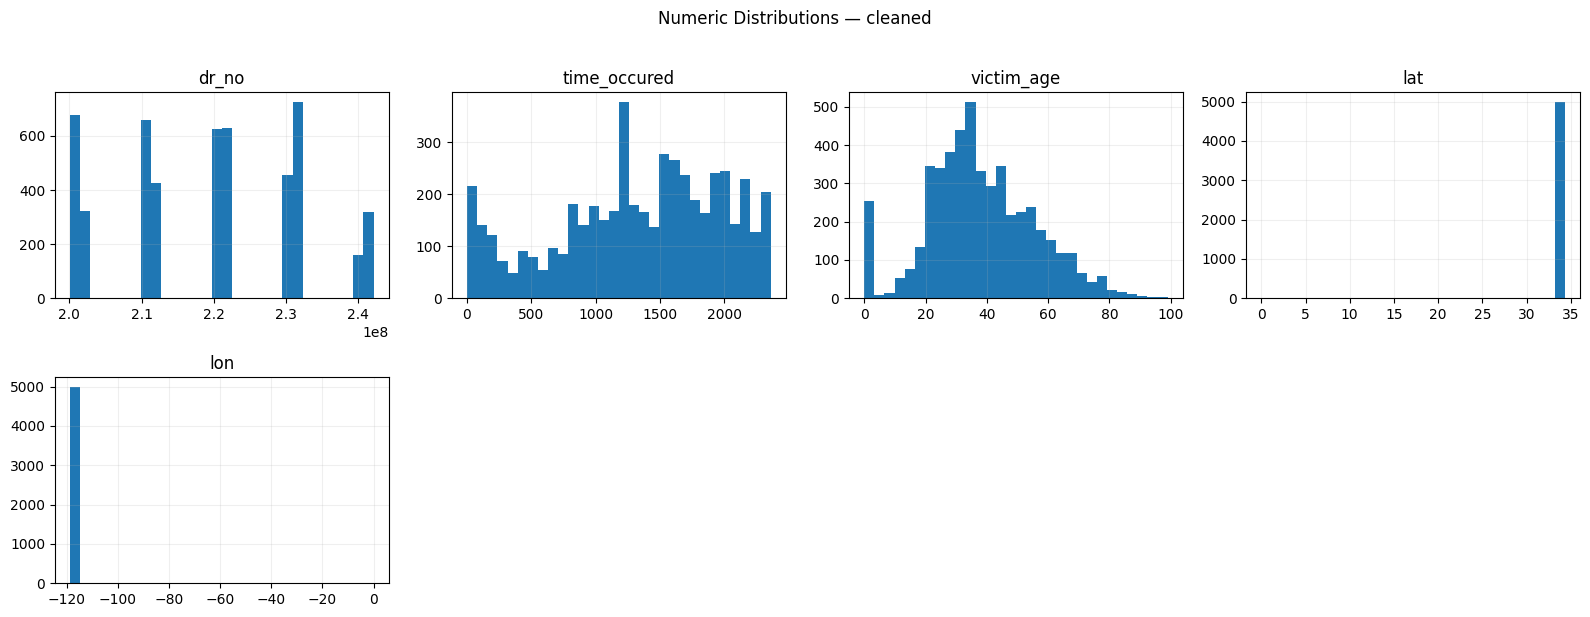

🖼️ saved: /content/figs_eda_5k/Top-categories-—-victim_sex.png


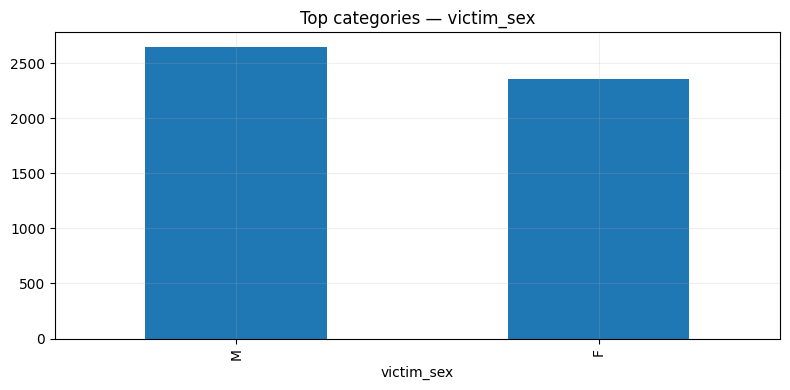

🖼️ saved: /content/figs_eda_5k/Top-categories-—-victim_descent.png


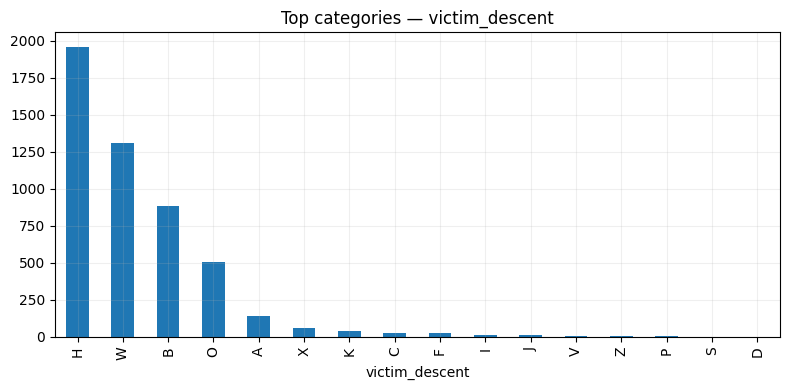

🖼️ saved: /content/figs_eda_5k/Top-categories-—-status.png


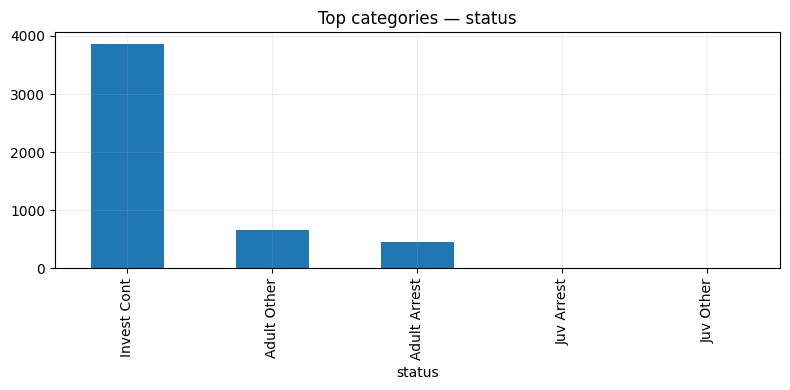

🖼️ saved: /content/figs_eda_5k/Mixed-correlations-(num-+-cat).png


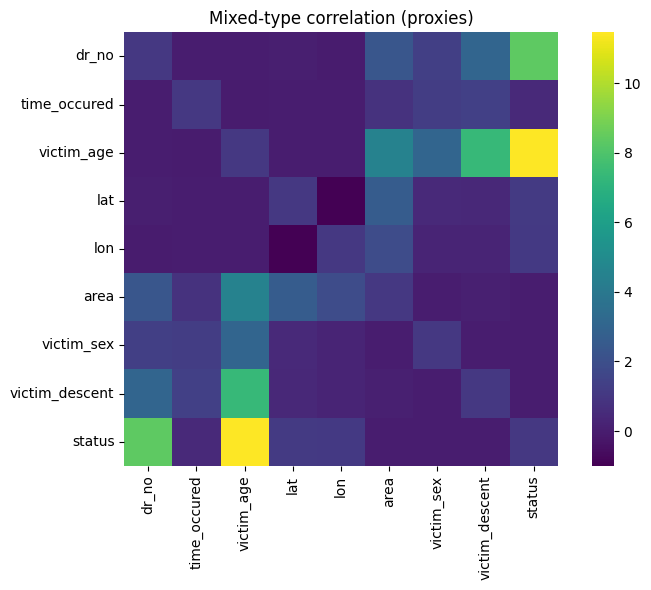

In [74]:
# Put this after you create df_sample (and before calling run_eda if you want)
from eda import eda_top_categories, eda_numeric_histograms, eda_corr_mixed, normalize_columns, _plot_and_save
import os

os.makedirs(EDA_FIGS, exist_ok=True)

# Use the sample we just built
df_plot = df_sample.copy()

# (optional but useful) normalize col names to match eda helpers’ expectations
df_plot = normalize_columns(df_plot)

# 1) Numeric distributions (all numeric cols)
eda_numeric_histograms(df_plot, title="Numeric Distributions — cleaned")
_plt_title = "Numeric Distributions — cleaned"
_plot_and_save(_plt_title, EDA_FIGS)

# 2) Categorical bars for every column with <=20 unique values (non‑numeric)
num_cols = set(df_plot.select_dtypes(include=[np.number]).columns)
cat_cols = [c for c in df_plot.columns
            if c not in num_cols and df_plot[c].nunique(dropna=False) <= 20]

for c in cat_cols:
    eda_top_categories(df_plot, c, top_n=20)
    _plot_and_save(f"Top categories — {c}", EDA_FIGS)

# 3) Mixed-type correlation heatmap (numeric ↔ categorical proxies)
eda_corr_mixed(df_plot)  # uses <=30-unique for cats internally
_plot_and_save("Mixed correlations (num + cat)", EDA_FIGS)


#Supervised

In [ ]:
# === Supervised (clean, fast, SHAP-free) on the EDA cleaned ~5k sample ========
# Uses /content/lapd_clean_5k.parquet (or CSV fallback) produced by your EDA cell.
# Outputs under /content/figs_sup_5k

import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

warnings.filterwarnings("ignore")

# --------------------------------- CONFIG -------------------------------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"  # change if you saved CSV instead
OUT_DIR      = "/content/figs_sup_5k"
RANDOM_STATE = 42
TEST_SIZE    = 0.25

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------- load cleaned sample ---------------------------------
def _load_clean_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_clean_df(CLEAN_PATH)
print(f"[Supervised] Loaded cleaned sample: {df.shape}")

# -------------------- pick a usable target automatically -----------------------
# Rules:
# - candidate if: non-numeric ID-like columns excluded, unique classes between 2 and 10
# - balance: minority class >= 5% (for binary) or no class < 3% (for multiclass)
# - prefer binary; otherwise smallest-classes multiclass
EXCLUDE_REGEX = (
    "date|time|lat|lon|h3|x_|y_|geohash|id$|^id|addr|location|coord|month|day|hour"
)
exclude_cols = [
    c for c in df.columns
    if pd.Series([c]).str.contains(EXCLUDE_REGEX, case=False, regex=True).iloc[0]
]

# Drop fully constant columns
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
usable_cols = [c for c in df.columns if c not in exclude_cols and c not in constant_cols]

def _good_target(col: pd.Series):
    vc = col.value_counts(dropna=False)
    # cannot be numeric continuous with too many uniques
    if col.dtype.kind in "iuf" and vc.size > 15:
        return False
    # must have at least 2 classes
    if vc.size < 2:
        return False
    # max classes 10 to keep things light
    if vc.size > 10:
        return False
    # balance checks
    n = len(col)
    freqs = vc.values / n
    if vc.size == 2:
        return freqs.min() >= 0.05
    else:
        return (freqs >= 0.03).all()

# strong preferred names if present
PREFERRED = [
    "Part 1-2", "Part_1_2", "Part1_2", "Crm Cd", "Crm Cd Desc",
    "Crime Code", "Crime Code Description", "AREA NAME", "ARREST MADE",
    "Status", "Status Desc"
]
pref = [c for c in PREFERRED if c in usable_cols and _good_target(df[c])]

candidates = pref or [c for c in usable_cols if _good_target(df[c])]
if not candidates:
    # last resort: discretize a numeric column into bins
    num_cols = [c for c in usable_cols if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise RuntimeError("No suitable target candidate found and no numeric columns to discretize.")
    tgt = num_cols[0]
    df["__TARGET__"] = pd.qcut(df[tgt], q=3, labels=["low","mid","high"])
    target_col = "__TARGET__"
else:
    # prefer binary candidates
    bin_cands = [c for c in candidates if df[c].nunique(dropna=False) == 2]
    target_col = (bin_cands or candidates)[0]

print(f"[Supervised] Target selected: {target_col} (classes={df[target_col].nunique(dropna=False)})")

# ------------------------- build X / y and encode ------------------------------
y = df[target_col].astype("category")
X = df.drop(columns=[target_col]).copy()

# Remove columns that are now useless or leakage-like (IDs we missed)
X = X.drop(columns=[c for c in X.columns if c in exclude_cols or c in constant_cols], errors="ignore")

# Basic sanitization
for c in X.select_dtypes(include=["bool"]).columns:
    X[c] = X[c].astype(int)

# Keep only columns with at least 2 distinct non-null values
X = X[[c for c in X.columns if X[c].dropna().nunique() >= 2]]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ------------------------------ pick model -------------------------------------
is_binary = y.nunique() == 2
if is_binary:
    model = LogisticRegression(max_iter=200, n_jobs=None, class_weight="balanced", random_state=RANDOM_STATE)
else:
    model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

pipe = Pipeline([("pre", pre), ("clf", model)])

# ------------------------------ split & fit ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe.fit(X_train, y_train)

# ------------------------------ evaluate ---------------------------------------
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
with open(os.path.join(OUT_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("[Supervised] Classification report (micro summary):")
print(json.dumps({k: report[k] for k in report if k in ["accuracy","macro avg","weighted avg"]}, indent=2))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, aspect="auto")
plt.xticks(range(len(y.cat.categories)), y.cat.categories, rotation=45, ha="right")
plt.yticks(range(len(y.cat.categories)), y.cat.categories)
plt.title(f"Confusion Matrix — target: {target_col}")
plt.colorbar()
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=160)
plt.close()
print(f"[Supervised] Saved: {cm_path}")

# ROC (binary only)
if is_binary:
    try:
        # get positive class probabilities
        proba = pipe.predict_proba(X_test)[:, list(pipe.classes_).index(y.cat.categories[1])]
        auc = roc_auc_score((y_test == y.cat.categories[1]).astype(int), proba)
        fpr, tpr, _ = roc_curve((y_test == y.cat.categories[1]).astype(int), proba)
        fig = plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
        plt.legend()
        roc_path = os.path.join(OUT_DIR, "roc_curve.png")
        plt.tight_layout(); plt.savefig(roc_path, dpi=160); plt.close()
        print(f"[Supervised] Saved: {roc_path}")
    except Exception as e:
        print(f"[Supervised] ROC skipped: {e}")

# ----------------------- lightweight "feature importance" ----------------------
# For logistic regression, report top absolute coefficients (after OHE).
# For HGB, use feature_importances_ via permutation-like surrogate if absent.
def _feature_names(preprocessor, X_fit):
    pre = preprocessor
    names = []
    if hasattr(pre, "transformers_"):
        for name, trans, cols in pre.transformers_:
            if name == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    names.extend(list(trans.get_feature_names_out(cols)))
                except:
                    names.extend(list(cols))
            else:
                names.extend(list(cols))
    else:
        names = list(X_fit.columns)
    return names

feat_names = _feature_names(pipe.named_steps["pre"], X_train)

importance = None
clf = pipe.named_steps["clf"]
try:
    if is_binary and hasattr(clf, "coef_"):
        coefs = np.abs(clf.coef_[0])
        importance = pd.DataFrame({"feature": feat_names, "importance": coefs}).sort_values("importance", ascending=False)
    elif hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        importance = pd.DataFrame({"feature": feat_names, "importance": imps}).sort_values("importance", ascending=False)
except Exception as e:
    print(f"[Supervised] Importance extraction skipped: {e}")

if importance is not None:
    topk = importance.head(25)
    topk.to_csv(os.path.join(OUT_DIR, "feature_importance_top25.csv"), index=False)
    fig = plt.figure(figsize=(6, max(4, len(topk)*0.3)))
    plt.barh(topk["feature"][::-1], topk["importance"][::-1])
    plt.title("Top features")
    plt.tight_layout()
    imp_path = os.path.join(OUT_DIR, "feature_importance_top25.png")
    plt.savefig(imp_path, dpi=160); plt.close()
    print(f"[Supervised] Saved: {imp_path}")

print("\n=== Supervised (compact) DONE ===")
print(f"Figures & reports → {OUT_DIR}")


[Supervised] Loaded cleaned sample: (1651, 23)
[Supervised] Target selected: victim_sex (classes=3)
[Supervised] Classification report (micro summary):
{
  "accuracy": 0.6368038740920097,
  "macro avg": {
    "precision": 0.7297187854880164,
    "recall": 0.7285377650450068,
    "f1-score": 0.7285887039408167,
    "support": 413.0
  },
  "weighted avg": {
    "precision": 0.6359997238745608,
    "recall": 0.6368038740920097,
    "f1-score": 0.6356455373225486,
    "support": 413.0
  }
}
[Supervised] Saved: /content/figs_sup_5k/confusion_matrix.png

=== Supervised (compact) DONE ===
Figures & reports → /content/figs_sup_5k


In [ ]:
# === Supervised: robust multi-model compare + plots (handles XGB label needs) ==
import os, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

warnings.filterwarnings("ignore")

CLEAN_PATH = "/content/lapd_clean_5k.parquet"    # cleaned file from EDA step
OUT_DIR    = "/content/figs_sup_5k_models"
TARGET     = "victim_sex"                         # from your results
TEST_SIZE  = 0.25
RANDOM_SEED= 42

os.makedirs(OUT_DIR, exist_ok=True)

# --- load
if os.path.exists(CLEAN_PATH) and CLEAN_PATH.lower().endswith(".parquet"):
    df = pd.read_parquet(CLEAN_PATH)
else:
    alt = os.path.splitext(CLEAN_PATH)[0] + ".csv"
    df = pd.read_csv(alt, low_memory=False)

assert TARGET in df.columns, f"Target '{TARGET}' not found in dataframe."

y = df[TARGET].astype("category")
X = df.drop(columns=[TARGET]).copy()

# prune degenerate columns
const_cols = [c for c in X.columns if X[c].dropna().nunique() <= 1]
if const_cols:
    X = X.drop(columns=const_cols)

# bool -> int; keep only columns with ≥2 distinct values
for c in X.select_dtypes(include=["bool"]).columns:
    X[c] = X[c].astype(int)
X = X[[c for c in X.columns if X[c].dropna().nunique() >= 2]]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

# OneHotEncoder API compatibility: sklearn>=1.2 uses sparse_output
def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", _make_ohe(), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# split once → shared across models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# fit transform to arrays
pre.fit(X_train)
XT_train = pre.transform(X_train)
XT_test  = pre.transform(X_test)

# helper for feature names (for importances later if needed)
def _feature_names(preprocessor, X_fit):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            try:
                names.extend(list(trans.get_feature_names_out(cols)))
            except:
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names
feat_names = _feature_names(pre, X_train)

# --- models
models = {}
models["LogReg"] = LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=None, random_state=RANDOM_SEED)
models["RF"]     = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
models["HGB"]    = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

# optional XGB (label-encode y)
has_xgb = True
try:
    from xgboost import XGBClassifier
    models["XGB"] = XGBClassifier(
        eval_metric="mlogloss", use_label_encoder=False, random_state=RANDOM_SEED
    )
except Exception as _:
    has_xgb = False
    print("[Info] xgboost not available; skipping XGB.")

# Train/eval
metrics = []
cms = {}
reports = {}

# Prepare y for XGB (numeric)
le = LabelEncoder().fit(y_train)  # maps classes to [0..k-1]
y_train_num = le.transform(y_train)
y_test_num  = le.transform(y_test)

for name, clf in models.items():
    if name == "XGB":
        # XGB requires numeric labels
        clf.fit(XT_train, y_train_num)
        y_pred_num = clf.predict(XT_test)
        y_pred = le.inverse_transform(y_pred_num)
    else:
        clf.fit(XT_train, y_train)
        y_pred = clf.predict(XT_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    metrics.append({"model": name, "accuracy": acc, "macro_f1": f1m})

    cm  = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
    cms[name] = cm
    reports[name] = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

# Save tabular metrics
res_df = pd.DataFrame(metrics).sort_values("macro_f1", ascending=False)
res_df.to_csv(os.path.join(OUT_DIR, "model_comparison.csv"), index=False)
print(res_df)

# Plot bar chart
fig, ax = plt.subplots(figsize=(6,4))
res_df.set_index("model")[["accuracy","macro_f1"]].plot.bar(ax=ax)
plt.title(f"Model Comparison — {TARGET}")
plt.ylabel("Score")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "model_comparison.png"), dpi=150)
plt.close()
print(f"[Saved] {OUT_DIR}/model_comparison.png")

# Save individual confusion matrices
labels = list(y.cat.categories)
for name, cm in cms.items():
    fig = plt.figure(figsize=(4.2,3.6))
    plt.imshow(cm, aspect="auto")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(f"Confusion — {name}")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"cm_{name}.png")
    plt.savefig(path, dpi=150); plt.close()
    print(f"[Saved] {path}")

# Side-by-side confusion matrices for top-2 models (by macro_f1)
top2 = list(res_df["model"].head(2))
if len(top2) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.8), sharex=True, sharey=True)
    for i, name in enumerate(top2):
        ax = axes[i]
        cm = cms[name]
        im = ax.imshow(cm, aspect="auto")
        ax.set_title(f"{name}")
        ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    fig.suptitle(f"Confusion matrices (Top-2 by macro F1) — {TARGET}")
    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    plt.tight_layout(rect=[0,0,1,0.95])
    path = os.path.join(OUT_DIR, "cm_top2_side_by_side.png")
    plt.savefig(path, dpi=150); plt.close()
    print(f"[Saved] {path}")

# Save detailed reports
with open(os.path.join(OUT_DIR, "classification_reports.json"), "w") as f:
    json.dump(reports, f, indent=2)

print("\n=== Supervised model comparison complete ===")
print(f"Outputs in: {OUT_DIR}")


    model  accuracy  macro_f1
1      RF  0.651332  0.733391
2     HGB  0.627119  0.727652
3     XGB  0.631961  0.724019
0  LogReg  0.237288  0.200611
[Saved] /content/figs_sup_5k_models/model_comparison.png
[Saved] /content/figs_sup_5k_models/cm_LogReg.png
[Saved] /content/figs_sup_5k_models/cm_RF.png
[Saved] /content/figs_sup_5k_models/cm_HGB.png
[Saved] /content/figs_sup_5k_models/cm_XGB.png
[Saved] /content/figs_sup_5k_models/cm_top2_side_by_side.png

=== Supervised model comparison complete ===
Outputs in: /content/figs_sup_5k_models


#Unsupervised

# attempts

In [ ]:
# === Unsupervised runner (fast, Colab-friendly, ~5k cleaned sample) ===========
# Inputs:  /content/lapd_clean_5k.parquet  (created by your EDA cell)
# Outputs: /content/figs_unsup_5k/*

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

warnings.filterwarnings("ignore")

# ------------------------------- CONFIG ---------------------------------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"   # fallback to CSV if missing
OUT_DIR      = "/content/figs_unsup_5k"
RANDOM_STATE = 42

# Feature building
MAX_CAT_CARD = 30      # only one-hot categoricals with ≤ 30 categories
SVD_COMPONENTS = 50    # compact space for clustering & TSNE/UMAP
TSNE_PERPLEX  = 30

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------- LOAD -----------------------------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UNSUP] Loaded cleaned sample: {df.shape}")

# -------------------------- BUILD FEATURE MATRIX ------------------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop super-constant cols (avoid zero-variance)
constant_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
df = df.drop(columns=constant_cols)

# Choose features: numeric + low-cardinality categoricals
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols_all = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
# keep only cats with <= MAX_CAT_CARD unique non-null
cat_cols = [c for c in cat_cols_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid obvious labels/leakage-like columns if they exist
DROP_LIKE = {"victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
             "Crime Code Description","ARREST MADE","Status","Status Desc"}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]

Xdf = df[use_cols].copy()
# sanitize: bool->int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UNSUP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ----------------------- DIMENSIONALITY REDUCTION -----------------------------
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1)), random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_sparse)
print(f"[UNSUP] SVD space: {X_svd.shape}, explained_var_sum≈{svd.explained_variance_ratio_.sum():.2f}")

# PCA-like 2D via SVD→2
svd2 = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
X_2d_svd = svd2.fit_transform(X_sparse)

# UMAP (optional)
has_umap = True
try:
    import umap
    um = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=RANDOM_STATE)
    X_2d_umap = um.fit_transform(X_sparse)
except Exception as _:
    has_umap = False
    X_2d_umap = None
    print("[UNSUP] UMAP unavailable; skipping.")

# t-SNE on dense SVD (fix: avoid PCA init on sparse)
from sklearn.manifold import TSNE
tsne_in = X_svd  # already dense, 50-D
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEX, learning_rate="auto",
            init="random", random_state=RANDOM_STATE, n_iter=800, verbose=0)
X_2d_tsne = tsne.fit_transform(tsne_in)

# ----------------------------- CLUSTERING -------------------------------------
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
metrics = []
labels_dict = {}

# Evaluate helpers
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X, y):
    # handle weird cases (all same label or noise only)
    if len(set(y)) <= 1 or (len(set(y))==1 and list(set(y))[0]==-1):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try:
        sil = silhouette_score(X, y)
    except Exception:
        sil = np.nan
    try:
        ch  = calinski_harabasz_score(X, y)
    except Exception:
        ch = np.nan
    try:
        db  = davies_bouldin_score(X, y)
    except Exception:
        db = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len(set(y)) - (1 if -1 in set(y) else 0))

# Try KMeans (k=2..8) on 50-D SVD
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"KMeans","config":f"k={k}", **sc})
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# Agglomerative (Ward) on 50-D SVD for k in 2..6
best_ag = None
for k in range(2, 7):
    ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
    lab = ag.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"Agglomerative","config":f"k={k}", **sc})
    labels_dict[("Agglomerative", f"k={k}")] = lab
    if best_ag is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_ag[0], nan=-9)):
        best_ag = (sc["silhouette"], ("Agglomerative", f"k={k}"))

# DBSCAN on 50-D SVD (couple of eps/min_samples combos)
db_configs = [(0.8,10), (1.0,10), (1.2,10)]
for eps, ms in db_configs:
    db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
    lab = db.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"DBSCAN","config":f"eps={eps},min={ms}", **sc})
    labels_dict[("DBSCAN", f"eps={eps},min={ms}")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for min_c in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=min_c)
        lab = hb.fit_predict(X_svd)
        sc = _scores(X_svd, lab)
        metrics.append({"algo":"HDBSCAN","config":f"min_size={min_c}", **sc})
        labels_dict[("HDBSCAN", f"min_size={min_c}")] = lab
except Exception:
    has_hdb = False
    print("[UNSUP] HDBSCAN unavailable; skipping.")

res_df = pd.DataFrame(metrics).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10))
print(f"[UNSUP] Saved results → {res_csv}")

# Pick best by silhouette
best_row = res_df.iloc[0]
best_key = (best_row["algo"], best_row["config"])
best_labels = labels_dict[best_key]

# Save labels (row-aligned)
lab_path = os.path.join(OUT_DIR, "cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UNSUP] Saved labels → {lab_path}  ({best_key})")

# ----------------------------- PLOTTING ---------------------------------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    # color by cluster; noise (-1) gets gray
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.6)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UNSUP] Saved: {path}")

# Best labels on each embedding
_scatter_targets = [
    ("SVD2", X_2d_svd),
    ("UMAP2", X_2d_umap) if has_umap else None,
    ("tSNE2", X_2d_tsne),
]
for tag in _scatter_targets:
    if tag is None:
        continue
    name, X2 = tag
    _scatter(X2, best_labels, f"{name} — {best_key[0]} ({best_key[1]})", os.path.join(OUT_DIR, f"Best_{name}.png"))

# Also: per‑algo best on SVD2 for quick scan
def _best_for_algo(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","Agglomerative","DBSCAN","HDBSCAN"]:
    key = _best_for_algo(algo)
    if key and key in labels_dict:
        _scatter(X_2d_svd, labels_dict[key], f"SVD2 — {key[0]} ({key[1]})", os.path.join(OUT_DIR, f"SVD2_{algo}_best.png"))

# ---------------------- Quick NMI vs known columns ----------------------------
from sklearn.metrics import normalized_mutual_info_score

probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        y_c = df[c].astype(str).fillna("__NA__")
        nmi = normalized_mutual_info_score(y_c, best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    nmi_df = pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)
    nmi_df.to_csv(os.path.join(OUT_DIR, "cluster_alignment_NMI.csv"), index=False)
    print("[UNSUP] Cluster alignment (NMI):")
    print(nmi_df)
else:
    print("[UNSUP] No probe columns found for NMI (AREA NAME / Part 1-2 / Crm Cd Desc).")

print("\n=== Unsupervised complete ===")
print(f"Figures → {OUT_DIR}")


[UNSUP] Loaded cleaned sample: (1651, 23)
[UNSUP] Feature matrix: shape=(1651, 38), sparse=True
[UNSUP] SVD space: (1651, 37), explained_var_sum≈1.00
            algo config  silhouette          ch        db  n_clusters
7  Agglomerative    k=2    0.234699  405.055917  1.657256           2
0         KMeans    k=2    0.230698  416.375699  1.688367           2
3         KMeans    k=5    0.152045  265.249883  1.742082           5
1         KMeans    k=3    0.151473  340.551932  2.071401           3
4         KMeans    k=6    0.148029  242.423776  1.896650           6
2         KMeans    k=4    0.147117  306.181240  1.874744           4
9  Agglomerative    k=4    0.137582  237.038895  1.946703           4
6         KMeans    k=8    0.134555  205.552828  1.902078           8
5         KMeans    k=7    0.132146  222.746327  1.965363           7
8  Agglomerative    k=3    0.128479  290.674694  2.082787           3
[UNSUP] Saved results → /content/figs_unsup_5k/unsup_results.csv
[UNSUP] Saved l

In [ ]:
# === Unsupervised (UMAP-focused) runner — Colab-ready =========================
# Input  : /content/lapd_clean_5k.parquet   (CSV fallback supported)
# Outputs: /content/figs_unsup_umap_5k/*

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_unsup_umap_5k"
RANDOM_STATE = 42

# feature build
MAX_CAT_CARD = 30        # only one-hot categoricals with <=30 unique values
USE_SVD_BEFORE_UMAP = True  # speeds UMAP on wide sparse matrices
SVD_COMPONENTS = 50
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST   = 0.10

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UMAP] Loaded cleaned sample: {df.shape}")

# drop constant cols
constant = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if constant:
    df = df.drop(columns=constant)

# ---------------- FEATURES --------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid leakagey columns (adjust as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool -> int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(),               [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UMAP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ---------------- UMAP EMBEDDING --------
# install umap-learn if missing
try:
    import umap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
    import umap

# (optional) SVD pre-step for speed
if USE_SVD_BEFORE_UMAP:
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1)),
                       random_state=RANDOM_STATE)
    X_for_umap = svd.fit_transform(X_sparse)
    umap_metric = "euclidean"
    print(f"[UMAP] Using SVD{X_for_umap.shape[1]} → UMAP (metric={umap_metric})")
else:
    X_for_umap = X_sparse      # UMAP can work on CSR
    umap_metric = "euclidean"  # or "cosine" for text-like sparse

um = umap.UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric=umap_metric,
    random_state=RANDOM_STATE,
    verbose=False,
)
X_umap2 = um.fit_transform(X_for_umap)
print(f"[UMAP] 2D embedding shape: {X_umap2.shape}")

# ---------------- CLUSTERING ------------
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X2, y):
    # invalid: 1 or fewer clusters (after excluding noise)
    uniq = set(y)
    if len(uniq) <= 1 or (len(uniq)==1 and (-1 in uniq)):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try: sil = silhouette_score(X2, y)
    except: sil = np.nan
    try: ch  = calinski_harabasz_score(X2, y)
    except: ch  = np.nan
    try: db  = davies_bouldin_score(X2, y)
    except: db  = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len([u for u in uniq if u!=-1]))

labels_dict, rows = {}, []

# KMeans k=2..8
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    rows.append({"algo":"KMeans","config":f"k={k}", **sc})
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# DBSCAN (light sweep)
for eps in (0.3, 0.5, 0.7):
    db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
    lab = db.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    rows.append({"algo":"DBSCAN","config":f"eps={eps},min=10", **sc})
    labels_dict[("DBSCAN", f"eps={eps},min=10")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for mcs in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=mcs)
        lab = hb.fit_predict(X_umap2)
        sc = _scores(X_umap2, lab)
        rows.append({"algo":"HDBSCAN","config":f"min_size={mcs}", **sc})
        labels_dict[("HDBSCAN", f"min_size={mcs}")] = lab
except Exception:
    has_hdb = False
    print("[UMAP] HDBSCAN unavailable; skipping.")

res_df = pd.DataFrame(rows).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "umap_unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10))
print(f"[UMAP] Saved results → {res_csv}")

# choose best by silhouette
best = res_df.iloc[0]
best_key = (best["algo"], best["config"])
best_labels = labels_dict[best_key]

# save labels aligned to rows
lab_path = os.path.join(OUT_DIR, "umap_cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UMAP] Saved labels → {lab_path}  ({best_key})")

# ---------------- PLOTS -----------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.5)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UMAP] Saved: {path}")

_scatter(X_umap2, best_labels,
         f"UMAP2 — {best_key[0]} ({best_key[1]})",
         os.path.join(OUT_DIR, "Best_UMAP2.png"))

# per-algo best on UMAP2
def _best_for(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","DBSCAN","HDBSCAN"]:
    key = _best_for(algo)
    if key and key in labels_dict:
        _scatter(X_umap2, labels_dict[key],
                 f"UMAP2 — {key[0]} ({key[1]})",
                 os.path.join(OUT_DIR, f"UMAP2_{algo}_best.png"))

# quick metric bar for KMeans sweep
km_rows = res_df[res_df["algo"]=="KMeans"].copy()
if len(km_rows):
    plt.figure(figsize=(6,4))
    x = [r.split("=")[1] for r in km_rows["config"]]
    plt.bar(x, km_rows["silhouette"].fillna(0))
    plt.title("KMeans on UMAP2 — silhouette by k")
    plt.xlabel("k"); plt.ylabel("silhouette")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "KMeans_silhouette_by_k.png"), dpi=150); plt.close()
    print("[UMAP] Saved: KMeans_silhouette_by_k.png")

# ---------------- Alignment to known columns (optional) -----------------------
from sklearn.metrics import normalized_mutual_info_score
probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        nmi = normalized_mutual_info_score(df[c].astype(str).fillna("__NA__"), best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)\
      .to_csv(os.path.join(OUT_DIR, "umap_cluster_alignment_NMI.csv"), index=False)
    print("[UMAP] Saved: umap_cluster_alignment_NMI.csv")

print("\n=== UMAP Unsupervised complete ===")
print(f"Figures & CSVs → {OUT_DIR}")


[UMAP] Loaded cleaned sample: (1651, 23)
[UMAP] Feature matrix: shape=(1651, 38), sparse=True
[UMAP] Using SVD37 → UMAP (metric=euclidean)
[UMAP] 2D embedding shape: (1651, 2)
       algo          config  silhouette           ch        db  n_clusters
0    KMeans             k=2    0.584391  2160.484619  0.481288           2
11  HDBSCAN     min_size=20    0.566980  2087.459473  0.411640           3
6    KMeans             k=8    0.559578  4615.204590  0.618558           8
1    KMeans             k=3    0.549134  2796.414551  0.648065           3
3    KMeans             k=5    0.539478  3819.672119  0.616038           5
5    KMeans             k=7    0.539388  4394.787598  0.658795           7
4    KMeans             k=6    0.536366  4011.421387  0.616063           6
8    DBSCAN  eps=0.5,min=10    0.517858  2913.423340  0.519936           5
2    KMeans             k=4    0.514911  3251.586670  0.719669           4
7    DBSCAN  eps=0.3,min=10    0.468276  2561.550537  1.495330          12

In [ ]:
# === Unsupervised (UMAP-focused) runner — with UMAP metadata in results =======
# Input  : /content/lapd_clean_5k.parquet   (CSV fallback supported)
# Outputs: /content/figs_unsup_umap_5k/*
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_unsup_umap_5k"
RANDOM_STATE = 42

# feature build
MAX_CAT_CARD = 30        # only one-hot categoricals with <=30 unique values
USE_SVD_BEFORE_UMAP = True  # speeds UMAP on wide sparse matrices
SVD_COMPONENTS = 50
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST   = 0.10

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UMAP] Loaded cleaned sample: {df.shape}")

# drop constant cols
constant = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if constant:
    df = df.drop(columns=constant)

# ---------------- FEATURES --------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid leakagey columns (adjust as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool -> int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(),               [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UMAP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ---------------- UMAP EMBEDDING --------
# install umap-learn if missing
try:
    import umap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
    import umap

# (optional) SVD pre-step for speed
actual_svd_components = None
if USE_SVD_BEFORE_UMAP:
    from sklearn.decomposition import TruncatedSVD
    actual_svd_components = min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=actual_svd_components, random_state=RANDOM_STATE)
    X_for_umap = svd.fit_transform(X_sparse)
    umap_metric = "euclidean"
    print(f"[UMAP] Using SVD{X_for_umap.shape[1]} → UMAP (metric={umap_metric})")
else:
    X_for_umap = X_sparse      # UMAP can work on CSR
    umap_metric = "euclidean"  # or "cosine" for text-like sparse

um = umap.UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric=umap_metric,
    random_state=RANDOM_STATE,
    verbose=False,
)
X_umap2 = um.fit_transform(X_for_umap)
print(f"[UMAP] 2D embedding shape: {X_umap2.shape}")

# ---------------- CLUSTERING ------------
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X2, y):
    # invalid: 1 or fewer clusters (after excluding noise)
    uniq = set(y)
    if len(uniq) <= 1 or (len(uniq)==1 and (-1 in uniq)):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try: sil = silhouette_score(X2, y)
    except: sil = np.nan
    try: ch  = calinski_harabasz_score(X2, y)
    except: ch  = np.nan
    try: db  = davies_bouldin_score(X2, y)
    except: db  = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len([u for u in uniq if u!=-1]))

labels_dict, rows = {}, []

# helper to append with UMAP metadata
def _append_result(algo, config, score_dict):
    meta = {
        "embedding": "UMAP2",
        "umap_metric": umap_metric,
        "umap_n_neighbors": UMAP_N_NEIGHBORS,
        "umap_min_dist": UMAP_MIN_DIST,
        "use_svd_before_umap": bool(USE_SVD_BEFORE_UMAP),
        "svd_components": int(actual_svd_components) if actual_svd_components is not None else None,
    }
    rows.append({"algo": algo, "config": config, **score_dict, **meta})

# KMeans k=2..8
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    _append_result("KMeans", f"k={k}", sc)
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# DBSCAN (light sweep)
for eps in (0.3, 0.5, 0.7):
    db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
    lab = db.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    _append_result("DBSCAN", f"eps={eps},min=10", sc)
    labels_dict[("DBSCAN", f"eps={eps},min=10")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for mcs in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=mcs)
        lab = hb.fit_predict(X_umap2)
        sc = _scores(X_umap2, lab)
        _append_result("HDBSCAN", f"min_size={mcs}", sc)
        labels_dict[("HDBSCAN", f"min_size={mcs}")] = lab
except Exception:
    has_hdb = False
    print("[UMAP] HDBSCAN unavailable; skipping.")

# results table WITH UMAP columns
res_df = pd.DataFrame(rows).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "umap_unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10)[["embedding","algo","config","silhouette","ch","db","n_clusters",
                       "umap_metric","umap_n_neighbors","umap_min_dist","use_svd_before_umap","svd_components"]])
print(f"[UMAP] Saved results → {res_csv}")

# choose best by silhouette
best = res_df.iloc[0]
best_key = (best["algo"], best["config"])
best_labels = labels_dict[best_key]

# save labels aligned to rows
lab_path = os.path.join(OUT_DIR, "umap_cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UMAP] Saved labels → {lab_path}  ({best_key})")

# ---------------- PLOTS -----------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.5)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UMAP] Saved: {path}")

_scatter(X_umap2, best_labels,
         f"UMAP2 — {best_key[0]} ({best_key[1]})",
         os.path.join(OUT_DIR, "Best_UMAP2.png"))

# per-algo best on UMAP2
def _best_for(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","DBSCAN","HDBSCAN"]:
    key = _best_for(algo)
    if key and key in labels_dict:
        _scatter(X_umap2, labels_dict[key],
                 f"UMAP2 — {key[0]} ({key[1]})",
                 os.path.join(OUT_DIR, f"UMAP2_{algo}_best.png"))

# quick metric bar for KMeans sweep
km_rows = res_df[res_df["algo"]=="KMeans"].copy()
if len(km_rows):
    plt.figure(figsize=(6,4))
    x = [r.split("=")[1] for r in km_rows["config"]]
    plt.bar(x, km_rows["silhouette"].fillna(0))
    plt.title("KMeans on UMAP2 — silhouette by k")
    plt.xlabel("k"); plt.ylabel("silhouette")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "KMeans_silhouette_by_k.png"), dpi=150); plt.close()
    print("[UMAP] Saved: KMeans_silhouette_by_k.png")

# ---------------- Alignment to known columns (optional) -----------------------
from sklearn.metrics import normalized_mutual_info_score
probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        nmi = normalized_mutual_info_score(df[c].astype(str).fillna("__NA__"), best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)\
      .to_csv(os.path.join(OUT_DIR, "umap_cluster_alignment_NMI.csv"), index=False)
    print("[UMAP] Saved: umap_cluster_alignment_NMI.csv")

print("\n=== UMAP Unsupervised complete ===")
print(f"Figures & CSVs → {OUT_DIR}")


[UMAP] Loaded cleaned sample: (1651, 23)
[UMAP] Feature matrix: shape=(1651, 38), sparse=True
[UMAP] Using SVD37 → UMAP (metric=euclidean)
[UMAP] 2D embedding shape: (1651, 2)
   embedding     algo          config  silhouette           ch        db  \
0      UMAP2   KMeans             k=2    0.584391  2160.484619  0.481288   
11     UMAP2  HDBSCAN     min_size=20    0.566980  2087.459473  0.411640   
6      UMAP2   KMeans             k=8    0.559578  4615.204590  0.618558   
1      UMAP2   KMeans             k=3    0.549134  2796.414551  0.648065   
3      UMAP2   KMeans             k=5    0.539478  3819.672119  0.616038   
5      UMAP2   KMeans             k=7    0.539388  4394.787598  0.658795   
4      UMAP2   KMeans             k=6    0.536366  4011.421387  0.616063   
8      UMAP2   DBSCAN  eps=0.5,min=10    0.517858  2913.423340  0.519936   
2      UMAP2   KMeans             k=4    0.514911  3251.586670  0.719669   
7      UMAP2   DBSCAN  eps=0.3,min=10    0.468276  2561.550537  

#final

In [ ]:
# === Comprehensive Unsupervised Analysis (Dims 2–8 for PCA/UMAP/t‑SNE) ===
# Input  : /content/lapd_clean_5k.parquet  (CSV fallback supported)
# Output : /content/figs_comprehensive_unsup  (CSVs + best-plot if 2D)
# Author : streamlined per user request

import os, sys, warnings, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================================ #
# CONFIG
# ============================================================================ #
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_comprehensive_unsup"
RANDOM_STATE = 42
SILHOUETTE_THRESHOLD = 0.6

# Feature engineering
MAX_CAT_CARD   = 30
SVD_COMPONENTS = 50

# Embedding params
PCA_DIMS  = list(range(2, 9))        # 2..8
UMAP_DIMS = list(range(2, 9))        # 2..8
TSNE_DIMS = list(range(2, 9))        # 2..8

# A compact UMAP grid (kept small to avoid explosion)
UMAP_CONFIGS = [
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.1},
]

# t‑SNE perplexities (validated per dataset size at run time)
TSNE_PERPLEXITY = [15, 30]

# "Other" methods — single, reasonable 2D configs to keep runtime sane
KPCA_CONFIG     = {"kernel": "rbf", "gamma": 0.1}
LLE_CONFIG      = {"n_neighbors": 20, "method": "standard"}
ISOMAP_NEIGHBORS= 20
MDS_METRIC      = True
FA_NCOMP        = 2
ICA_NCOMP       = 2

# Clustering parameters
KMEANS_K_RANGE = range(2, 12)
DBSCAN_CONFIGS = [
    {"eps": 0.3, "min_samples": 10},
    {"eps": 0.5, "min_samples": 10},
    {"eps": 0.7, "min_samples": 10},
]
HDBSCAN_CONFIGS = [{"min_cluster_size": 10}, {"min_cluster_size": 20}]

os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================================ #
# UTILS
# ============================================================================ #
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

def _scores(X, y):
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    uniq = set(y)
    if len(uniq) <= 1 or (uniq == {-1}):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan,
                "n_clusters": 1, "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}
    try: sil = silhouette_score(X, y)
    except: sil = np.nan
    try: ch = calinski_harabasz_score(X, y)
    except: ch = np.nan
    try: db = davies_bouldin_score(X, y)
    except: db = np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db,
            "n_clusters": len([u for u in uniq if u != -1]),
            "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}

def _make_ohe():
    from sklearn.preprocessing import OneHotEncoder
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def timer(fn):
    def wrap(*a, **k):
        t0 = time.time()
        out = fn(*a, **k)
        print(f"[TIME] {fn.__name__}: {time.time()-t0:.2f}s")
        return out
    return wrap

# ============================================================================ #
# LOAD + PREPROCESS
# ============================================================================ #
print("="*58)
print("CREATING EMBEDDINGS")
print("="*58)

df = _load_df(CLEAN_PATH)

# Drop constants
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if const_cols:
    print(f"[CLEAN] Dropping constant columns: {const_cols}")
    df = df.drop(columns=const_cols)

# Feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# Avoid leakage-like columns (edit as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc",
    "Crime Code","Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool→int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[PREPROCESS] Matrix: {X_sparse.shape} (sparse={hasattr(X_sparse,'tocsr')})")

embeddings = {}
results    = []

# ============================================================================ #
# BASELINE SVD (for stability + as UMAP/tSNE input)
# ============================================================================ #
@timer
def create_svd():
    from sklearn.decomposition import TruncatedSVD
    comp50 = min(SVD_COMPONENTS, X_sparse.shape[1]-1) if X_sparse.shape[1] > 1 else 1
    svd50  = TruncatedSVD(n_components=comp50, random_state=RANDOM_STATE)
    X50    = svd50.fit_transform(X_sparse)
    embeddings["SVD50"] = X50
    svd2   = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
    X2     = svd2.fit_transform(X_sparse)
    embeddings["SVD2"]  = X2
    print(f"[SVD] SVD50: {X50.shape} (expl.var≈{svd50.explained_variance_ratio_.sum():.3f})")
    print(f"[SVD] SVD2  : {X2.shape}  (expl.var≈{svd2.explained_variance_ratio_.sum():.3f})")

create_svd()

# ============================================================================ #
# PCA (dims 2..8)
# ============================================================================ #
@timer
def create_pca():
    from sklearn.decomposition import PCA, IncrementalPCA
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse
    for d in PCA_DIMS:
        if d >= min(X_dense.shape):
            continue
        if getattr(X_dense, "nbytes", 0) > 1_200_000_000:
            pca = IncrementalPCA(n_components=d, batch_size=1000)
        else:
            pca = PCA(n_components=d, random_state=RANDOM_STATE)
        Xp = pca.fit_transform(X_dense)
        embeddings[f"PCA{d}"] = Xp
        ev = getattr(pca, "explained_variance_ratio_", None)
        msg = f" (expl.var≈{ev.sum():.3f})" if ev is not None else ""
        print(f"[PCA] PCA{d}: {Xp.shape}{msg}")

create_pca()

# ============================================================================ #
# UMAP (dims 2..8), using SVD50 input for efficiency
# ============================================================================ #
@timer
def create_umap():
    try:
        import umap
    except ImportError:
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
        import umap
    Xin = embeddings["SVD50"]
    for d in UMAP_DIMS:
        for cfg in UMAP_CONFIGS:
            key = f"UMAP{d}_n{cfg['n_neighbors']}_d{cfg['min_dist']}"
            try:
                um = umap.UMAP(n_components=d, metric="euclidean",
                               random_state=RANDOM_STATE, verbose=False, **cfg)
                Xu = um.fit_transform(Xin)
                embeddings[key] = Xu
                print(f"[UMAP] {key}: {Xu.shape}")
            except Exception as e:
                print(f"[UMAP][FAIL] {key}: {e}")

create_umap()

# ============================================================================ #
# t-SNE (dims 2..8), switch to method="exact" for d >= 4 (fixes BH limitation)
# ============================================================================ #
@timer
def create_tsne():
    from sklearn.manifold import TSNE
    Xin = embeddings["SVD50"]
    n = Xin.shape[0]
    max_perp = min(50, (n - 1) / 3.0)
    perps = [p for p in TSNE_PERPLEXITY if p <= max_perp]
    if not perps:
        perps = [min(30, max(5, int(max_perp)))]
    for d in TSNE_DIMS:
        method = "barnes_hut" if d <= 3 else "exact"
        for p in perps:
            key = f"tSNE{d}_p{p}_m{method[:1]}"
            try:
                ts = TSNE(n_components=d, perplexity=p, learning_rate="auto",
                          init="random", random_state=RANDOM_STATE,
                          n_iter=1000, method=method, verbose=0)
                Xt = ts.fit_transform(Xin)
                embeddings[key] = Xt
                print(f"[tSNE] {key}: {Xt.shape}")
            except Exception as e:
                print(f"[tSNE][FAIL] {key}: {e}")

create_tsne()

# ============================================================================ #
# “Other” methods — single 2D configs (compact)
# ============================================================================ #
@timer
def create_other_methods():
    # Kernel PCA (2D on a sample if large)
    from sklearn.decomposition import KernelPCA, FactorAnalysis, FastICA, TruncatedSVD
    from sklearn.manifold import LocallyLinearEmbedding, Isomap, MDS

    # Dense view when needed
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse

    # Sampling for heavy methods
    sample_size = min(2000, X_sparse.shape[0])
    sample_idx  = None
    if sample_size < X_sparse.shape[0]:
        rng = np.random.RandomState(RANDOM_STATE)
        sample_idx = rng.choice(X_sparse.shape[0], sample_size, replace=False)
        X_sample = X_dense[sample_idx] if hasattr(X_dense, "__getitem__") else X_dense
        print(f"[SAMPLE] Using sample of {sample_size} for heavy methods")
    else:
        X_sample = X_dense

    # KPCA (2D)
    try:
        kp = KernelPCA(n_components=2, random_state=RANDOM_STATE, **KPCA_CONFIG)
        Xk = kp.fit_transform(X_sample)
        embeddings["KPCA2"] = Xk
        if sample_idx is not None: embeddings["KPCA2_sample_idx"] = sample_idx
        print(f"[KPCA] KPCA2: {Xk.shape}")
    except Exception as e:
        print(f"[KPCA][FAIL] {e}")

    # LLE (2D)
    try:
        lle = LocallyLinearEmbedding(n_components=2, random_state=RANDOM_STATE, **LLE_CONFIG)
        Xl = lle.fit_transform(X_sample)
        embeddings["LLE2"] = Xl
        if sample_idx is not None: embeddings["LLE2_sample_idx"] = sample_idx
        print(f"[LLE] LLE2: {Xl.shape}")
    except Exception as e:
        print(f"[LLE][FAIL] {e}")

    # Isomap (2D)
    try:
        iso = Isomap(n_components=2, n_neighbors=ISOMAP_NEIGHBORS, n_jobs=-1)
        Xi = iso.fit_transform(X_sample)
        embeddings["Isomap2"] = Xi
        if sample_idx is not None: embeddings["Isomap2_sample_idx"] = sample_idx
        print(f"[Isomap] Isomap2: {Xi.shape}")
    except Exception as e:
        print(f"[Isomap][FAIL] {e}")

    # MDS (2D)
    try:
        mds = MDS(n_components=2, random_state=RANDOM_STATE, n_jobs=-1, metric=MDS_METRIC)
        Xm = mds.fit_transform(X_sample)
        embeddings["MDS2"] = Xm
        if sample_idx is not None: embeddings["MDS2_sample_idx"] = sample_idx
        print(f"[MDS] MDS2: {Xm.shape}")
    except Exception as e:
        print(f"[MDS][FAIL] {e}")

    # Factor Analysis (2D)
    try:
        fa = FactorAnalysis(n_components=FA_NCOMP, random_state=RANDOM_STATE)
        Xfa = fa.fit_transform(X_dense)
        embeddings["FA2"] = Xfa
        print(f"[FA] FA2: {Xfa.shape}")
    except Exception as e:
        print(f"[FA][FAIL] {e}")

    # ICA (2D)
    try:
        ica = FastICA(n_components=ICA_NCOMP, random_state=RANDOM_STATE, max_iter=1000)
        Xica = ica.fit_transform(X_dense)
        embeddings["ICA2"] = Xica
        print(f"[ICA] ICA2: {Xica.shape}")
    except Exception as e:
        print(f"[ICA][FAIL] {e}")

create_other_methods()

# ============================================================================ #
# CLUSTERING
# ============================================================================ #
print("\n" + "="*58)
print("RUNNING CLUSTERING")
print("="*58)

@timer
def run_clustering():
    from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
    total = 0
    processed = 0

    emb_for_clust = {k: v for k,v in embeddings.items() if not k.endswith("_sample_idx")}
    for emb_name in emb_for_clust:
        total += len(KMEANS_K_RANGE) + len(DBSCAN_CONFIGS) + len(HDBSCAN_CONFIGS)
        # only run Spectral for 2D + small n
        X = emb_for_clust[emb_name]
        is_2d = (X.shape[1] == 2)
        if is_2d and X.shape[0] <= 3000: total += 3
        # agglomerative only for higher-dim (skip — most here are low-dim by design)
    print(f"[INFO] Testing ~{total} combinations...")

    for emb_name, X in emb_for_clust.items():
        print(f"\n[CLUSTER] {emb_name} → {X.shape}")
        is_sampled = (emb_name + "_sample_idx") in embeddings
        sample_idx  = embeddings.get(emb_name + "_sample_idx", None)

        # KMeans
        for k in KMEANS_K_RANGE:
            try:
                km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
                y = km.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "KMeans",
                                "config": f"k={k}", "embedding_dim": X.shape[1],
                                "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[KMeans][FAIL] k={k}: {e}")

        # DBSCAN
        for cfg in DBSCAN_CONFIGS:
            try:
                db = DBSCAN(**cfg, n_jobs=-1)
                y = db.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "DBSCAN",
                                "config": f"eps={cfg['eps']}_min={cfg['min_samples']}",
                                "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[DBSCAN][FAIL] {cfg}: {e}")

        # HDBSCAN (if available)
        try:
            import hdbscan
            for cfg in HDBSCAN_CONFIGS:
                try:
                    hb = hdbscan.HDBSCAN(min_cluster_size=cfg["min_cluster_size"])
                    y = hb.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "HDBSCAN",
                                    "config": f"min_size={cfg['min_cluster_size']}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[HDBSCAN][FAIL] {cfg}: {e}")
        except ImportError:
            if emb_name == list(emb_for_clust.keys())[0]:
                print("[WARN] hdbscan not installed; skipping.")

        # Spectral on 2D + small n
        if X.shape[1] == 2 and X.shape[0] <= 3000:
            for k in [3,5,7]:
                try:
                    sp = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1)
                    y = sp.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "Spectral",
                                    "config": f"k={k}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[Spectral][FAIL] k={k}: {e}")

    print(f"[DONE] Processed {processed} combos")

run_clustering()

# ============================================================================ #
# RESULTS
# ============================================================================ #
print("\n" + "="*58)
print("ANALYZING RESULTS")
print("="*58)

results_df = pd.DataFrame(results)
results_df["combination"] = results_df["embedding"] + " + " + results_df["algorithm"] + " (" + results_df["config"] + ")"

high_perf = results_df[(results_df["silhouette"].notna()) &
                       (results_df["silhouette"] >= SILHOUETTE_THRESHOLD)].copy()
high_perf = high_perf.sort_values("silhouette", ascending=False)

# Save
results_df.to_csv(os.path.join(OUT_DIR, "all_combinations_results.csv"), index=False)
high_perf.to_csv(os.path.join(OUT_DIR, "high_performance_combinations.csv"), index=False)

print(f"[SUMMARY] Total combos: {len(results_df)}")
print(f"[SUMMARY] High-perf (sil ≥ {SILHOUETTE_THRESHOLD}): {len(high_perf)}")

if len(high_perf) > 0:
    cols = ["combination","silhouette","calinski_harabasz","davies_bouldin","n_clusters","n_noise","embedding_dim"]
    print("\n" + "="*80)
    print("HIGH-PERFORMING (sil ≥ 0.6)")
    print("="*80)
    print(high_perf[cols].to_string(index=False,
                                    float_format=lambda x: f"{x:.4f}" if pd.notna(x) else "NaN",
                                    max_colwidth=50))

    # Plot best if 2D
    best = high_perf.iloc[0]
    best_emb   = best["embedding"]
    best_algo  = best["algorithm"]
    best_cfg   = best["config"]
    X_best     = embeddings[best_emb]

    # Refit best clusterer
    from sklearn.cluster import KMeans, DBSCAN
    labels = None
    if best_algo == "KMeans":
        k = int(best_cfg.split("=")[1])
        labels = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE).fit_predict(X_best)
    elif best_algo == "DBSCAN":
        parts = best_cfg.split("_")
        eps = float(parts[0].split("=")[1]); min_s = int(parts[1].split("=")[1])
        labels = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1).fit_predict(X_best)
    elif best_algo == "HDBSCAN":
        import hdbscan
        min_size = int(best_cfg.split("=")[1])
        labels = hdbscan.HDBSCAN(min_cluster_size=min_size).fit_predict(X_best)
    elif best_algo == "Spectral" and X_best.shape[1] == 2 and X_best.shape[0] <= 3000:
        from sklearn.cluster import SpectralClustering
        k = int(best_cfg.split("=")[1])
        labels = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1).fit_predict(X_best)

    if labels is not None and X_best.shape[1] == 2:
        plt.figure(figsize=(10,8))
        uniq = sorted(set(labels))
        colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u != -1]))))
        cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u != -1])}
        cmap[-1] = (0.7,0.7,0.7,0.5)
        for u in uniq:
            m = (labels == u)
            name = "Noise" if u == -1 else f"Cluster {u}"
            plt.scatter(X_best[m,0], X_best[m,1], c=[cmap[u]], s=15, alpha=0.75, label=name)
        plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.title(f"Best: {best['combination']}\nSil={best['silhouette']:.4f}, Clusters={best['n_clusters']}")
        plt.xlabel(f"{best_emb} − comp 1"); plt.ylabel(f"{best_emb} − comp 2")
        plt.tight_layout()
        outp = os.path.join(OUT_DIR, "best_combination_visualization.png")
        plt.savefig(outp, dpi=300, bbox_inches="tight"); plt.close()
        print(f"[PLOT] Saved → {outp}")
else:
    print("\n[WARNING] No combos reached the silhouette threshold.")
    top10 = results_df.dropna(subset=["silhouette"]).nlargest(10, "silhouette")
    print(top10[["combination","silhouette","n_clusters"]].to_string(index=False))

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"Results saved to: {OUT_DIR}")


CREATING EMBEDDINGS
[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
[PREPROCESS] Matrix: (1651, 38) (sparse=True)
[SVD] SVD50: (1651, 37) (expl.var≈1.000)
[SVD] SVD2  : (1651, 2)  (expl.var≈0.376)
[TIME] create_svd: 0.05s
[PCA] PCA2: (1651, 2) (expl.var≈0.433)
[PCA] PCA3: (1651, 3) (expl.var≈0.593)
[PCA] PCA4: (1651, 4) (expl.var≈0.666)
[PCA] PCA5: (1651, 5) (expl.var≈0.725)
[PCA] PCA6: (1651, 6) (expl.var≈0.772)
[PCA] PCA7: (1651, 7) (expl.var≈0.802)
[PCA] PCA8: (1651, 8) (expl.var≈0.830)
[TIME] create_pca: 0.12s
[UMAP] UMAP2_n15_d0.1: (1651, 2)
[UMAP] UMAP2_n30_d0.1: (1651, 2)
[UMAP] UMAP3_n15_d0.1: (1651, 3)
[UMAP] UMAP3_n30_d0.1: (1651, 3)
[UMAP] UMAP4_n15_d0.1: (1651, 4)
[UMAP] UMAP4_n30_d0.1: (1651, 4)
[UMAP] UMAP5_n15_d0.1: (1651, 5)
[UMAP] UMAP5_n30_d0.1: (1651, 5)
[UMAP] UMAP6_n15_d0.1: (1651, 6)
[UMAP] UMAP6_n30_d0.1: (1651, 6)
[UMAP] UMAP7_n15_d0.1: (1651, 7)


In [ ]:
# === Cluster Interpretation for Top-10 UMAP+KMeans combos =====================
# Input : /content/lapd_clean_5k.parquet (CSV fallback supported)
# Output: /content/cluster_interpretation/<combo_slug>/* (CSVs + plots)
# ------------------------------------------------------------------------------

import os, re, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD

# ---------------- CONFIG ----------------
CLEAN_PATH = "/content/lapd_clean_5k.parquet"
OUT_BASE   = "/content/cluster_interpretation"
RANDOM_STATE = 42
MAX_CAT_CARD = 30  # for feature matrix (same as before)

# Your top-10 (copy/pasted from your printout)
TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

os.makedirs(OUT_BASE, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)

# Drop constant columns (same cleanup you used while embedding)
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if const_cols:
    print(f"[CLEAN] Dropping constant columns: {const_cols}")
    df = df.drop(columns=const_cols)

# ---------------- Feature Matrix for Embedding (same recipe) ------------------
# We keep interpretation (MI/profiles) on the full df, but the embedding uses a lean matrix.
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[FEATURES] Matrix for embedding: {X_sparse.shape} (sparse={hasattr(X_sparse,'tocsr')})")

# SVD50 as UMAP input (same as your experiment)
svd_comp = min(50, max(2, X_sparse.shape[1]-1))
svd = TruncatedSVD(n_components=svd_comp, random_state=RANDOM_STATE)
X_svd50 = svd.fit_transform(X_sparse)
print(f"[SVD] SVD50 (actual={X_svd50.shape[1]}): {X_svd50.shape}, expl.var≈{svd.explained_variance_ratio_.sum():.3f}")

# ---------------- UMAP builder (parse "UMAP{d}_n{nn}_d{min_dist}") ----------
def build_umap(umap_tag: str, Xin: np.ndarray) -> np.ndarray:
    # umap_tag like: "UMAP5_n15_d0.1"
    m = re.match(r"UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+)", umap_tag)
    if not m:
        raise ValueError(f"Cannot parse UMAP tag: {umap_tag}")
    n_components = int(m.group(1))
    n_neighbors  = int(m.group(2))
    min_dist     = float(m.group(3))

    try:
        import umap
    except ImportError:
        import sys, subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
        import umap

    um = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=RANDOM_STATE,
        verbose=False,
    )
    X_emb = um.fit_transform(Xin)
    return X_emb

# ---------------- Interpretation helpers -------------------------------------
def _discretize_numeric(s: pd.Series, bins=10):
    # robust qcut with fallbacks
    try:
        return pd.qcut(s.rank(method="first"), q=bins, labels=False, duplicates="drop")
    except Exception:
        # fallback: cut on finite values
        v = pd.to_numeric(s, errors="coerce")
        try:
            return pd.qcut(v.dropna().rank(method="first"), q=min(bins, max(2, v.dropna().nunique() - 1))),
        except Exception:
            return pd.Series(index=s.index, data=np.nan)

def analyze_clusters(full_df: pd.DataFrame, labels: np.ndarray, out_dir: str, prefix: str):
    os.makedirs(out_dir, exist_ok=True)
    dfc = full_df.copy()
    dfc["__cluster"] = labels

    # --- Mutual Information table ---
    rows = []
    for col in dfc.columns:
        if col == "__cluster":
            continue
        s = dfc[col]
        try:
            if pd.api.types.is_numeric_dtype(s):
                # numeric MI via mutual_info_classif
                x = pd.to_numeric(s, errors="coerce").values.reshape(-1, 1)
                y = labels.astype(int)
                mask = ~np.isnan(x[:,0])
                if mask.sum() > 3 and len(np.unique(y[mask])) > 1:
                    mi = mutual_info_classif(x[mask], y[mask], discrete_features=False, random_state=RANDOM_STATE)
                    rows.append((col, float(mi[0]), "numeric"))
            else:
                # categorical NMI
                nmi = normalized_mutual_info_score(s.astype(str).fillna("__NA__"), labels)
                rows.append((col, float(nmi), "categorical"))
        except Exception:
            # as a fallback: try categorical NMI on string-cast
            try:
                nmi = normalized_mutual_info_score(s.astype(str).fillna("__NA__"), labels)
                rows.append((col, float(nmi), "fallback_cat"))
            except Exception:
                pass

    mi_df = pd.DataFrame(rows, columns=["feature", "MI_or_NMI", "type"]).sort_values("MI_or_NMI", ascending=False)
    mi_path = os.path.join(out_dir, f"{prefix}_feature_MI.csv")
    mi_df.to_csv(mi_path, index=False)

    # --- Plot top-20 MI/NMI ---
    top = mi_df.head(20)
    if len(top):
        plt.figure(figsize=(8, 6))
        plt.barh(top["feature"][::-1], top["MI_or_NMI"][::-1])
        plt.xlabel("Mutual Information / Normalized MI")
        plt.title(f"Top features aligned with {prefix}")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_feature_MI_top20.png"), dpi=160, bbox_inches="tight")
        plt.close()

    # --- Cluster profiles ---
    # Chosen popular categorical columns if present; add more as you wish
    cat_probe = [c for c in ["Crm Cd Desc","AREA NAME","victim_sex","Status Desc"] if c in dfc.columns]
    for c in cat_probe:
        tab = pd.crosstab(dfc["__cluster"], dfc[c], normalize="index")
        tab.to_csv(os.path.join(out_dir, f"{prefix}_dist_{c}.csv"))

    # Numeric summaries
    num_probe = [c for c in dfc.columns if pd.api.types.is_numeric_dtype(dfc[c]) and c != "__cluster"]
    if num_probe:
        stats = dfc.groupby("__cluster")[num_probe].agg(["count","mean","median","std","min","max","quantile"])
        # simpler typical five-number summary:
        simpler = dfc.groupby("__cluster")[num_probe].agg(["mean","median","std","min","max"])
        simpler.to_csv(os.path.join(out_dir, f"{prefix}_numeric_summary.csv"))

    # --- Quick 2D scatter from first two embedding axes (if available passed separately) ---
    # this function doesn't plot unless a 2D embedding is passed by caller.

# ---------------- Orchestrator for top-10 ------------------------------------
def parse_combo(s: str):
    # "UMAP5_n15_d0.1 + KMeans (k=3)"
    m1 = re.match(r"(UMAP\d+_n\d+_d[0-9]*\.?[0-9]+)\s+\+\s+KMeans\s+\(k=(\d+)\)", s.strip())
    if not m1:
        raise ValueError(f"Cannot parse combo: {s}")
    umap_tag = m1.group(1)
    k = int(m1.group(2))
    return umap_tag, k

reports = []

for combo in TOP10:
    umap_tag, k = parse_combo(combo)
    combo_slug = combo.replace(" + ", "__").replace(" ", "").replace("(", "").replace(")", "").replace("=", "")
    out_dir = os.path.join(OUT_BASE, combo_slug)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n[COMBO] {combo} → {combo_slug}")

    # Build embedding and cluster
    X_emb = build_umap(umap_tag, X_svd50)
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_emb)

    # Save labels
    lab_path = os.path.join(out_dir, "cluster_labels.csv")
    pd.DataFrame({"cluster": labels}).to_csv(lab_path, index=False)

    # MI + profiling (on full df)
    analyze_clusters(df, labels, out_dir, prefix="report")

    # 2D scatter if embedding has at least 2 axes: use first two dims
    if X_emb.shape[1] >= 2:
        plt.figure(figsize=(7, 6))
        uniq = sorted(set(labels))
        colors = plt.cm.tab20(np.linspace(0, 1, max(2, len([u for u in uniq if u != -1]))))
        cmap = {u: colors[i % len(colors)] for i, u in enumerate([u for u in uniq if u != -1])}
        if -1 not in cmap: cmap[-1] = (0.7, 0.7, 0.7, 0.5)
        for u in uniq:
            m = labels == u
            name = "Noise" if u == -1 else f"Cluster {u}"
            plt.scatter(X_emb[m, 0], X_emb[m, 1], s=12, c=[cmap[u]], alpha=0.75, label=name)
        plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
        plt.title(combo)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "embedding_scatter_first2.png"), dpi=180, bbox_inches="tight")
        plt.close()

    # Keep a summary line
    reports.append({
        "combo": combo,
        "labels_csv": lab_path,
        "out_dir": out_dir
    })

# Master index
idx_path = os.path.join(OUT_BASE, "index_top10.json")
with open(idx_path, "w") as f:
    json.dump(reports, f, indent=2)
print(f"\n[DONE] Wrote reports for {len(reports)} combos → {OUT_BASE}")
print(f"Index: {idx_path}")


[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
[FEATURES] Matrix for embedding: (1651, 38) (sparse=True)
[SVD] SVD50 (actual=37): (1651, 37), expl.var≈1.000

[COMBO] UMAP5_n15_d0.1 + KMeans (k=3) → UMAP5_n15_d0.1__KMeansk3

[COMBO] UMAP7_n15_d0.1 + KMeans (k=3) → UMAP7_n15_d0.1__KMeansk3

[COMBO] UMAP8_n15_d0.1 + KMeans (k=3) → UMAP8_n15_d0.1__KMeansk3

[COMBO] UMAP4_n15_d0.1 + KMeans (k=3) → UMAP4_n15_d0.1__KMeansk3

[COMBO] UMAP6_n15_d0.1 + KMeans (k=3) → UMAP6_n15_d0.1__KMeansk3

[COMBO] UMAP3_n15_d0.1 + KMeans (k=3) → UMAP3_n15_d0.1__KMeansk3

[COMBO] UMAP5_n30_d0.1 + KMeans (k=2) → UMAP5_n30_d0.1__KMeansk2

[COMBO] UMAP6_n30_d0.1 + KMeans (k=2) → UMAP6_n30_d0.1__KMeansk2

[COMBO] UMAP7_n30_d0.1 + KMeans (k=2) → UMAP7_n30_d0.1__KMeansk2

[COMBO] UMAP8_n30_d0.1 + KMeans (k=2) → UMAP8_n30_d0.1__KMeansk2

[DONE] Wrote reports for 10 combos → /content/cluster_interpreta

In [ ]:
# =======================
# PRINT + PLOTS FOR RESULTS & EXPLANATIONS
# =======================
import os, glob, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# If not already defined in your session, set this:
OUT_DIR = os.environ.get("OUT_DIR", "/content/figs_comprehensive_unsup")
EXPLAIN_DIR = os.path.join(OUT_DIR, "cluster_explanations_top10")
os.makedirs(EXPLAIN_DIR, exist_ok=True)

# -----------------------
# 1) Load results CSVs
# -----------------------
all_path = os.path.join(OUT_DIR, "all_combinations_results.csv")
high_path = os.path.join(OUT_DIR, "high_performance_combinations.csv")

if not os.path.exists(all_path):
    raise FileNotFoundError(f"Missing {all_path}. Run the comprehensive analysis first.")
if not os.path.exists(high_path):
    raise FileNotFoundError(f"Missing {high_path}. Run the comprehensive analysis first.")

results_df = pd.read_csv(all_path)
high_df    = pd.read_csv(high_path)

# Ensure combination col exists
if "combination" not in results_df:
    results_df["combination"] = (
        results_df["embedding"] + " + " + results_df["algorithm"] + " (" + results_df["config"] + ")"
    )

# -----------------------
# 2) Print results tables to stdout
# -----------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 120)

print("\n" + "="*90)
print("ALL COMBINATIONS (FULL TABLE)")
print("="*90)
print(results_df.sort_values("silhouette", ascending=False).to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

print("\n" + "="*90)
print("HIGH-PERFORMANCE (silhouette ≥ threshold) — FULL TABLE")
print("="*90)
print(high_df.sort_values("silhouette", ascending=False).to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

# Derive Top 10 (by silhouette)
top10 = (results_df.sort_values("silhouette", ascending=False)
                   .dropna(subset=["silhouette"])
                   .head(10)
                   .copy())
print("\n" + "="*90)
print("TOP 10 BY SILHOUETTE — FULL ROWS")
print("="*90)
print(top10.to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

# -----------------------
# 3) Figures directory
# -----------------------
FIG_DIR = os.path.join(OUT_DIR, "charts")
os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------
# 4) Global charts from results_df
# -----------------------

# (a) Top 50 silhouettes (barh)
topN = 50 if len(results_df) >= 50 else len(results_df)
t50 = results_df.dropna(subset=["silhouette"]).nlargest(topN, "silhouette")

plt.figure(figsize=(10, 0.25*len(t50)+2))
ylabels = [f"{r.embedding} | {r.algorithm} {r.config}" for _, r in t50.iterrows()]
plt.barh(range(len(t50)), t50["silhouette"].values)
plt.yticks(range(len(t50)), ylabels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Silhouette score")
plt.title(f"Top {topN} combinations by Silhouette")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"top_{topN}_silhouette_barh.png"), dpi=300)
plt.close()

# (b) Algorithm vs best silhouette (bar)
best_by_algo = (results_df
                .dropna(subset=["silhouette"])
                .sort_values("silhouette", ascending=False)
                .groupby("algorithm", as_index=False)
                .first()[["algorithm", "silhouette"]])

plt.figure(figsize=(7, 4))
plt.bar(best_by_algo["algorithm"], best_by_algo["silhouette"])
plt.ylabel("Best Silhouette per algorithm")
plt.title("Best Silhouette by Algorithm")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "best_by_algorithm.png"), dpi=300)
plt.close()

# (c) Embedding vs best silhouette (bar)
best_by_emb = (results_df
               .dropna(subset=["silhouette"])
               .sort_values("silhouette", ascending=False)
               .groupby("embedding", as_index=False)
               .first()[["embedding", "silhouette"]])

plt.figure(figsize=(10, 0.35*len(best_by_emb)+2))
plt.barh(range(len(best_by_emb)), best_by_emb["silhouette"])
plt.yticks(range(len(best_by_emb)), best_by_emb["embedding"], fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Best Silhouette")
plt.title("Best Silhouette by Embedding")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "best_by_embedding.png"), dpi=300)
plt.close()

# -----------------------
# 5) Load and print per-combo explanations (top10)
#    (Assumes previous step saved *_mi_topN.csv and *_cluster_profile.csv files)
# -----------------------
def safe_slug(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_.+-]", "_", s)

# Resolve explanation files by matching combo names or fall back to pattern scan
exp_files = sorted(glob.glob(os.path.join(EXPLAIN_DIR, "*_mi_topN.csv")))
prof_files = sorted(glob.glob(os.path.join(EXPLAIN_DIR, "*_cluster_profile.csv")))

# Try to map combo → files by key in filename
combo_to_mi = {}
combo_to_prof = {}
for f in exp_files:
    combo_key = os.path.basename(f).replace("_mi_topN.csv", "")
    combo_to_mi[combo_key] = f
for f in prof_files:
    combo_key = os.path.basename(f).replace("_cluster_profile.csv", "")
    combo_to_prof[combo_key] = f

def find_exp_paths(combo_str):
    # Find best match by slug
    slug = safe_slug(combo_str)
    # direct
    if slug in combo_to_mi or slug in combo_to_prof:
        return combo_to_mi.get(slug), combo_to_prof.get(slug)
    # fuzzy: choose the file whose name contains the largest common subsequence-ish
    cand_mi = None
    best_len = -1
    for k, f in combo_to_mi.items():
        c = os.path.commonprefix([k, slug])
        if len(c) > best_len:
            best_len = len(c); cand_mi = f
    cand_prof = None
    best_len = -1
    for k, f in combo_to_prof.items():
        c = os.path.commonprefix([k, slug])
        if len(c) > best_len:
            best_len = len(c); cand_prof = f
    return cand_mi, cand_prof

print("\n" + "="*90)
print("TOP-10 — CLUSTER INTERPRETATIONS (printing MI and cluster profiles)")
print("="*90)

# For heatmaps we may need numeric z-scores if they were saved; we’ll infer from profile.
def plot_mi_bar(mi_df, title, path, top=20):
    topdf = mi_df.head(top)
    plt.figure(figsize=(10, max(3, 0.35*len(topdf))))
    plt.barh(range(len(topdf)), topdf["MI"])
    plt.yticks(range(len(topdf)), topdf["feature"], fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlabel("Mutual Information (cluster labels)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=300); plt.close()

def plot_cluster_numeric_heatmap(profile_df, title, path, max_features=25):
    """
    Expects profile_df with columns like:
      ['cluster', 'feature', 'stat', 'value', ...]
    Where stat may include 'mean_z' or similar. We’ll auto-pivot mean/mean_z if present.
    """
    # Prefer mean_z if present; else use mean
    use_stat = None
    for cand in ["mean_z", "mean_std", "zscore_mean", "mean"]:
        if cand in profile_df["stat"].unique():
            use_stat = cand; break
    if use_stat is None:
        return  # nothing to plot

    num = profile_df[profile_df["stat"] == use_stat].copy()
    # keep numeric-only features if a dtype col exists; else heuristics
    # Assume non-binary categorical have 'cat=' or similar; keep top features by variance
    # Build pivot (clusters x features)
    piv = num.pivot_table(index="cluster", columns="feature", values="value", aggfunc="mean")
    # pick top-variance columns
    var_cols = piv.var(axis=0).sort_values(ascending=False).head(max_features).index
    piv = piv[var_cols]

    plt.figure(figsize=(min(18, 1.0*len(var_cols)+4), 1.2*len(piv.index)+2))
    im = plt.imshow(piv.values, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02)
    plt.yticks(range(piv.shape[0]), [f"C{c}" for c in piv.index])
    plt.xticks(range(piv.shape[1]), piv.columns, rotation=60, ha="right", fontsize=8)
    plt.title(title + f"  (stat={use_stat})")
    plt.tight_layout()
    plt.savefig(path, dpi=300); plt.close()

for _, row in top10.iterrows():
    combo = row["combination"]
    mi_path, prof_path = find_exp_paths(combo)
    print("\n" + "-"*90)
    print(f"[COMBO] {combo}")
    if mi_path and os.path.exists(mi_path):
        mi_df = pd.read_csv(mi_path)
        # Pretty print MI
        print("\nTop features by Mutual Information:")
        print(mi_df.to_string(index=False,
                float_format=lambda x: f"{x:.5f}" if isinstance(x, (float, np.floating)) else str(x)))
        # Plot MI bar
        fname = os.path.join(FIG_DIR, f"{safe_slug(combo)}__mi_top20.png")
        plot_mi_bar(mi_df, f"Top MI features — {combo}", fname, top=20)
        print(f"[PLOT] Saved MI bar: {fname}")
    else:
        print("[INFO] MI file not found for this combo.")

    if prof_path and os.path.exists(prof_path):
        prof_df = pd.read_csv(prof_path)
        print("\nCluster Profile (head):")
        print(prof_df.head(30).to_string(index=False,
                float_format=lambda x: f"{x:.5f}" if isinstance(x, (float, np.floating)) else str(x)))
        # Try a numeric heatmap if possible
        fname = os.path.join(FIG_DIR, f"{safe_slug(combo)}__cluster_numeric_heatmap.png")
        try:
            plot_cluster_numeric_heatmap(prof_df, f"Cluster numeric profile — {combo}", fname)
            if os.path.exists(fname):
                print(f"[PLOT] Saved cluster numeric heatmap: {fname}")
        except Exception as e:
            print(f"[WARN] Heatmap plotting skipped: {e}")
    else:
        print("[INFO] Cluster profile file not found for this combo.")

# -----------------------
# 6) Optional: Scatter for best 2D embedding (if embeddings dict still in memory)
# -----------------------
try:
    have_embeddings = "embeddings" in globals() and isinstance(embeddings, dict)
    if have_embeddings:
        # Pick best 2D combo
        best2d = (results_df
                  .query("embedding_dim == 2")
                  .dropna(subset=["silhouette"])
                  .sort_values("silhouette", ascending=False)
                  .head(1))
        if len(best2d):
            b = best2d.iloc[0]
            emb_name = b["embedding"]
            algo, cfg = b["algorithm"], b["config"]
            X2 = embeddings.get(emb_name)
            if X2 is not None and X2.shape[1] == 2:
                # Refit clusterer for labels
                from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
                labels = None
                if algo == "KMeans":
                    k = int(cfg.split("=")[1]); labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X2)
                elif algo == "DBSCAN":
                    parts = cfg.split("_")
                    eps = float(parts[0].split("=")[1]); min_samples = int(parts[1].split("=")[1])
                    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X2)
                elif algo == "Spectral":
                    k = int(cfg.split("=")[1]); labels = SpectralClustering(n_clusters=k, random_state=42).fit_predict(X2)
                elif algo == "Agglomerative":
                    k = int(cfg.split("=")[1]); labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X2)
                if labels is not None:
                    plt.figure(figsize=(8,6))
                    uniq = sorted(set(labels))
                    # simple palette
                    for lab in uniq:
                        mask = labels == lab
                        plt.scatter(X2[mask,0], X2[mask,1], s=10, alpha=0.8, label=("Noise" if lab==-1 else f"C{lab}"))
                    plt.legend(title="Clusters", bbox_to_anchor=(1.02,1), loc="upper left")
                    plt.title(f"Best 2D: {b['combination']}\nSilhouette={b['silhouette']:.3f}")
                    plt.xlabel(f"{emb_name} • dim1"); plt.ylabel(f"{emb_name} • dim2")
                    plt.tight_layout()
                    spath = os.path.join(FIG_DIR, "best2d_scatter.png")
                    plt.savefig(spath, dpi=300); plt.close()
                    print(f"\n[PLOT] Saved best 2D scatter: {spath}")
except Exception as e:
    print(f"[WARN] Skipped 2D scatter: {e}")

print("\nDone. Printed full tables and saved charts to:", FIG_DIR)



ALL COMBINATIONS (FULL TABLE)
     embedding algorithm         config  embedding_dim  is_sampled  sample_size  silhouette  calinski_harabasz  davies_bouldin  n_clusters  n_noise                              combination
UMAP5_n15_d0.1    KMeans            k=3              5       False         1651      0.7257          3322.0378          0.3112           3        0            UMAP5_n15_d0.1 + KMeans (k=3)
UMAP7_n15_d0.1    KMeans            k=3              7       False         1651      0.7194          3247.1633          0.3172           3        0            UMAP7_n15_d0.1 + KMeans (k=3)
UMAP8_n15_d0.1    KMeans            k=3              8       False         1651      0.7069          3246.4475          0.3217           3        0            UMAP8_n15_d0.1 + KMeans (k=3)
UMAP4_n15_d0.1    KMeans            k=3              4       False         1651      0.6990          2892.3484          0.3375           3        0            UMAP4_n15_d0.1 + KMeans (k=3)
UMAP6_n15_d0.1    KMeans

#meaning


In [ ]:
# ===============================================================================
# MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS
# Calculates MI/NMI for features vs cluster labels + creates visualizations
# ===============================================================================

import os, re, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency
import umap

# ==================== CONFIGURATION ====================
CLEAN_PATH = "/content/lapd_clean_5k.parquet"  # Your cleaned data
OUT_BASE = "/content/cluster_interpretation"
FIG_BASE = "/content/figs_comprehensive_unsup/charts"
RANDOM_STATE = 42
MAX_CAT_CARD = 30

# Top-10 combinations (from your results)
TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

# Color palette for clusters
CLUSTER_COLORS = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
                  '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5']

os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(FIG_BASE, exist_ok=True)

# ==================== HELPER FUNCTIONS ====================
def load_data(path):
    """Load parquet or CSV data"""
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    # Try CSV fallback
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Data not found at {path} or {alt}")

def prepare_feature_matrix(df):
    """Prepare feature matrix for embedding (same as your original pipeline)"""
    # Remove constant columns
    const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
    if const_cols:
        print(f"[CLEAN] Dropping constant columns: {const_cols}")
        df = df.drop(columns=const_cols)

    # Separate numeric and categorical
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_all = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

    # Drop specific columns as per your original pipeline
    DROP_LIKE = {
        "victim_sex", "victim_age", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Crime Code",
        "Crime Code Description", "ARREST MADE", "Status", "Status Desc"
    }
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
    Xdf = df[use_cols].copy()

    # Convert boolean to int
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    return Xdf

def build_preprocessor():
    """Build the same preprocessor as your pipeline"""
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    def make_preprocessor(Xdf):
        num_features = [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]
        cat_features = [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]

        return ColumnTransformer(
            transformers=[
                ("num", StandardScaler(with_mean=False), num_features),
                ("cat", ohe, cat_features),
            ],
            remainder="drop",
        )

    return make_preprocessor

def parse_combo_string(combo_str):
    """Parse combination string to extract UMAP and KMeans parameters"""
    # "UMAP5_n15_d0.1 + KMeans (k=3)"
    pattern = r"(UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+))\s+\+\s+KMeans\s+\(k=(\d+)\)"
    match = re.match(pattern, combo_str.strip())

    if not match:
        raise ValueError(f"Cannot parse combo: {combo_str}")

    umap_tag = match.group(1)
    n_components = int(match.group(2))
    n_neighbors = int(match.group(3))
    min_dist = float(match.group(4))
    k_clusters = int(match.group(5))

    return {
        'umap_tag': umap_tag,
        'n_components': n_components,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'k_clusters': k_clusters
    }

def build_umap_embedding(X_input, n_components, n_neighbors, min_dist):
    """Build UMAP embedding with specified parameters"""
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=RANDOM_STATE,
        verbose=False,
    )
    return reducer.fit_transform(X_input)

def calculate_mutual_information(df, labels, min_samples=10):
    """Calculate MI/NMI for all features vs cluster labels"""
    results = []

    for col in df.columns:
        if col in ['__cluster', '__labels']:
            continue

        series = df[col]

        # Skip if too few non-null values
        valid_mask = series.notna()
        if valid_mask.sum() < min_samples:
            continue

        try:
            if pd.api.types.is_numeric_dtype(series):
                # For numeric features, use mutual_info_classif
                X_col = pd.to_numeric(series, errors='coerce').values.reshape(-1, 1)
                y_labels = labels.astype(int)

                # Remove NaN values
                valid_indices = ~np.isnan(X_col[:, 0])
                if valid_indices.sum() < min_samples:
                    continue

                X_valid = X_col[valid_indices]
                y_valid = y_labels[valid_indices]

                # Ensure we have multiple clusters
                if len(np.unique(y_valid)) <= 1:
                    continue

                mi_score = mutual_info_classif(
                    X_valid, y_valid,
                    discrete_features=False,
                    random_state=RANDOM_STATE
                )[0]

                results.append({
                    'feature': col,
                    'MI_score': float(mi_score),
                    'type': 'numeric',
                    'n_valid': int(valid_indices.sum())
                })

            else:
                # For categorical features, use normalized mutual information
                series_clean = series.astype(str).fillna("__MISSING__")

                nmi_score = normalized_mutual_info_score(
                    series_clean, labels, average_method='arithmetic'
                )

                results.append({
                    'feature': col,
                    'MI_score': float(nmi_score),
                    'type': 'categorical',
                    'n_valid': int(valid_mask.sum())
                })

        except Exception as e:
            print(f"[WARN] Failed to calculate MI for {col}: {e}")
            continue

    return pd.DataFrame(results).sort_values('MI_score', ascending=False)

def create_mi_visualization(mi_df, combo_name, output_path, top_n=20):
    """Create horizontal bar chart for MI scores"""
    top_features = mi_df.head(top_n)

    # Color by feature type
    colors = ['#2E86AB' if t == 'numeric' else '#A23B72' for t in top_features['type']]

    plt.figure(figsize=(12, max(6, len(top_features) * 0.4)))
    bars = plt.barh(range(len(top_features)), top_features['MI_score'], color=colors)

    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.title(f'Top {top_n} Features by Mutual Information\n{combo_name}', fontsize=14, pad=20)
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_features['MI_score'])):
        plt.text(score + max(top_features['MI_score']) * 0.01, i,
                f'{score:.4f}', va='center', fontsize=9)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Numeric'),
        Patch(facecolor='#A23B72', label='Categorical')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

def create_cluster_scatter(X_embedding, labels, combo_name, output_path):
    """Create scatter plot of embedding colored by cluster"""
    if X_embedding.shape[1] < 2:
        print(f"[WARN] Cannot create scatter for {combo_name}: embedding has {X_embedding.shape[1]} dimensions")
        return None

    unique_labels = sorted(set(labels))
    n_clusters = len([l for l in unique_labels if l >= 0])

    plt.figure(figsize=(10, 8))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        color = CLUSTER_COLORS[i % len(CLUSTER_COLORS)]

        if label == -1:  # Noise points
            plt.scatter(X_embedding[mask, 0], X_embedding[mask, 1],
                       c='gray', s=20, alpha=0.5, label='Noise')
        else:
            plt.scatter(X_embedding[mask, 0], X_embedding[mask, 1],
                       c=color, s=30, alpha=0.7, label=f'Cluster {label}')

    plt.xlabel(f'UMAP Dimension 1', fontsize=12)
    plt.ylabel(f'UMAP Dimension 2', fontsize=12)
    plt.title(f'Cluster Visualization\n{combo_name}', fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add cluster statistics
    stats_text = f'Total points: {len(labels)}\nClusters: {n_clusters}'
    if -1 in labels:
        noise_count = np.sum(labels == -1)
        stats_text += f'\nNoise points: {noise_count}'

    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

def create_feature_correlation_heatmap(mi_df, df, labels, combo_name, output_path, top_n=15):
    """Create correlation heatmap for top MI features across clusters"""
    top_features = mi_df.head(top_n)

    # Calculate feature means by cluster
    df_with_clusters = df.copy()
    df_with_clusters['__cluster'] = labels

    cluster_means = []
    feature_names = []

    for _, row in top_features.iterrows():
        feature = row['feature']
        if feature not in df.columns:
            continue

        if row['type'] == 'numeric':
            means = df_with_clusters.groupby('__cluster')[feature].mean()
            cluster_means.append(means.values)
            feature_names.append(feature)
        else:
            # For categorical, use mode or most frequent category proportion
            try:
                proportions = df_with_clusters.groupby('__cluster')[feature].apply(
                    lambda x: x.value_counts(normalize=True).iloc[0] if len(x) > 0 else 0
                )
                cluster_means.append(proportions.values)
                feature_names.append(f"{feature} (prop)")
            except:
                continue

    if not cluster_means:
        return None

    # Create matrix
    cluster_matrix = np.array(cluster_means)
    unique_clusters = sorted(set(labels) - {-1})  # Exclude noise

    plt.figure(figsize=(max(8, len(unique_clusters) * 1.2), max(6, len(feature_names) * 0.5)))

    # Normalize each row for better visualization
    normalized_matrix = (cluster_matrix - cluster_matrix.mean(axis=1, keepdims=True)) / (cluster_matrix.std(axis=1, keepdims=True) + 1e-8)

    im = plt.imshow(normalized_matrix, aspect='auto', cmap='RdYlBu_r')
    plt.colorbar(im, label='Standardized Feature Value')

    plt.yticks(range(len(feature_names)), feature_names, fontsize=10)
    plt.xticks(range(len(unique_clusters)), [f'Cluster {c}' for c in unique_clusters], fontsize=10)
    plt.title(f'Feature Profiles Across Clusters\n{combo_name}', fontsize=14, pad=20)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

# ==================== MAIN PROCESSING ====================
def main():
    print("="*80)
    print("MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS")
    print("="*80)

    # Load data
    df = load_data(CLEAN_PATH)
    print(f"Loaded data: {df.shape}")

    # Prepare feature matrix
    Xdf = prepare_feature_matrix(df)
    preprocessor_builder = build_preprocessor()
    preprocessor = preprocessor_builder(Xdf)

    X_sparse = preprocessor.fit_transform(Xdf)
    print(f"Feature matrix: {X_sparse.shape}")

    # Apply SVD for dimensionality reduction (as in your pipeline)
    svd_components = min(50, max(2, X_sparse.shape[1] - 1))
    svd = TruncatedSVD(n_components=svd_components, random_state=RANDOM_STATE)
    X_svd = svd.fit_transform(X_sparse)
    print(f"SVD reduction: {X_svd.shape}, explained variance: {svd.explained_variance_ratio_.sum():.3f}")

    # Process each combination
    all_results = []

    for rank, combo in enumerate(TOP10, 1):
        print(f"\n[{rank}/10] Processing: {combo}")

        try:
            # Parse combination parameters
            params = parse_combo_string(combo)
            combo_slug = re.sub(r'[^\w\-_]', '_', combo)

            # Create output directory
            combo_dir = os.path.join(OUT_BASE, combo_slug)
            os.makedirs(combo_dir, exist_ok=True)

            # Build UMAP embedding
            X_embedding = build_umap_embedding(
                X_svd,
                params['n_components'],
                params['n_neighbors'],
                params['min_dist']
            )

            # Perform clustering
            kmeans = KMeans(n_clusters=params['k_clusters'], n_init=10, random_state=RANDOM_STATE)
            labels = kmeans.fit_predict(X_embedding)

            # Calculate mutual information
            mi_df = calculate_mutual_information(df, labels)

            # Save results
            mi_path = os.path.join(combo_dir, 'mutual_information_results.csv')
            mi_df.to_csv(mi_path, index=False)

            # Create visualizations
            print(f"  Creating visualizations...")

            # 1. MI bar chart
            mi_plot_path = os.path.join(FIG_BASE, f'{combo_slug}_mi_scores.png')
            create_mi_visualization(mi_df, combo, mi_plot_path)

            # 2. Cluster scatter (if 2D+)
            if X_embedding.shape[1] >= 2:
                scatter_path = os.path.join(FIG_BASE, f'{combo_slug}_cluster_scatter.png')
                create_cluster_scatter(X_embedding, labels, combo, scatter_path)

            # 3. Feature correlation heatmap
            heatmap_path = os.path.join(FIG_BASE, f'{combo_slug}_feature_heatmap.png')
            create_feature_correlation_heatmap(mi_df, df, labels, combo, heatmap_path)

            # Save cluster labels
            labels_df = pd.DataFrame({
                'index': range(len(labels)),
                'cluster_label': labels
            })
            labels_path = os.path.join(combo_dir, 'cluster_labels.csv')
            labels_df.to_csv(labels_path, index=False)

            # Collect summary statistics
            n_features_significant = len(mi_df[mi_df['MI_score'] > 0.01])  # Arbitrary threshold
            max_mi = mi_df['MI_score'].max() if len(mi_df) > 0 else 0

            all_results.append({
                'rank': rank,
                'combination': combo,
                'n_clusters': params['k_clusters'],
                'embedding_dim': params['n_components'],
                'n_features_analyzed': len(mi_df),
                'n_features_significant': n_features_significant,
                'max_mi_score': max_mi,
                'top_feature': mi_df.iloc[0]['feature'] if len(mi_df) > 0 else None,
                'mi_file': mi_path,
                'visualizations': [mi_plot_path, scatter_path if X_embedding.shape[1] >= 2 else None, heatmap_path]
            })

            print(f"  ✓ MI results: {len(mi_df)} features, max MI: {max_mi:.4f}")

        except Exception as e:
            print(f"  ✗ Error processing {combo}: {e}")
            continue

    # Save summary
    summary_df = pd.DataFrame(all_results)
    summary_path = os.path.join(OUT_BASE, 'top10_mi_summary.csv')
    summary_df.to_csv(summary_path, index=False)

    # Print results summary
    print("\n" + "="*80)
    print("MUTUAL INFORMATION ANALYSIS SUMMARY")
    print("="*80)
    print(summary_df[['rank', 'combination', 'n_features_analyzed', 'max_mi_score', 'top_feature']].to_string(index=False))

    print(f"\n✓ Analysis complete!")
    print(f"  • Results saved to: {OUT_BASE}")
    print(f"  • Visualizations saved to: {FIG_BASE}")
    print(f"  • Summary: {summary_path}")

if __name__ == "__main__":
    main()

MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS
[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
Loaded data: (1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
Feature matrix: (1651, 38)
SVD reduction: (1651, 37), explained variance: 1.000

[1/10] Processing: UMAP5_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[2/10] Processing: UMAP7_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[3/10] Processing: UMAP8_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6995

[4/10] Processing: UMAP4_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[5/10] Processing: UMAP6_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[6/10] Processing: UMAP3_n15_d0.1 + KMeans (k=3)
  C

In [ ]:
#version2
# ===============================================================================
# STATISTICAL SIGNIFICANCE ANALYSIS FOR TOP-10 CLUSTERING RESULTS
# Enhanced MI analysis with significance testing and publication-ready plots
# ===============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def calculate_statistical_significance(df, labels, alpha=0.05):
    """
    Calculate statistical significance for features vs clusters using appropriate tests
    Returns MI scores with p-values and significance indicators
    """
    results = []
    unique_clusters = np.unique(labels[labels >= 0])  # Exclude noise (-1)

    if len(unique_clusters) < 2:
        print("Warning: Less than 2 clusters found, skipping significance tests")
        return pd.DataFrame()

    for col in df.columns:
        if col.startswith('__'):
            continue

        series = df[col].copy()
        valid_mask = series.notna() & (labels >= 0)  # Exclude noise and NaN

        if valid_mask.sum() < 10:  # Minimum sample size
            continue

        series_valid = series[valid_mask]
        labels_valid = labels[valid_mask]

        try:
            if pd.api.types.is_numeric_dtype(series):
                # Numeric feature: Use ANOVA F-test and MI
                cluster_groups = [series_valid[labels_valid == c] for c in unique_clusters]
                cluster_groups = [g for g in cluster_groups if len(g) > 0]

                if len(cluster_groups) < 2:
                    continue

                # F-test (ANOVA)
                f_stat, p_value = f_oneway(*cluster_groups)

                # Mutual Information
                X_col = series_valid.values.reshape(-1, 1)
                mi_score = mutual_info_classif(X_col, labels_valid,
                                             discrete_features=False,
                                             random_state=42)[0]

                # Effect size (eta-squared)
                ss_total = np.sum((series_valid - series_valid.mean())**2)
                ss_within = sum(np.sum((group - group.mean())**2) for group in cluster_groups)
                eta_squared = (ss_total - ss_within) / ss_total if ss_total > 0 else 0

                results.append({
                    'feature': col,
                    'type': 'numeric',
                    'test_statistic': f_stat,
                    'p_value': p_value,
                    'mi_score': mi_score,
                    'effect_size': eta_squared,
                    'n_valid': len(series_valid),
                    'significant': p_value < alpha
                })

            else:
                # Categorical feature: Use Chi-square test and NMI
                contingency_table = pd.crosstab(series_valid, labels_valid)

                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                    continue

                # Chi-square test
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)

                # Normalized Mutual Information
                nmi_score = normalized_mutual_info_score(series_valid, labels_valid)

                # Cramér's V (effect size for categorical)
                n = contingency_table.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

                results.append({
                    'feature': col,
                    'type': 'categorical',
                    'test_statistic': chi2,
                    'p_value': p_value,
                    'mi_score': nmi_score,
                    'effect_size': cramers_v,
                    'n_valid': len(series_valid),
                    'significant': p_value < alpha
                })

        except Exception as e:
            print(f"Error processing {col}: {e}")
            continue

    return pd.DataFrame(results).sort_values('mi_score', ascending=False)

def create_enhanced_mi_plot(results_df, combo_name, save_path, top_n=20):
    """Create enhanced MI plot with significance indicators"""
    top_results = results_df.head(top_n)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(top_results) * 0.4)))

    # Left plot: MI scores with significance
    colors = ['#d62728' if sig else '#1f77b4' for sig in top_results['significant']]
    bars1 = ax1.barh(range(len(top_results)), top_results['mi_score'], color=colors, alpha=0.7)

    ax1.set_yticks(range(len(top_results)))
    ax1.set_yticklabels(top_results['feature'], fontsize=10)
    ax1.set_xlabel('Mutual Information Score', fontsize=12)
    ax1.set_title('MI Scores (Red = Significant)', fontsize=12)
    ax1.invert_yaxis()

    # Add significance markers
    for i, (bar, pval) in enumerate(zip(bars1, top_results['p_value'])):
        if pval < 0.001:
            marker = '***'
        elif pval < 0.01:
            marker = '**'
        elif pval < 0.05:
            marker = '*'
        else:
            marker = ''

        if marker:
            ax1.text(bar.get_width() + max(top_results['mi_score']) * 0.01, i,
                    marker, va='center', fontsize=12, weight='bold')

    # Right plot: Effect sizes
    effect_colors = ['#2ca02c' if t == 'numeric' else '#ff7f0e' for t in top_results['type']]
    bars2 = ax2.barh(range(len(top_results)), top_results['effect_size'], color=effect_colors, alpha=0.7)

    ax2.set_yticks(range(len(top_results)))
    ax2.set_yticklabels([''] * len(top_results))  # Empty labels to avoid duplication
    ax2.set_xlabel('Effect Size (η² or Cramér\'s V)', fontsize=12)
    ax2.set_title('Effect Sizes', fontsize=12)
    ax2.invert_yaxis()

    # Add legends
    from matplotlib.patches import Patch
    legend1 = [Patch(facecolor='#d62728', alpha=0.7, label='Significant (p<0.05)'),
              Patch(facecolor='#1f77b4', alpha=0.7, label='Not Significant')]
    ax1.legend(handles=legend1, loc='lower right', fontsize=10)

    legend2 = [Patch(facecolor='#2ca02c', alpha=0.7, label='Numeric (η²)'),
              Patch(facecolor='#ff7f0e', alpha=0.7, label='Categorical (Cramér\'s V)')]
    ax2.legend(handles=legend2, loc='lower right', fontsize=10)

    plt.suptitle(f'Statistical Analysis: {combo_name}', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return save_path

def create_cluster_profile_heatmap(df, labels, top_features, combo_name, save_path):
    """Create detailed cluster profile heatmap"""
    df_analysis = df[top_features].copy()
    df_analysis['__cluster'] = labels

    # Filter out noise points
    valid_mask = labels >= 0
    df_clean = df_analysis[valid_mask]

    cluster_profiles = []
    feature_names = []

    for feature in top_features:
        if feature not in df.columns:
            continue

        if pd.api.types.is_numeric_dtype(df[feature]):
            # For numeric: calculate standardized means
            cluster_means = df_clean.groupby('__cluster')[feature].mean()
            # Standardize across clusters
            std_means = (cluster_means - cluster_means.mean()) / (cluster_means.std() + 1e-8)
            cluster_profiles.append(std_means.values)
            feature_names.append(feature)
        else:
            # For categorical: calculate entropy or dominant category proportion
            try:
                cluster_entropy = df_clean.groupby('__cluster')[feature].apply(
                    lambda x: -np.sum((x.value_counts(normalize=True) *
                                     np.log2(x.value_counts(normalize=True) + 1e-8)).fillna(0))
                )
                # Invert entropy so higher values = more homogeneous
                homogeneity = 1 / (1 + cluster_entropy)
                cluster_profiles.append(homogeneity.values)
                feature_names.append(f"{feature}_homogeneity")
            except:
                continue

    if not cluster_profiles:
        return None

    # Create heatmap
    profile_matrix = np.array(cluster_profiles)
    unique_clusters = sorted(set(labels) - {-1})

    plt.figure(figsize=(max(8, len(unique_clusters) * 1.5), max(6, len(feature_names) * 0.6)))

    # Use diverging colormap
    im = plt.imshow(profile_matrix, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='Standardized Value', shrink=0.8)

    plt.yticks(range(len(feature_names)), feature_names, fontsize=11)
    plt.xticks(range(len(unique_clusters)), [f'Cluster {c}' for c in unique_clusters], fontsize=11)

    # Add value annotations
    for i in range(len(feature_names)):
        for j in range(len(unique_clusters)):
            text = f'{profile_matrix[i, j]:.2f}'
            plt.text(j, i, text, ha='center', va='center',
                    color='white' if abs(profile_matrix[i, j]) > 1 else 'black',
                    fontsize=9, weight='bold')

    plt.title(f'Cluster Profiles Heatmap\n{combo_name}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return save_path

def create_significance_summary_plot(all_combo_results, save_path):
    """Create summary plot across all combinations"""
    summary_data = []

    for combo, results_df in all_combo_results.items():
        if len(results_df) == 0:
            continue

        n_significant = results_df['significant'].sum()
        n_total = len(results_df)
        max_mi = results_df['mi_score'].max()
        mean_mi = results_df['mi_score'].mean()

        summary_data.append({
            'combination': combo,
            'n_significant': n_significant,
            'n_total': n_total,
            'prop_significant': n_significant / n_total if n_total > 0 else 0,
            'max_mi': max_mi,
            'mean_mi': mean_mi
        })

    summary_df = pd.DataFrame(summary_data)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Number of significant features
    ax1.barh(range(len(summary_df)), summary_df['n_significant'],
             color=plt.cm.viridis(summary_df['prop_significant']))
    ax1.set_yticks(range(len(summary_df)))
    ax1.set_yticklabels([c.replace(' + ', '\n') for c in summary_df['combination']], fontsize=9)
    ax1.set_xlabel('Number of Significant Features')
    ax1.set_title('Significant Features by Combination')
    ax1.invert_yaxis()

    # Plot 2: Proportion significant
    ax2.barh(range(len(summary_df)), summary_df['prop_significant'],
             color=plt.cm.plasma(summary_df['prop_significant']))
    ax2.set_yticks(range(len(summary_df)))
    ax2.set_yticklabels([''] * len(summary_df))
    ax2.set_xlabel('Proportion of Features Significant')
    ax2.set_title('Significance Rate by Combination')
    ax2.invert_yaxis()

    # Plot 3: Maximum MI score
    ax3.barh(range(len(summary_df)), summary_df['max_mi'],
             color=plt.cm.coolwarm(summary_df['max_mi'] / summary_df['max_mi'].max()))
    ax3.set_yticks(range(len(summary_df)))
    ax3.set_yticklabels([''] * len(summary_df))
    ax3.set_xlabel('Maximum MI Score')
    ax3.set_title('Highest MI Score by Combination')
    ax3.invert_yaxis()

    # Plot 4: Mean MI score
    ax4.barh(range(len(summary_df)), summary_df['mean_mi'],
             color=plt.cm.inferno(summary_df['mean_mi'] / summary_df['mean_mi'].max()))
    ax4.set_yticks(range(len(summary_df)))
    ax4.set_yticklabels([''] * len(summary_df))
    ax4.set_xlabel('Mean MI Score')
    ax4.set_title('Average MI Score by Combination')
    ax4.invert_yaxis()

    plt.suptitle('Statistical Significance Summary Across Top-10 Combinations',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return summary_df

def run_enhanced_analysis(df, top10_combinations, preprocessed_data):
    """
    Main function to run enhanced MI analysis with statistical significance

    Args:
        df: Original dataframe
        top10_combinations: List of top 10 combination strings
        preprocessed_data: Dictionary with embeddings and labels for each combination
    """

    print("="*80)
    print("ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*80)

    all_results = {}
    all_summaries = []

    for i, combo in enumerate(top10_combinations, 1):
        print(f"\n[{i}/10] Analyzing: {combo}")

        # Get embedding and labels (you'll need to pass these from your main analysis)
        # For now, assuming they're available in preprocessed_data dict
        if combo not in preprocessed_data:
            print(f"  Warning: No preprocessed data found for {combo}")
            continue

        labels = preprocessed_data[combo]['labels']

        # Calculate statistical significance
        results_df = calculate_statistical_significance(df, labels)

        if len(results_df) == 0:
            print(f"  No significant results found for {combo}")
            continue

        all_results[combo] = results_df

        # Create visualizations
        combo_slug = combo.replace(' + ', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')

        # Enhanced MI plot
        mi_plot_path = f"/content/figs_comprehensive_unsup/charts/{combo_slug}_enhanced_mi.png"
        create_enhanced_mi_plot(results_df, combo, mi_plot_path)

        # Cluster profile heatmap
        top_features = results_df.head(15)['feature'].tolist()
        heatmap_path = f"/content/figs_comprehensive_unsup/charts/{combo_slug}_profile_heatmap.png"
        create_cluster_profile_heatmap(df, labels, top_features, combo, heatmap_path)

        # Summary statistics
        n_significant = results_df['significant'].sum()
        max_mi = results_df['mi_score'].max()
        top_feature = results_df.iloc[0]['feature']

        summary = {
            'rank': i,
            'combination': combo,
            'n_features': len(results_df),
            'n_significant': n_significant,
            'significance_rate': n_significant / len(results_df),
            'max_mi_score': max_mi,
            'top_feature': top_feature,
            'top_feature_pvalue': results_df.iloc[0]['p_value']
        }
        all_summaries.append(summary)

        print(f"  ✓ Features analyzed: {len(results_df)}")
        print(f"  ✓ Significant features: {n_significant} ({n_significant/len(results_df)*100:.1f}%)")
        print(f"  ✓ Top feature: {top_feature} (MI={max_mi:.4f})")

        # Save individual results
        results_path = f"/content/cluster_interpretation/{combo_slug}_statistical_analysis.csv"
        results_df.to_csv(results_path, index=False)

    # Create summary visualization
    if all_results:
        summary_plot_path = "/content/figs_comprehensive_unsup/charts/significance_summary_all_combos.png"
        summary_df = create_significance_summary_plot(all_results, summary_plot_path)

        # Save overall summary
        summary_df_full = pd.DataFrame(all_summaries)
        summary_path = "/content/cluster_interpretation/statistical_significance_summary.csv"
        summary_df_full.to_csv(summary_path, index=False)

        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE SUMMARY")
        print("="*80)
        print(summary_df_full.to_string(index=False, float_format='%.4f'))

        print(f"\n✓ Enhanced analysis complete!")
        print(f"  • Individual results: /content/cluster_interpretation/")
        print(f"  • Visualizations: /content/figs_comprehensive_unsup/charts/")
        print(f"  • Summary: {summary_path}")

    return all_results, all_summaries

# ===============================================================================
# INTEGRATION HELPER FUNCTION
# ===============================================================================

def integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE):
    """
    Integration function that works with your existing pipeline
    """
    import os, re
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.cluster import KMeans
    from sklearn.decomposition import TruncatedSVD
    import umap

    # Load and prepare data (same as your pipeline)
    if CLEAN_PATH.endswith('.parquet'):
        df = pd.read_parquet(CLEAN_PATH)
    else:
        df = pd.read_csv(CLEAN_PATH, low_memory=False)

    print(f"Loaded data: {df.shape}")

    # Feature preparation (simplified version of your pipeline)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])
                and df[c].nunique() <= 30]

    DROP_LIKE = {"victim_sex", "victim_age", "Part 1-2", "Crm Cd", "Crm Cd Desc",
                 "Crime Code", "Crime Code Description", "ARREST MADE", "Status", "Status Desc"}
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]

    Xdf = df[use_cols].copy()
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    # Preprocessing
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", ohe, [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ], remainder="drop")

    X_sparse = preprocessor.fit_transform(Xdf)

    # SVD
    svd_comp = min(50, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=svd_comp, random_state=42)
    X_svd = svd.fit_transform(X_sparse)

    # Process each combination and collect results
    preprocessed_data = {}

    def parse_combo(combo_str):
        pattern = r"(UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+))\s+\+\s+KMeans\s+\(k=(\d+)\)"
        match = re.match(pattern, combo_str.strip())
        if not match:
            raise ValueError(f"Cannot parse: {combo_str}")
        return {
            'n_components': int(match.group(2)),
            'n_neighbors': int(match.group(3)),
            'min_dist': float(match.group(4)),
            'k_clusters': int(match.group(5))
        }

    for combo in TOP10:
        try:
            params = parse_combo(combo)

            # Build UMAP
            reducer = umap.UMAP(
                n_components=params['n_components'],
                n_neighbors=params['n_neighbors'],
                min_dist=params['min_dist'],
                metric="euclidean",
                random_state=42,
                verbose=False
            )
            X_emb = reducer.fit_transform(X_svd)

            # Cluster
            kmeans = KMeans(n_clusters=params['k_clusters'], n_init=10, random_state=42)
            labels = kmeans.fit_predict(X_emb)

            preprocessed_data[combo] = {
                'embedding': X_emb,
                'labels': labels,
                'params': params
            }

        except Exception as e:
            print(f"Error processing {combo}: {e}")
            continue

    # Run enhanced analysis
    os.makedirs(OUT_BASE, exist_ok=True)
    os.makedirs(FIG_BASE, exist_ok=True)

    results, summaries = run_enhanced_analysis(df, TOP10, preprocessed_data)

    return results, summaries

# Example usage:
if __name__ == "__main__":
    # Define your paths and parameters
    CLEAN_PATH = "/content/lapd_clean_5k.parquet"
    OUT_BASE = "/content/cluster_interpretation"
    FIG_BASE = "/content/figs_comprehensive_unsup/charts"

    TOP10 = [
        "UMAP5_n15_d0.1 + KMeans (k=3)",
        "UMAP7_n15_d0.1 + KMeans (k=3)",
        "UMAP8_n15_d0.1 + KMeans (k=3)",
        "UMAP4_n15_d0.1 + KMeans (k=3)",
        "UMAP6_n15_d0.1 + KMeans (k=3)",
        "UMAP3_n15_d0.1 + KMeans (k=3)",
        "UMAP5_n30_d0.1 + KMeans (k=2)",
        "UMAP6_n30_d0.1 + KMeans (k=2)",
        "UMAP7_n30_d0.1 + KMeans (k=2)",
        "UMAP8_n30_d0.1 + KMeans (k=2)",
    ]

    # Run the integrated analysis
    results, summaries = integrate_with_existing_pipeline(
        CLEAN_PATH=CLEAN_PATH,
        TOP10=TOP10,
        OUT_BASE=OUT_BASE,
        FIG_BASE=FIG_BASE
    )

Loaded data: (1651, 23)
ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS

[1/10] Analyzing: UMAP5_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[2/10] Analyzing: UMAP7_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[3/10] Analyzing: UMAP8_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[4/10] Analyzing: UMAP4_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[5/10] Analyzing: UMAP6_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[6/10] Analyzing: UMAP3_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[7/10] Analyzing: UMAP5_n30_d0.1 + KMeans (k=2)
  ✓ Features analyze

[DATA] Loaded: (1651, 23)

ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS (Top-10)

[1/10] UMAP5_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         m

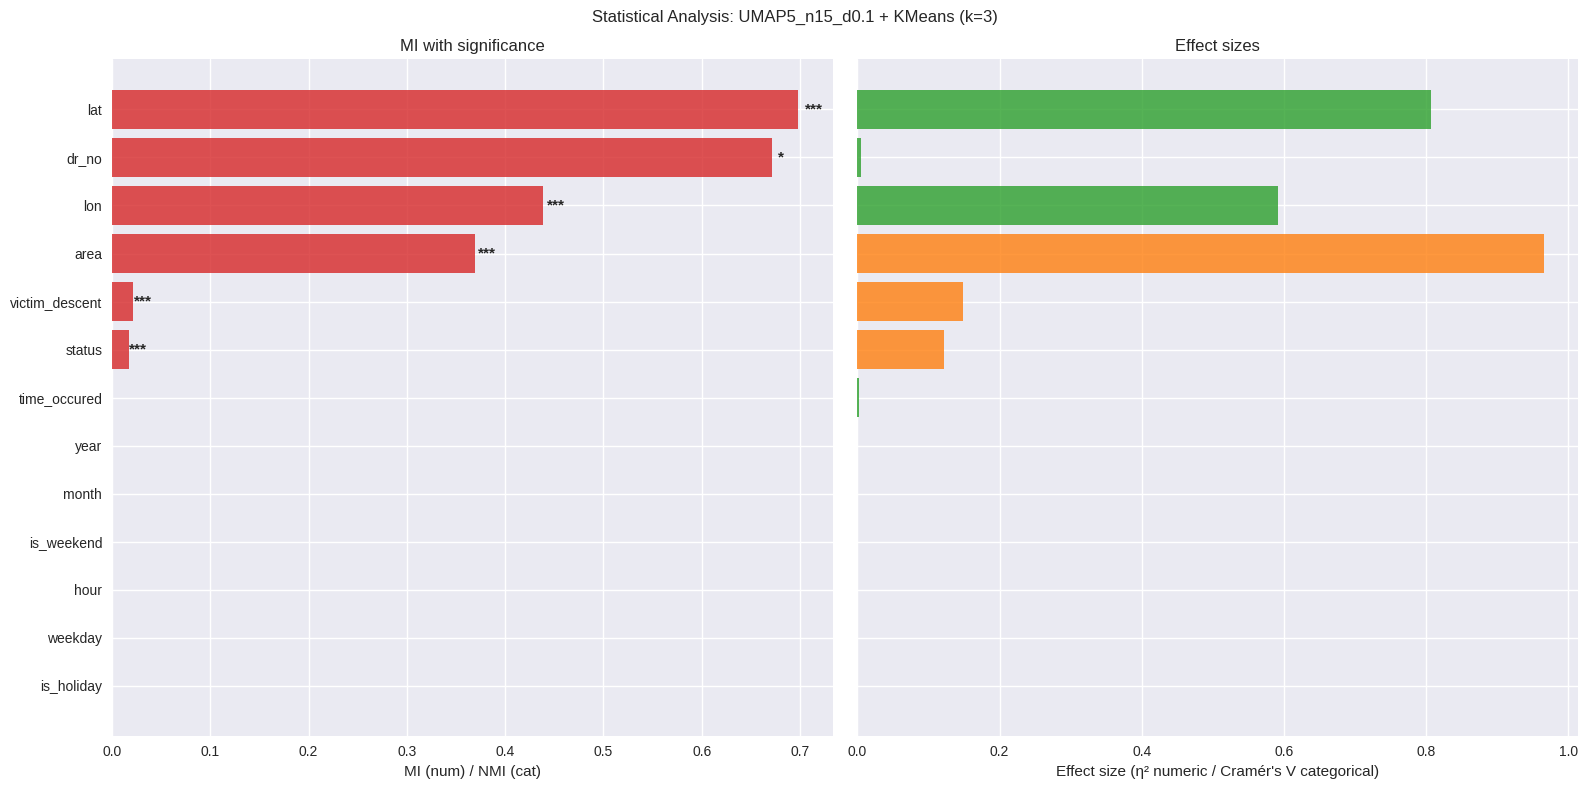


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP5_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

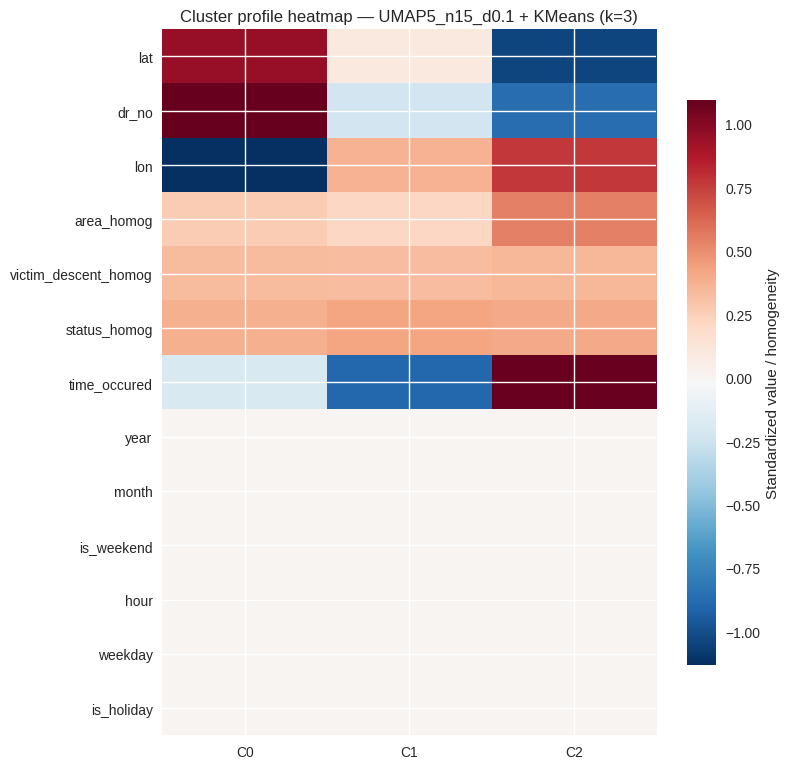


[2/10] UMAP7_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

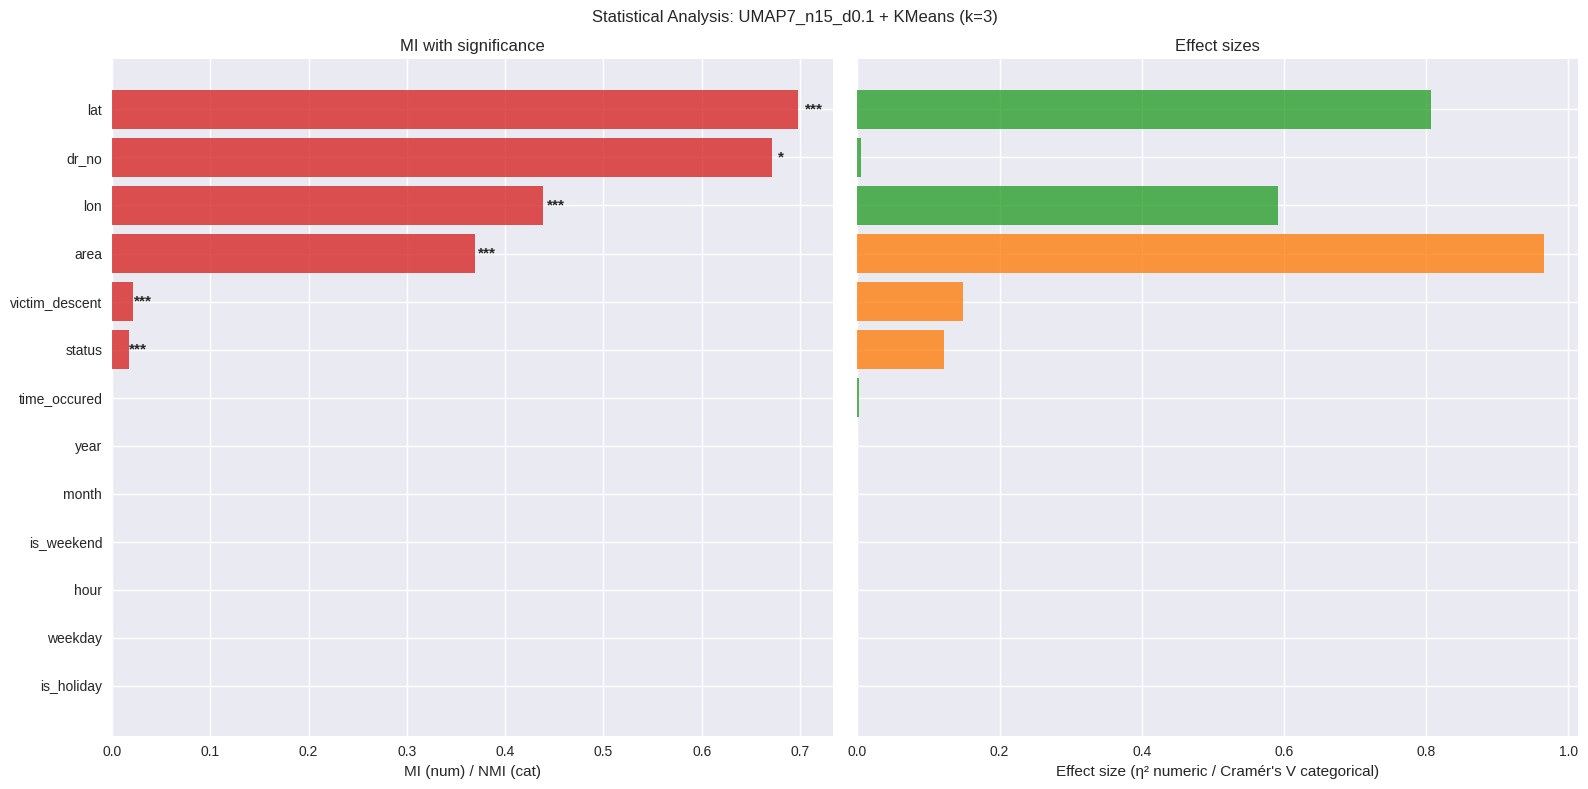


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP7_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

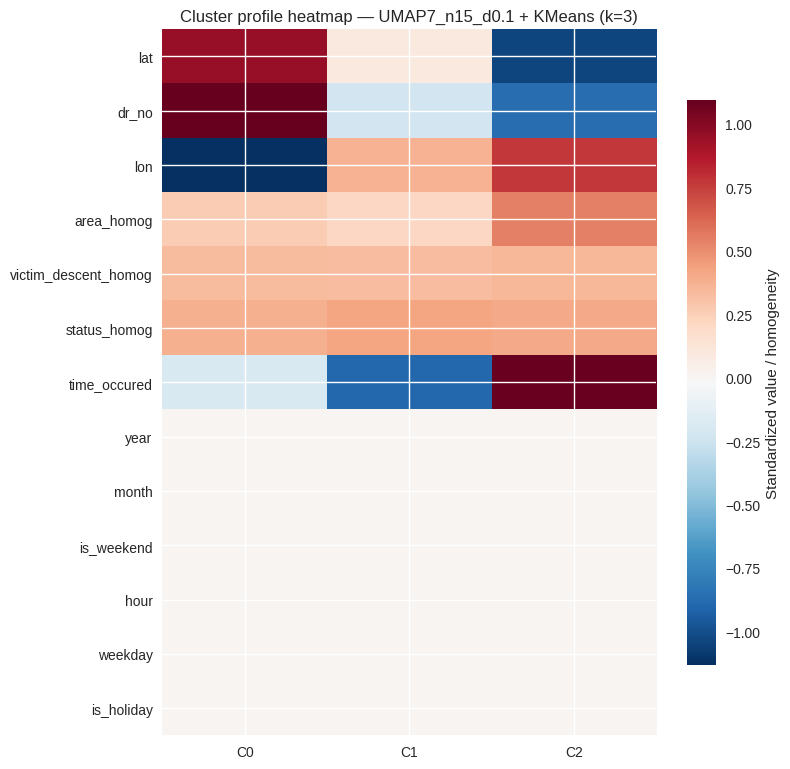


[3/10] UMAP8_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

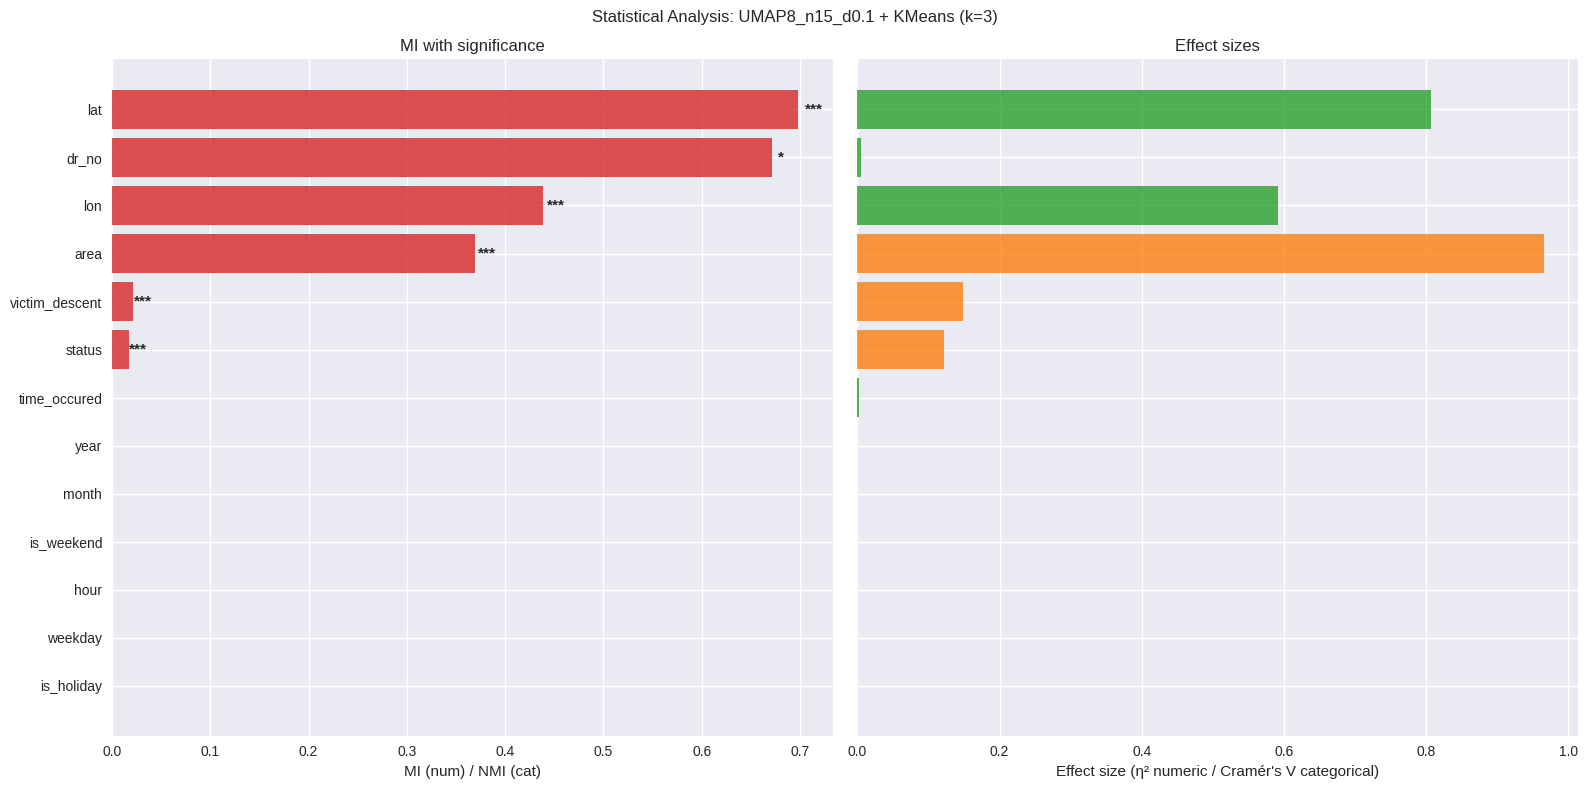


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP8_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

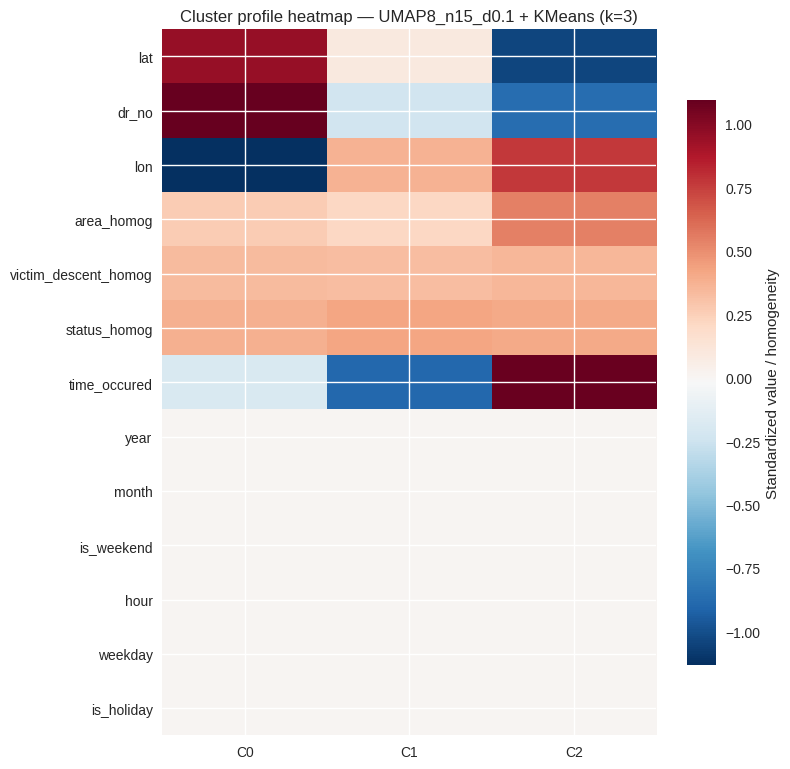


[4/10] UMAP4_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

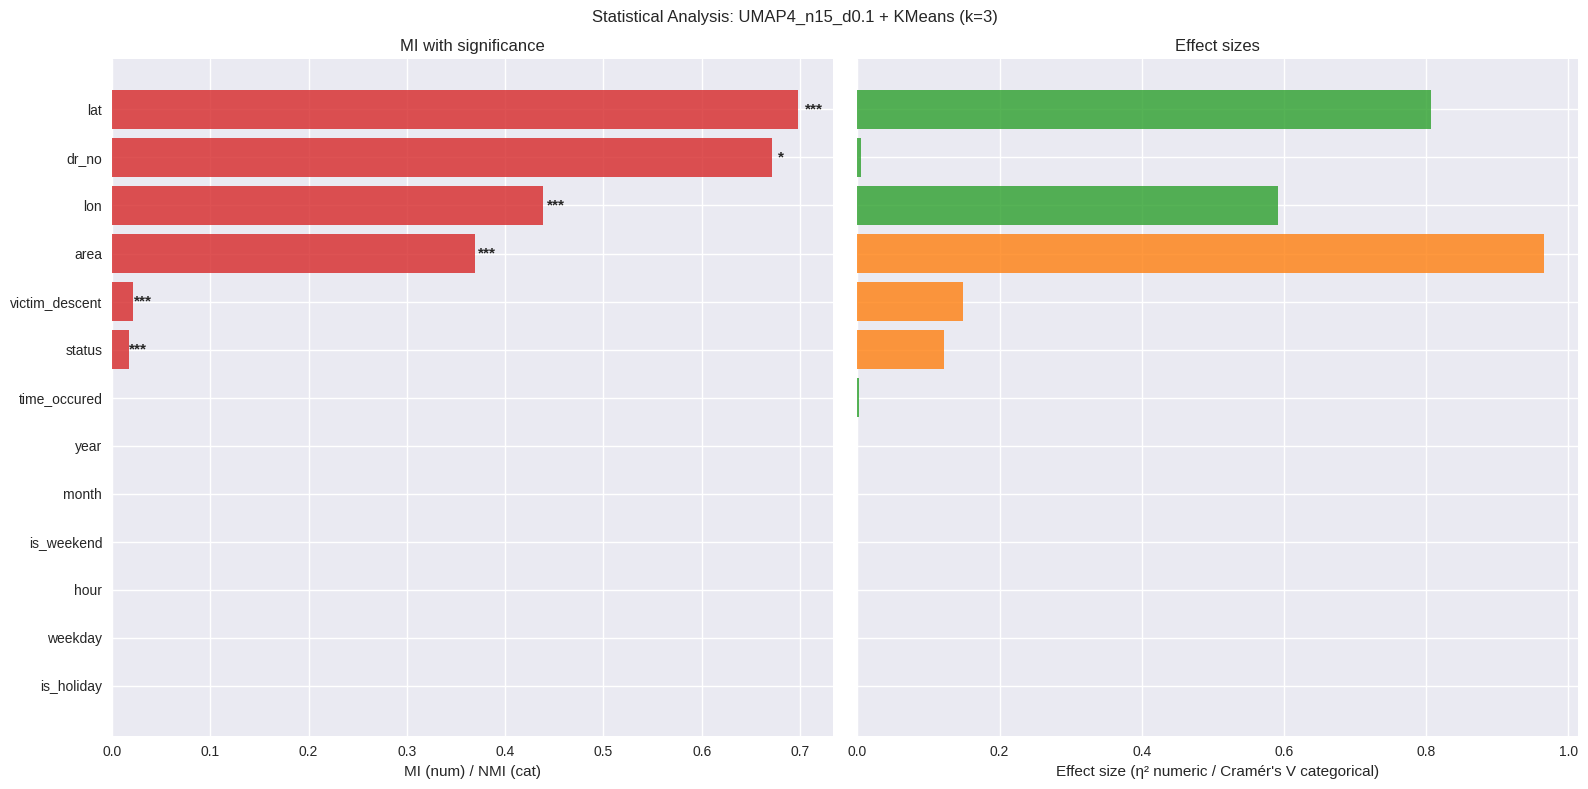


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP4_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

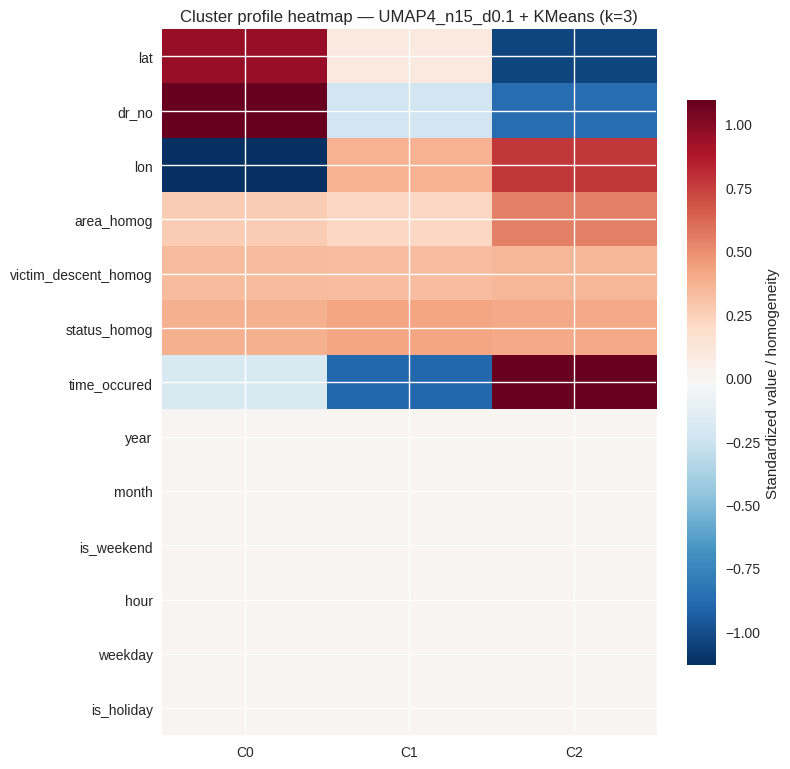


[5/10] UMAP6_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

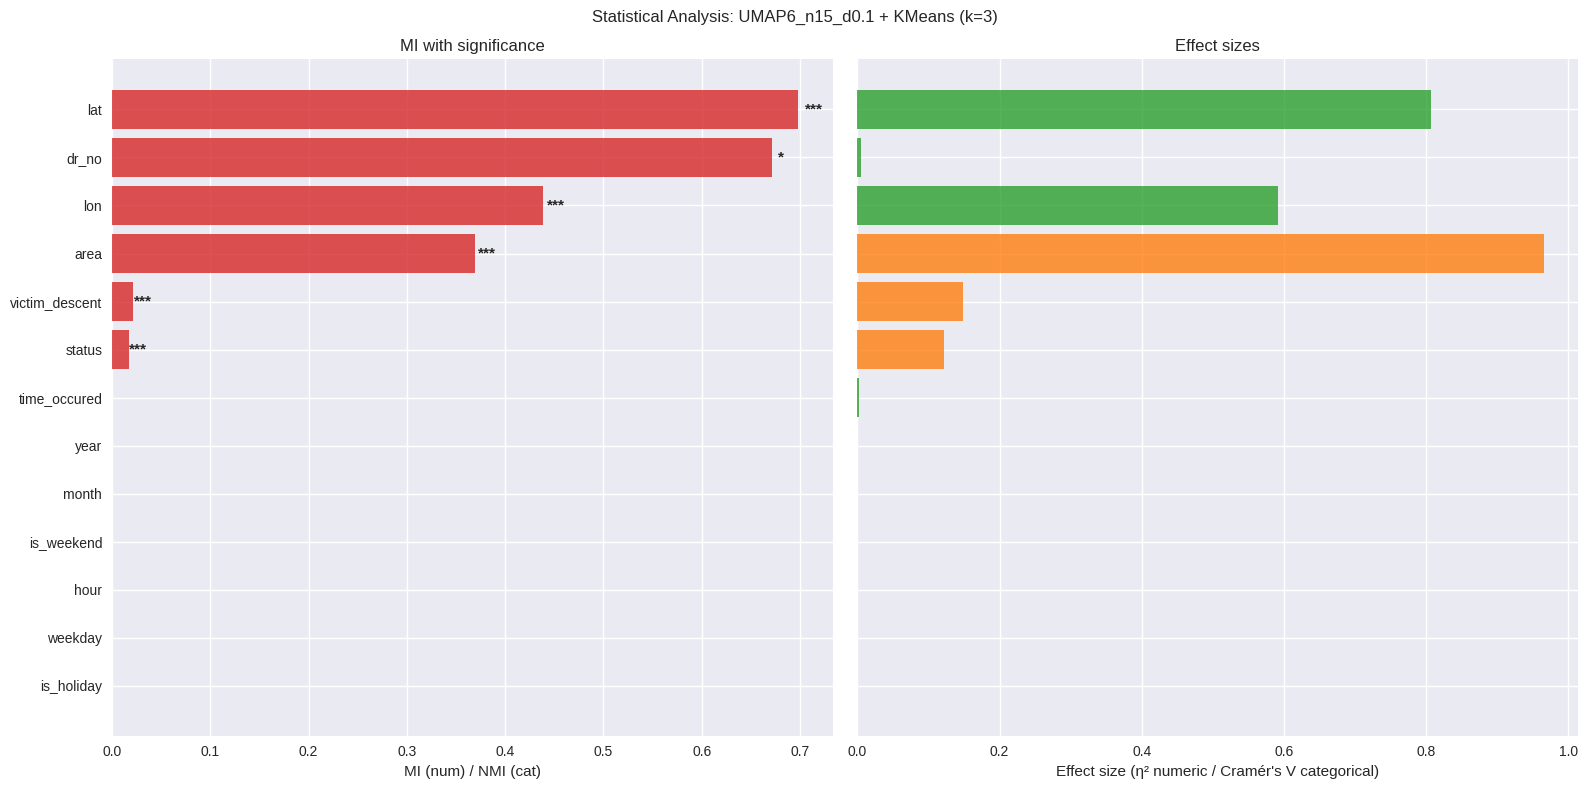


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP6_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

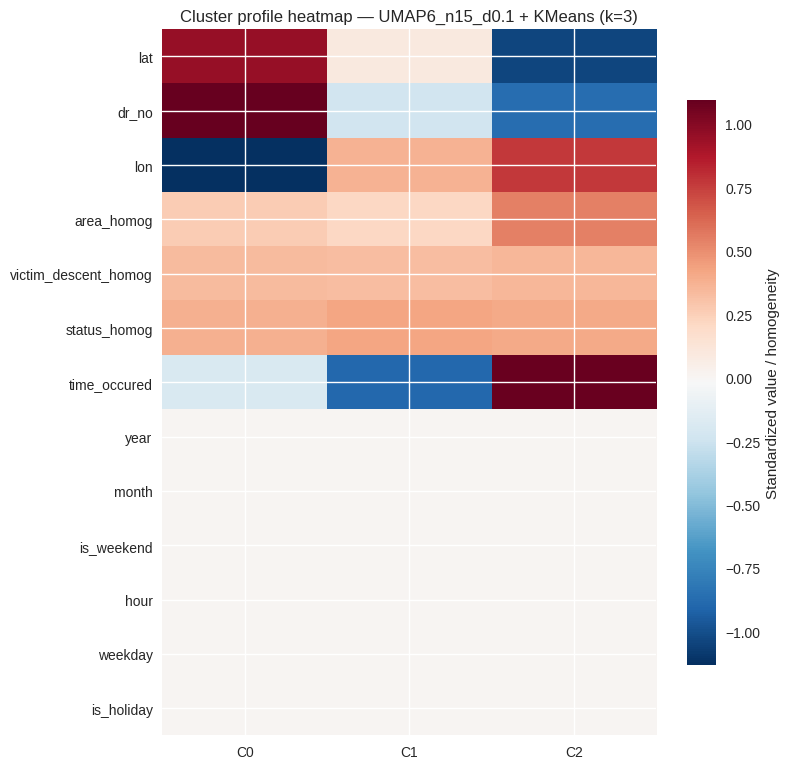


[6/10] UMAP3_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

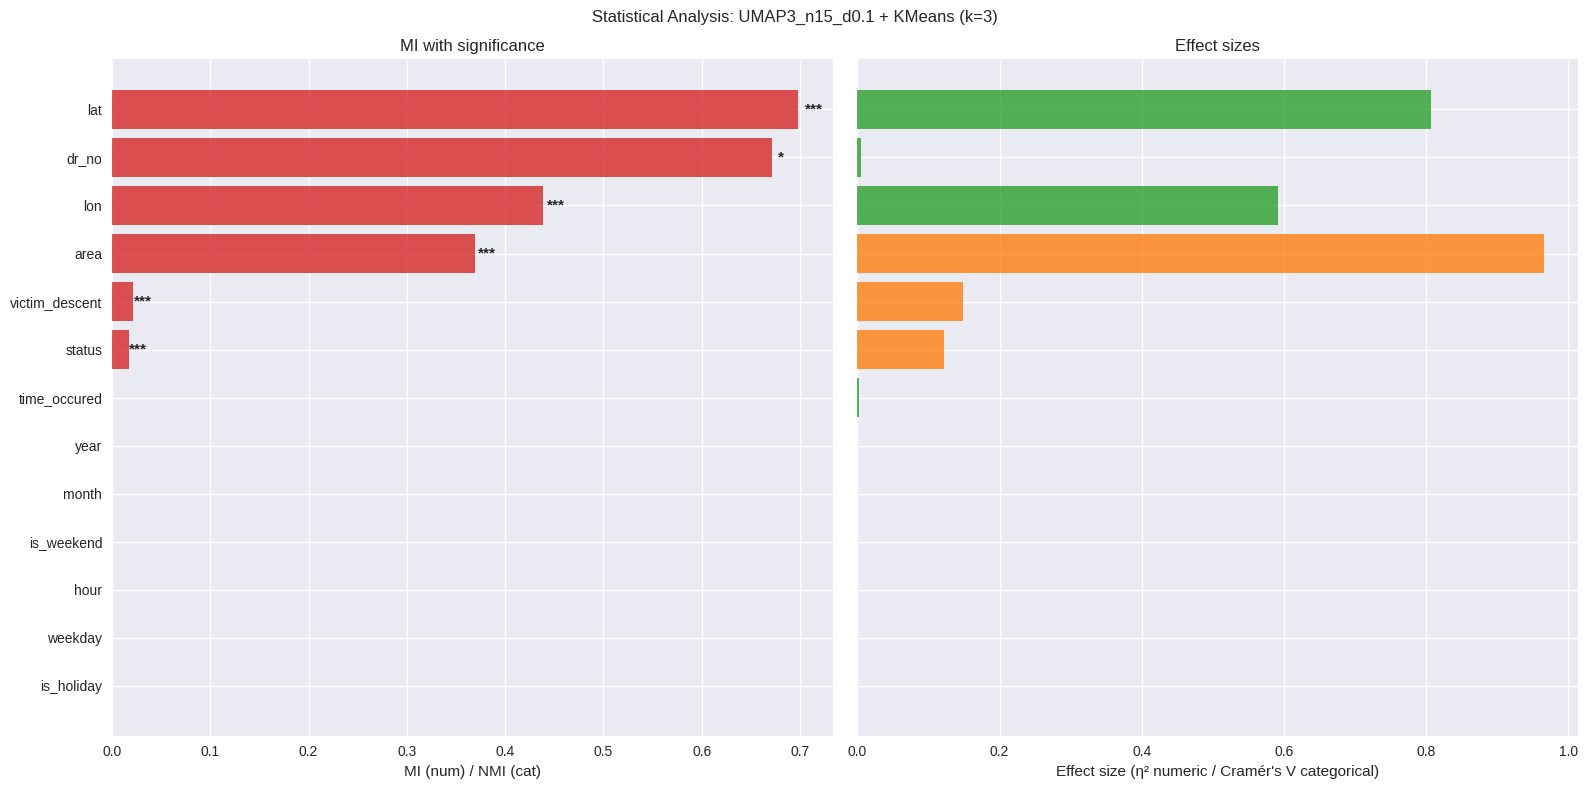


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP3_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

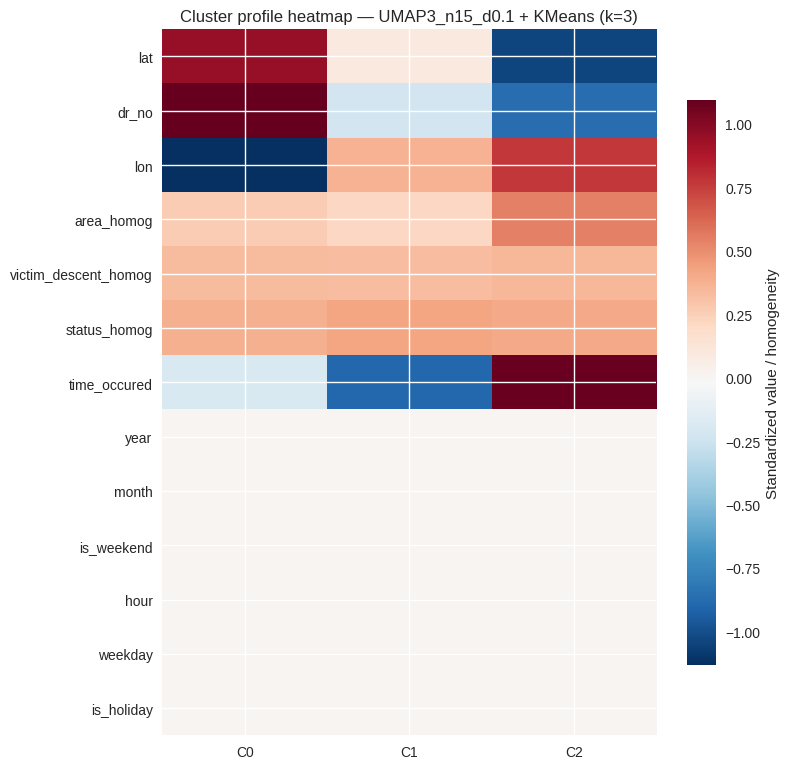


[7/10] UMAP5_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2454.9867   0.0000    0.5310       0.5982     1651         True
         dr_no     numeric          7.7194   0.0055    0.5271       0.0047     1651         True
           lon     numeric       2304.4237   0.0000    0.3817       0.5829     1651         True
          area categorical       1623.4325   0.0000    0.2972       0.9916     1651         True
victim_descent categorical         63.6695   0.0000    0.0205       0.1964     1651         True
        status categorical         44.8944   0.0000    0.0172       0.1649     1651         True
  time_occured     numeric          0.7917   0.3737    0.0057       0.0005     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

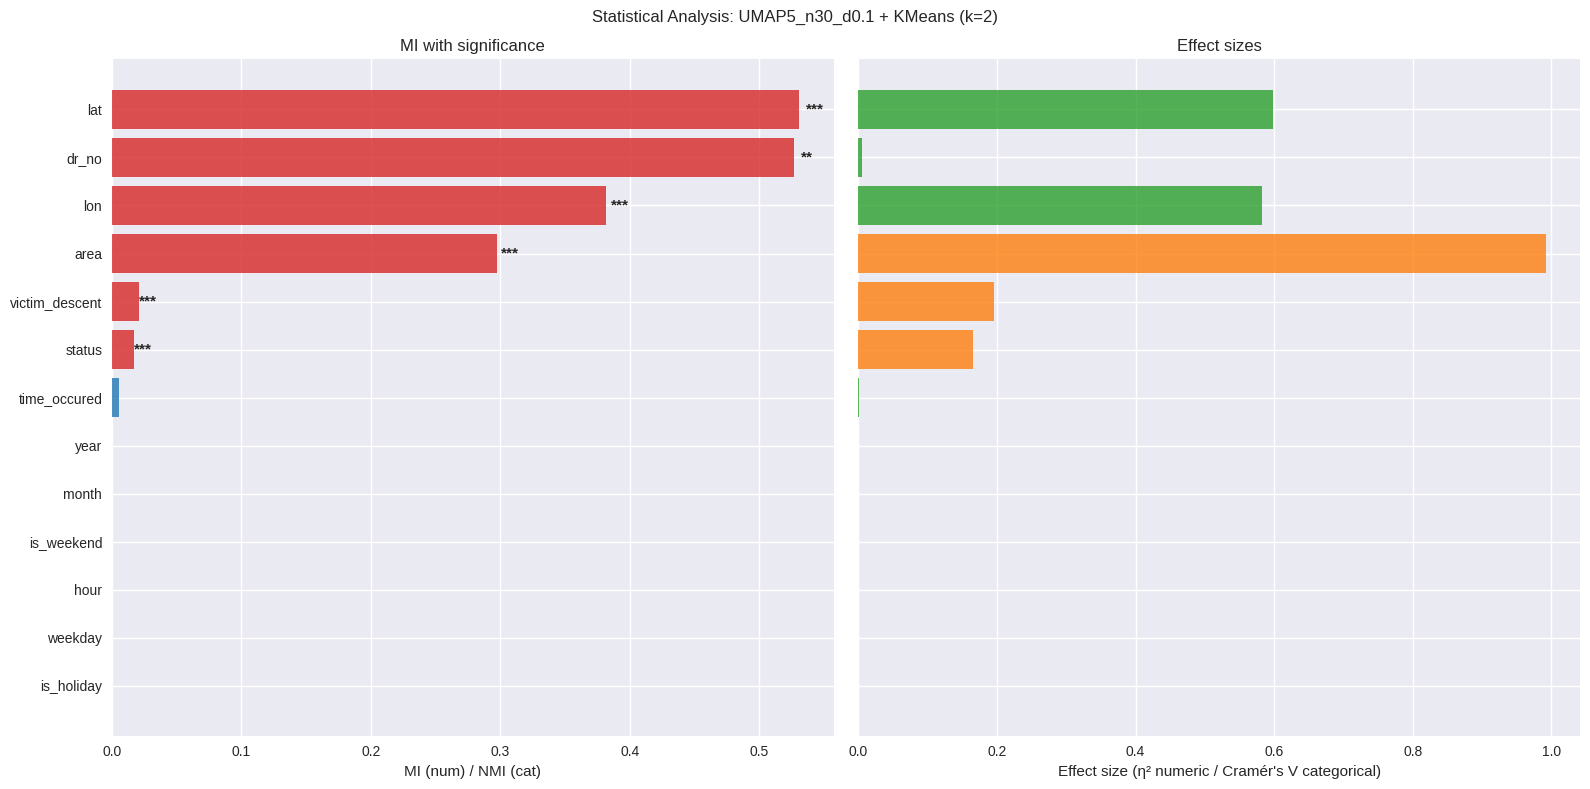


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP5_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.531, p=0
  [NUM] lon: z=-1.40 (low), MI=0.382, p=2.01e-315
  [NUM] dr_no: z=0.13 (high), MI=0.527, p=0.00552
  [CAT] victim_descent: top='H' (49.5%), MI=0.021, p=2.78e-11
  [CAT] status: top='Invest Cont' (44.7%), MI=0.017, p=4.18e-09
  [CAT] area: top='Mission' (18.0%), MI=0.297, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.531, p=0
  [NUM] lon: z=0.42 (high), MI=0.382, p=2.01e-315
  [NUM] dr_no: z=-0.04 (low), MI=0.527, p=0.00552
  [CAT] status: top='Invest Cont' (63.6%), MI=0.017, p=4.18e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.021, p=2.78e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.297, p=0


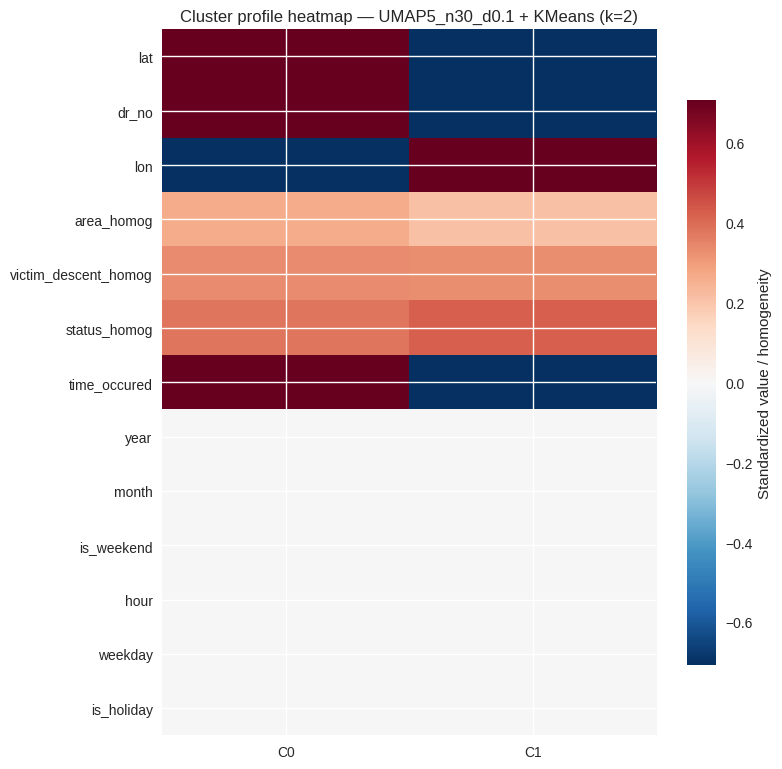


[8/10] UMAP6_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

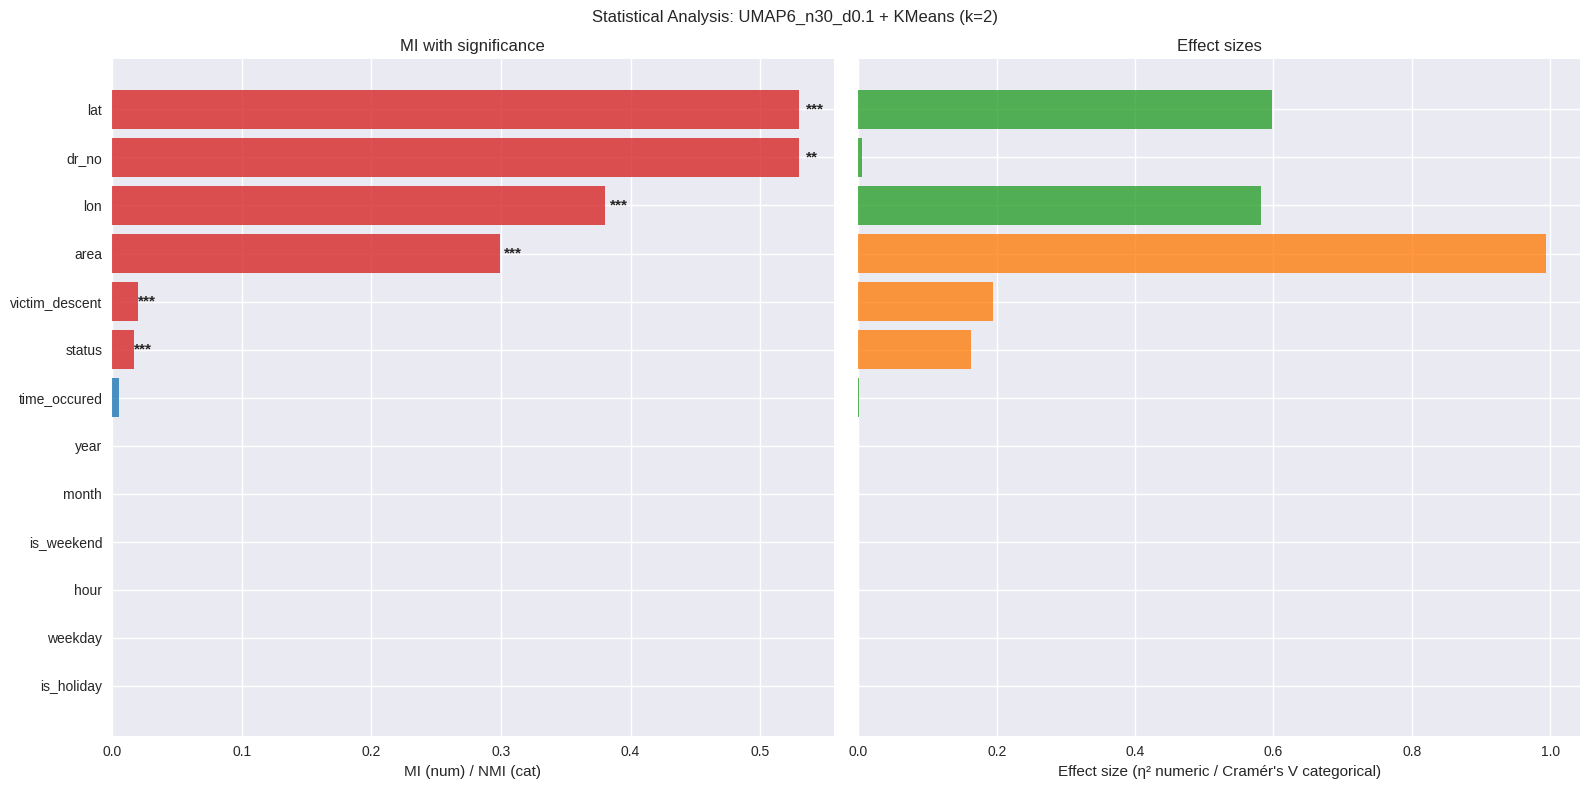


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP6_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


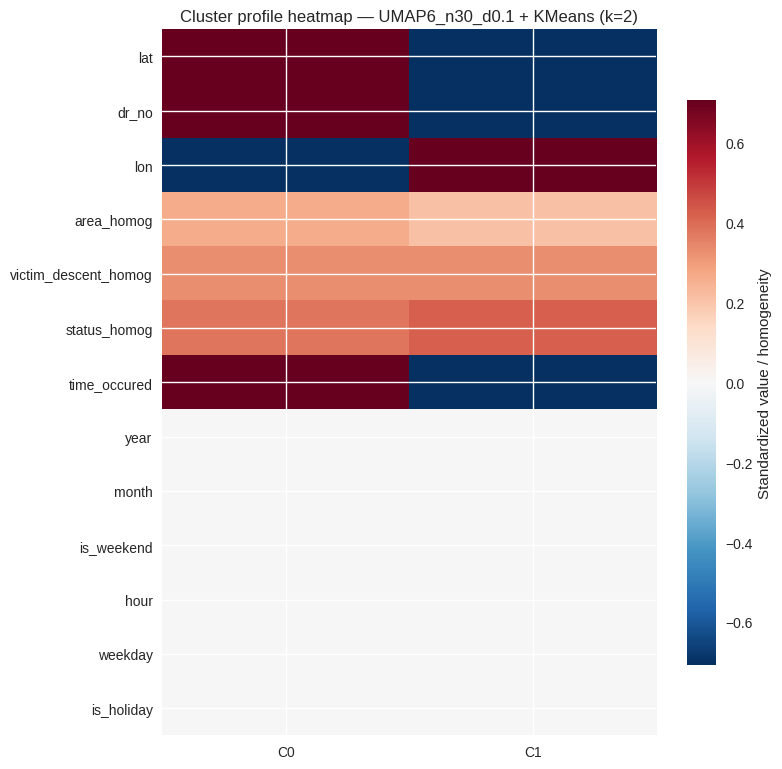


[9/10] UMAP7_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

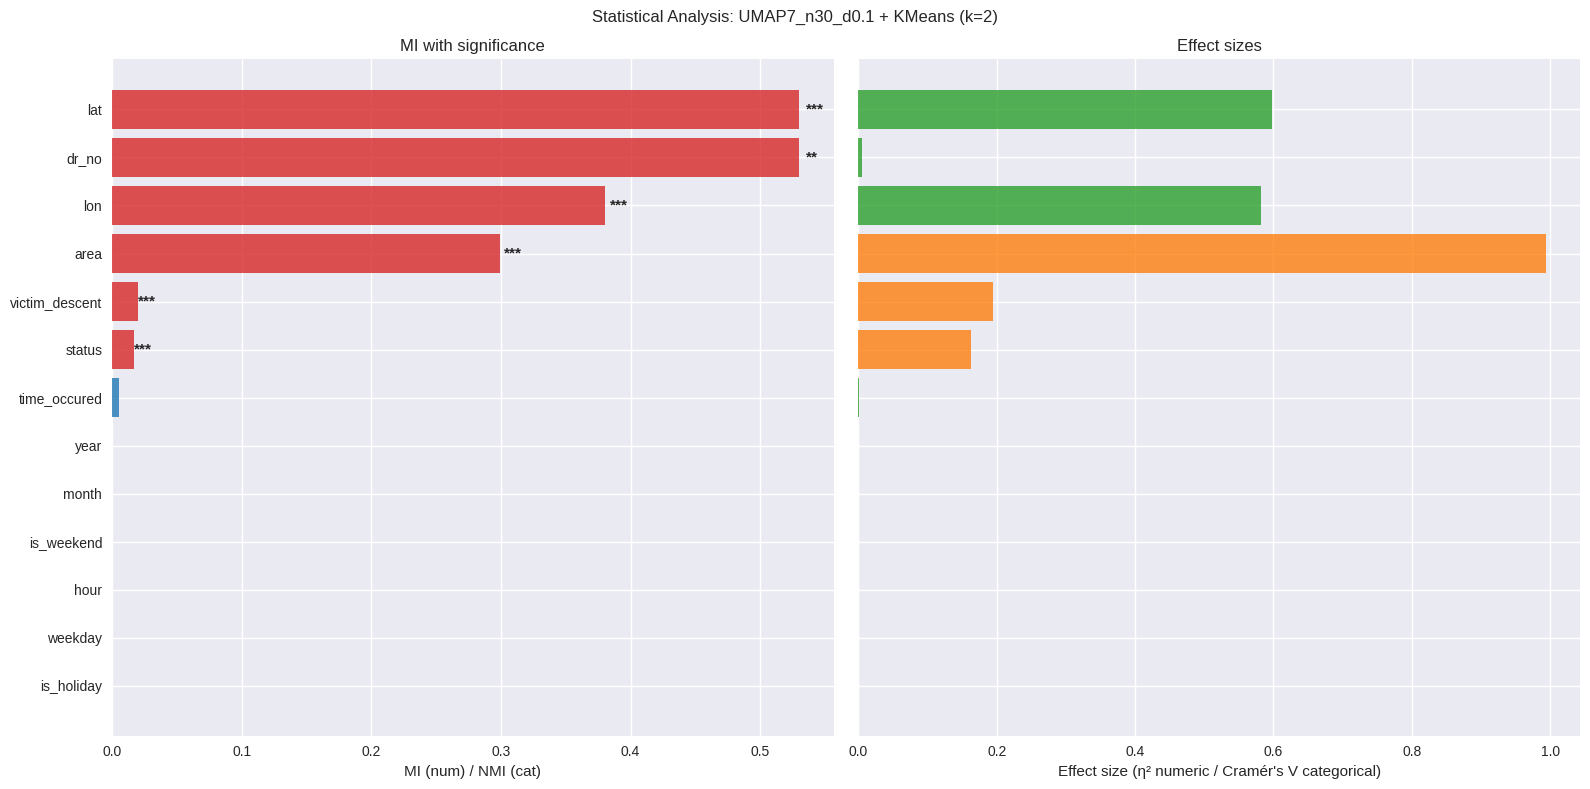


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP7_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


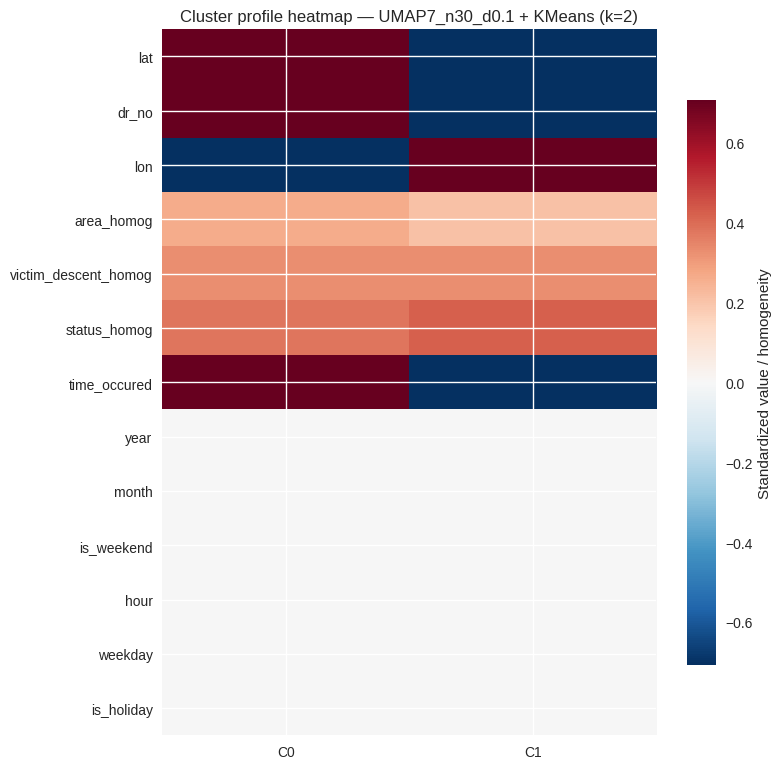


[10/10] UMAP8_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651     

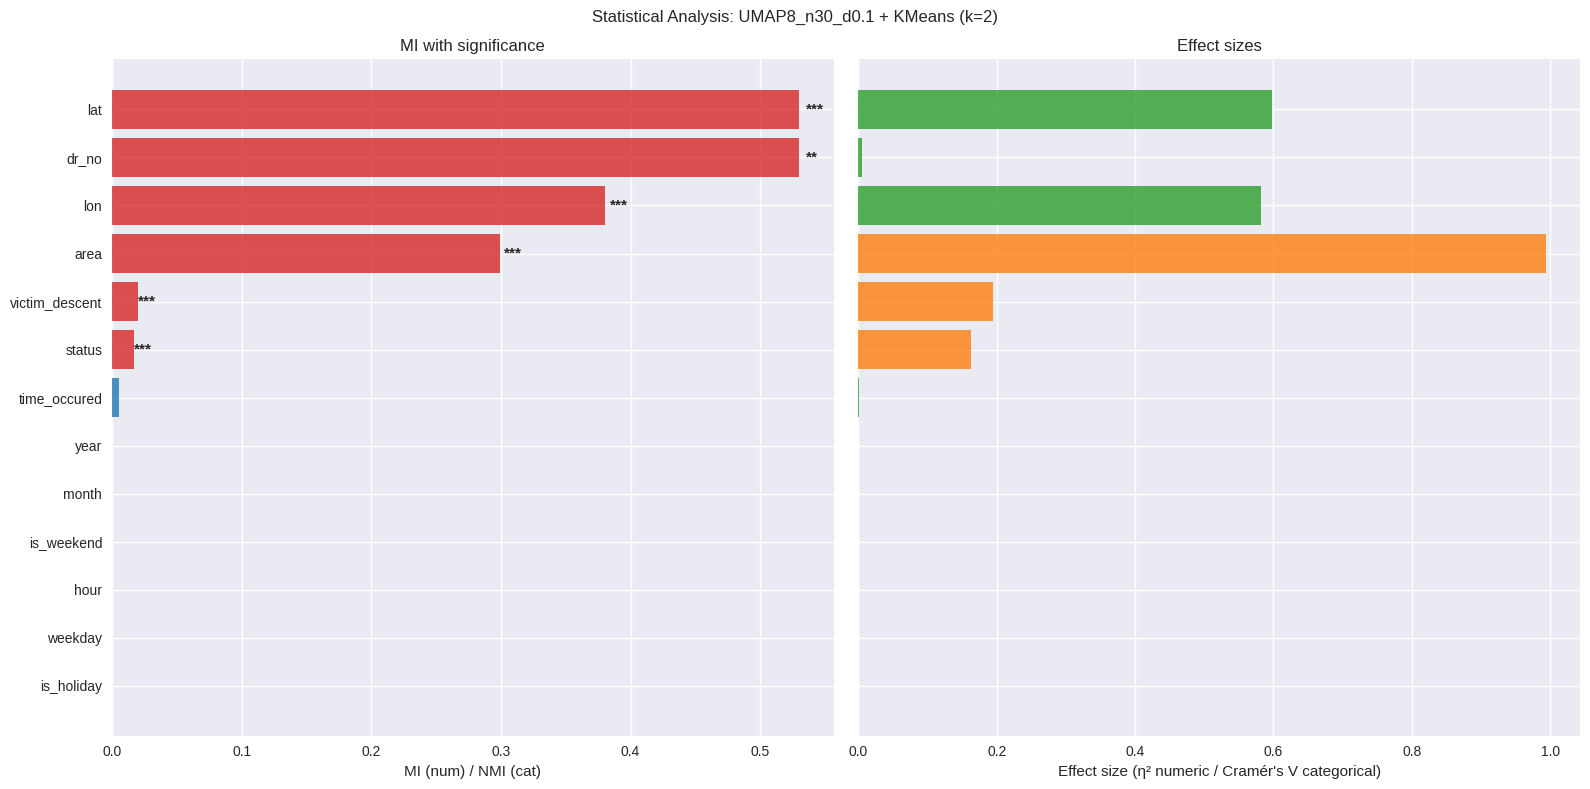


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP8_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


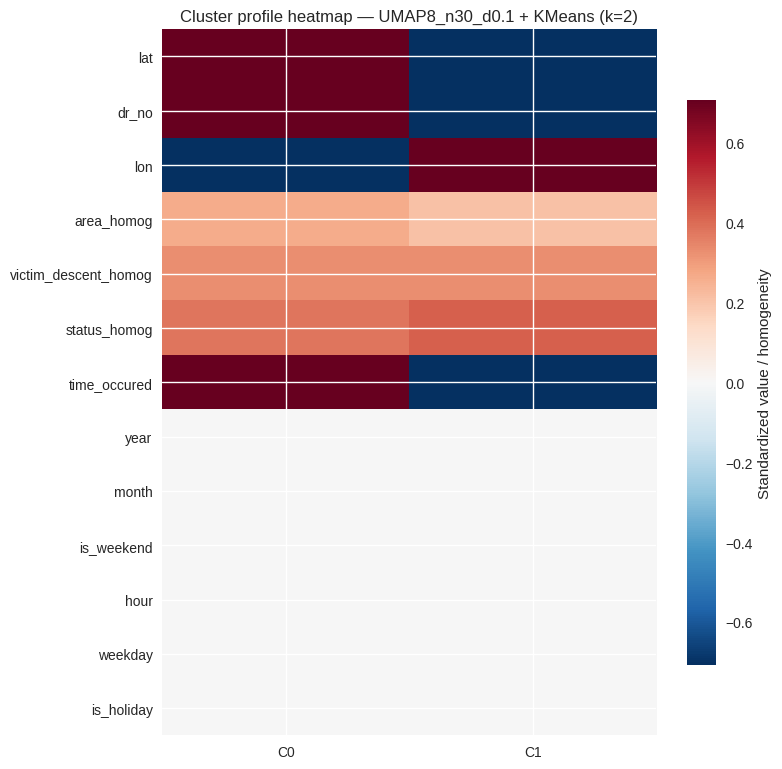


STATISTICAL SIGNIFICANCE SUMMARY (Top-10)
                  combination  n_features  n_significant  significance_rate  max_mi_score top_feature  top_feature_pvalue
UMAP5_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP7_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP8_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP4_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP6_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP3_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP5_n30_d0.1 + KMeans (k=2)          13              6             0.4615        0.5310         lat  

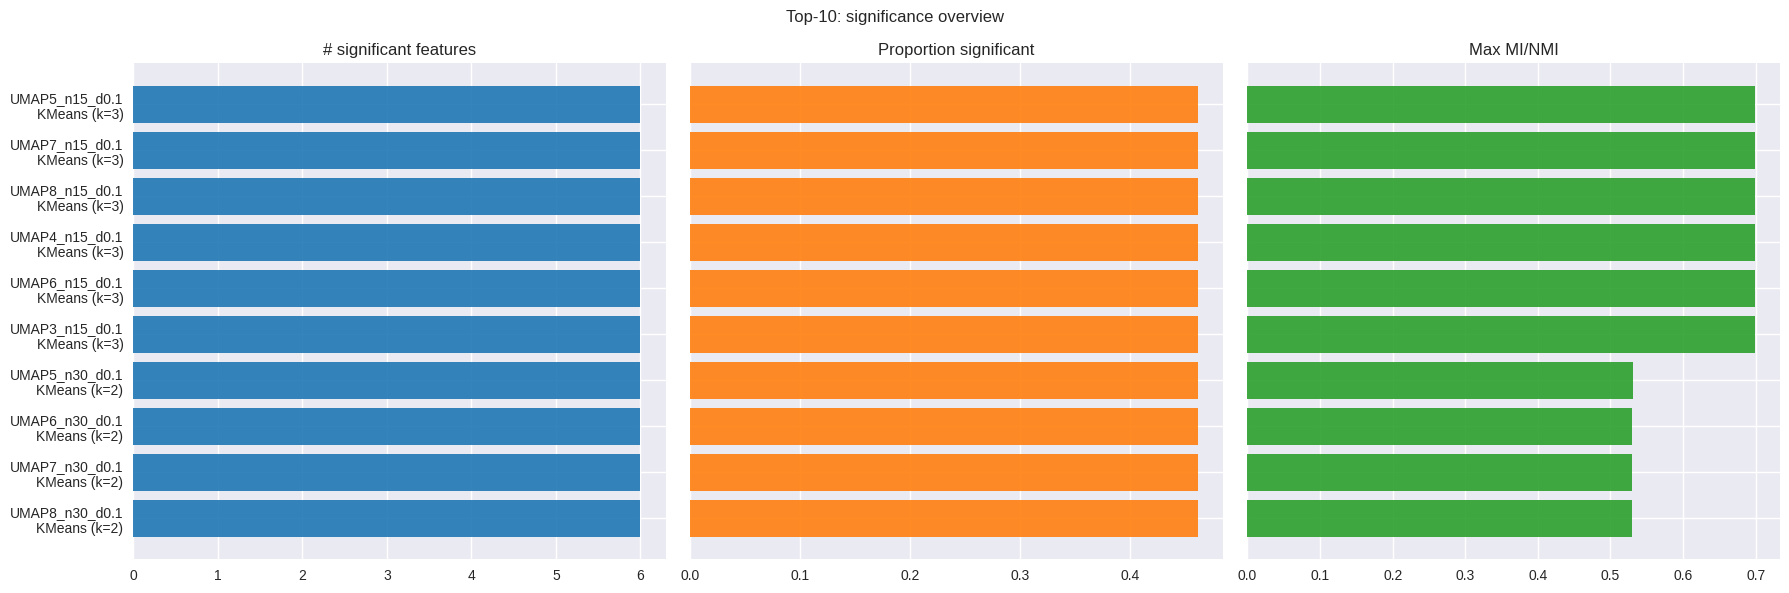

[Saved] /content/figs_comprehensive_unsup/charts/top10_significance_overview.png


In [ ]:
#version3
# =================================================================================================
# TOP-10 CLUSTER INTERPRETATION WITH STATISTICAL SIGNIFICANCE, PRINTED + PLOTTED
# - Fixes NameError (no more `your_top10_list`)
# - Prints all results inline (tables + summaries)
# - Adds per-cluster maps: cluster id + color + the significant features it’s most associated with
# =================================================================================================

import os, re, time, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import normalized_mutual_info_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ------------------------ PATHS & TOP10 (from your last run) ------------------------
CLEAN_PATH = "/content/lapd_clean_5k.parquet"
OUT_BASE   = "/content/cluster_interpretation"
FIG_BASE   = "/content/figs_comprehensive_unsup/charts"
os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(FIG_BASE, exist_ok=True)

TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

# ------------------------ Significance helpers ------------------------
def calculate_statistical_significance(df, labels, alpha=0.05):
    """
    For every column in df vs cluster labels:
      - numeric: ANOVA p, MI (mutual_info_classif), eta^2
      - categorical: chi-square p, NMI, Cramér's V
    Returns sorted DataFrame (by MI/NMI).
    """
    results = []
    uniq = np.unique(labels[labels >= 0])
    if len(uniq) < 2:
        print("Warning: Less than 2 clusters found → skipping significance")
        return pd.DataFrame()

    for col in df.columns:
        if col.startswith("__"):  # skip internal
            continue

        s = df[col]
        valid = s.notna() & (labels >= 0)
        if valid.sum() < 10:
            continue

        s_val = s[valid]
        y_val = labels[valid]

        try:
            if pd.api.types.is_numeric_dtype(s):
                groups = [s_val[y_val == c] for c in uniq]
                groups = [g for g in groups if len(g) > 0]
                if len(groups) < 2:
                    continue

                f_stat, p_value = f_oneway(*groups)
                X_col = s_val.values.reshape(-1, 1)
                mi = mutual_info_classif(X_col, y_val, discrete_features=False, random_state=42)[0]

                ss_total = np.sum((s_val - s_val.mean())**2)
                ss_within = sum(np.sum((g - g.mean())**2) for g in groups)
                eta2 = (ss_total - ss_within) / ss_total if ss_total > 0 else 0.0

                results.append({
                    "feature": col, "type": "numeric",
                    "test_statistic": float(f_stat), "p_value": float(p_value),
                    "mi_score": float(mi), "effect_size": float(eta2),
                    "n_valid": int(len(s_val)), "significant": bool(p_value < alpha)
                })
            else:
                ct = pd.crosstab(s_val, y_val)
                if ct.shape[0] < 2 or ct.shape[1] < 2:
                    continue
                chi2, p_value, dof, exp = chi2_contingency(ct)
                nmi = normalized_mutual_info_score(s_val.astype(str), y_val)
                n = ct.values.sum()
                cramers_v = np.sqrt(chi2 / (n * (min(ct.shape) - 1)))

                results.append({
                    "feature": col, "type": "categorical",
                    "test_statistic": float(chi2), "p_value": float(p_value),
                    "mi_score": float(nmi), "effect_size": float(cramers_v),
                    "n_valid": int(len(s_val)), "significant": bool(p_value < alpha)
                })
        except Exception as e:
            print(f"[WARN] significance failed for {col}: {e}")

    res = pd.DataFrame(results)
    if len(res):
        res = res.sort_values("mi_score", ascending=False).reset_index(drop=True)
    return res

def plot_enhanced_mi(results_df, combo_name, save_path, top_n=20, show=True):
    top_df = results_df.head(top_n).copy()
    if len(top_df) == 0:
        return None
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(top_df) * 0.4)))
    colors = ['#d62728' if s else '#1f77b4' for s in top_df['significant']]
    bars1 = ax1.barh(range(len(top_df)), top_df['mi_score'], color=colors, alpha=0.8)
    ax1.set_yticks(range(len(top_df))); ax1.set_yticklabels(top_df['feature'])
    ax1.set_xlabel('MI (num) / NMI (cat)'); ax1.set_title('MI with significance')
    ax1.invert_yaxis()
    for i, (bar, p) in enumerate(zip(bars1, top_df['p_value'])):
        mark = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        if mark:
            ax1.text(bar.get_width()*1.01, i, mark, va='center', fontsize=11, weight='bold')
    eff_colors = ['#2ca02c' if t == 'numeric' else '#ff7f0e' for t in top_df['type']]
    ax2.barh(range(len(top_df)), top_df['effect_size'], color=eff_colors, alpha=0.8)
    ax2.set_yticks(range(len(top_df))); ax2.set_yticklabels(['']*len(top_df))
    ax2.set_xlabel("Effect size (η² numeric / Cramér's V categorical)")
    ax2.set_title('Effect sizes'); ax2.invert_yaxis()
    plt.suptitle(f'Statistical Analysis: {combo_name}', y=0.98)
    plt.tight_layout(); plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()
    return save_path

def cluster_colors(labels):
    """Map cluster id -> color hex using tab20; -1 (noise) is gray."""
    uniq = sorted(list(set(labels)))
    base = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {}
    i = 0
    for u in uniq:
        if u == -1:
            cmap[u] = (0.6,0.6,0.6,0.7)
        else:
            cmap[u] = base[i % len(base)]
            i += 1
    # convert to hex
    cmap_hex = {k: '#%02x%02x%02x' % (int(v[0]*255), int(v[1]*255), int(v[2]*255)) for k,v in cmap.items()}
    return cmap_hex

def build_cluster_feature_map(df, labels, sig_df, top_k_per_feature=None):
    """
    For each cluster:
      - For significant numeric features: show z-score of cluster mean vs global mean
      - For significant categorical features: show dominant category + share
    Returns: dict(cluster -> list of dicts describing feature associations)
    """
    out = {}
    valid = labels >= 0
    if valid.sum() == 0 or len(sig_df) == 0:
        return out

    dfv = df.loc[valid].copy()
    labv = labels[valid]
    dfv['__cluster'] = labv
    uniq = sorted(dfv['__cluster'].unique())

    for cl in uniq:
        out[cl] = []

    for _, row in sig_df.iterrows():
        f = row['feature']
        if f not in df.columns:
            continue

        if row['type'] == 'numeric' and pd.api.types.is_numeric_dtype(dfv[f]):
            grp = dfv.groupby('__cluster')[f].agg(['mean','count'])
            gmean, gstd = dfv[f].mean(), (dfv[f].std() + 1e-8)
            for cl in uniq:
                if cl in grp.index:
                    z = (grp.loc[cl,'mean'] - gmean) / gstd
                    out[cl].append({
                        "feature": f, "type": "numeric",
                        "z_score": float(z),
                        "direction": "high" if z > 0 else "low",
                        "abs_z": float(abs(z)),
                        "mi_score": float(row['mi_score']),
                        "p_value": float(row['p_value'])
                    })

        else:
            # categorical
            try:
                sub = dfv[['__cluster', f]].dropna()
                if sub.empty:
                    continue
                tab = (sub[sub['__cluster'] >= 0]
                       .groupby(['__cluster', f]).size()
                       .unstack(fill_value=0))
                prop = tab.div(tab.sum(axis=1), axis=0)
                for cl in uniq:
                    if cl in prop.index:
                        top_cat = prop.loc[cl].idxmax()
                        top_share = prop.loc[cl].max()
                        out[cl].append({
                            "feature": f, "type": "categorical",
                            "top_category": str(top_cat),
                            "top_share": float(top_share),
                            "mi_score": float(row['mi_score']),
                            "p_value": float(row['p_value'])
                        })
            except Exception:
                continue

    # Optionally trim to strongest per-cluster
    if top_k_per_feature is not None:
        trimmed = {}
        for cl, feats in out.items():
            # sort numeric by |z|, categorical by top_share
            nums = [d for d in feats if d['type']=='numeric']
            cats = [d for d in feats if d['type']=='categorical']
            nums = sorted(nums, key=lambda d: (abs(d.get('z_score',0)), d.get('mi_score',0)), reverse=True)[:top_k_per_feature]
            cats = sorted(cats, key=lambda d: (d.get('top_share',0), d.get('mi_score',0)), reverse=True)[:top_k_per_feature]
            trimmed[cl] = nums + cats
        return trimmed

    return out

def print_cluster_feature_map(cluster_map, color_map, combo_name, max_lines_per_cluster=30):
    print("\n" + "-"*90)
    print(f"CLUSTER → FEATURE MAP  |  {combo_name}")
    print("-"*90)
    for cl in sorted(cluster_map.keys()):
        feats = cluster_map[cl]
        color = color_map.get(cl, "#999999")
        print(f"\nCluster {cl}  color={color}  (#features={len(feats)})")
        if not feats:
            print("  (no significant associations)")
            continue
        # Order numeric (by |z| desc) first, then categorical (by top_share desc)
        nums = [d for d in feats if d['type']=="numeric"]
        cats = [d for d in feats if d['type']=="categorical"]
        nums = sorted(nums, key=lambda d: (abs(d.get('z_score',0)), d.get('mi_score',0)), reverse=True)
        cats = sorted(cats, key=lambda d: (d.get('top_share',0), d.get('mi_score',0)), reverse=True)
        lines = []
        for d in nums:
            lines.append(f"  [NUM] {d['feature']}: z={d['z_score']:.2f} ({d['direction']}), MI={d['mi_score']:.3f}, p={d['p_value']:.3g}")
        for d in cats:
            lines.append(f"  [CAT] {d['feature']}: top='{d['top_category']}' ({d['top_share']*100:.1f}%), MI={d['mi_score']:.3f}, p={d['p_value']:.3g}")
        if len(lines) > max_lines_per_cluster:
            lines = lines[:max_lines_per_cluster] + [f"  ... (+{len(nums)+len(cats)-max_lines_per_cluster} more)"]
        print("\n".join(lines))

def create_profile_heatmap(df, labels, top_features, combo_name, save_path, show=True):
    """Heatmap where numeric features are standardized means; categoricals use homogeneity proxy."""
    df2 = df.copy()
    df2['__cluster'] = labels
    valid = labels >= 0
    df2 = df2.loc[valid]
    uniq = sorted(df2['__cluster'].unique())
    rows, names = [], []

    for f in top_features:
        if f not in df2.columns:
            continue
        if pd.api.types.is_numeric_dtype(df2[f]):
            m = df2.groupby('__cluster')[f].mean()
            z = (m - m.mean()) / (m.std()+1e-8)
            rows.append(z.reindex(uniq).values)
            names.append(f)
        else:
            def _h(x):
                vc = x.value_counts(normalize=True)
                return 1.0/(1.0 + (-np.sum((vc*np.log2(vc+1e-8)).fillna(0))))
            h = df2.groupby('__cluster')[f].apply(_h)
            rows.append(h.reindex(uniq).values)
            names.append(f + "_homog")

    if len(rows)==0:
        return None

    M = np.vstack(rows)
    plt.figure(figsize=(max(8, len(uniq)*1.4), max(6, len(names)*0.6)))
    im = plt.imshow(M, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='Standardized value / homogeneity', shrink=0.8)
    plt.xticks(range(len(uniq)), [f"C{c}" for c in uniq]); plt.yticks(range(len(names)), names)
    plt.title(f"Cluster profile heatmap — {combo_name}")
    plt.tight_layout(); plt.savefig(save_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return save_path

# ------------------------ Pipeline integration ------------------------
def integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE, alpha=0.05, top_n_plot=20):
    # Load data
    if CLEAN_PATH.endswith(".parquet"):
        df = pd.read_parquet(CLEAN_PATH)
    else:
        df = pd.read_csv(CLEAN_PATH, low_memory=False)
    print(f"[DATA] Loaded: {df.shape}")

    # Feature prep (same design as before)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if (not pd.api.types.is_numeric_dtype(df[c])) and df[c].nunique() <= 30]
    DROP_LIKE = {"victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code","Crime Code Description","ARREST MADE","Status","Status Desc"}
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
    Xdf = df[use_cols].copy()
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    pre = ColumnTransformer([
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", ohe, [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ], remainder="drop")

    X_sparse = pre.fit_transform(Xdf)
    svd_comp = min(50, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=svd_comp, random_state=42)
    X_svd = svd.fit_transform(X_sparse)

    # Parse combos, build UMAP embedding on SVD, cluster with KMeans, then analyze
    import umap

    def parse_combo(s):
        # e.g., "UMAP5_n15_d0.1 + KMeans (k=3)"
        m = re.match(r"UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+)\s+\+\s+KMeans\s+\(k=(\d+)\)", s.strip())
        if not m: raise ValueError(f"Cannot parse combo: {s}")
        return dict(n_components=int(m.group(1)), n_neighbors=int(m.group(2)), min_dist=float(m.group(3)), k=int(m.group(4)))

    summaries = []
    all_results = {}

    print("\n" + "="*80)
    print("ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS (Top-10)")
    print("="*80)

    for i, combo in enumerate(TOP10, 1):
        p = parse_combo(combo)
        reducer = umap.UMAP(n_components=p['n_components'], n_neighbors=p['n_neighbors'], min_dist=p['min_dist'],
                            metric="euclidean", random_state=42, verbose=False)
        X_emb = reducer.fit_transform(X_svd)
        km = KMeans(n_clusters=p['k'], n_init=10, random_state=42)
        labels = km.fit_predict(X_emb)

        # significance over original df (excluding DROP_LIKE)
        sig = calculate_statistical_significance(Xdf, labels, alpha=alpha)

        # print a compact inline summary
        n_sig = int(sig['significant'].sum()) if len(sig) else 0
        print(f"\n[{i}/10] {combo}")
        if len(sig):
            print(sig.head(10).to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,(float,np.floating)) else str(x)))
            print(f"  → features analyzed: {len(sig)} | significant: {n_sig} ({(n_sig/len(sig))*100:.1f}%)")
        else:
            print("  → no analyzable features")

        # plots
        combo_slug = combo.replace(' + ', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
        mi_fig = os.path.join(FIG_BASE, f"{combo_slug}_enhanced_mi.png")
        if len(sig):
            plot_enhanced_mi(sig, combo, mi_fig, top_n=top_n_plot, show=True)

        # per-cluster map (print!)
        cmap = cluster_colors(labels)
        sig_only = sig[sig['significant']].copy()
        cmap_features = build_cluster_feature_map(Xdf, labels, sig_only, top_k_per_feature=None)
        print_cluster_feature_map(cmap_features, cmap, combo_name=combo, max_lines_per_cluster=50)

        # heatmap of top features (by MI)
        top_feats = sig.head(min(15, len(sig)))['feature'].tolist() if len(sig) else []
        if top_feats:
            hm_fig = os.path.join(FIG_BASE, f"{combo_slug}_profile_heatmap.png")
            create_profile_heatmap(Xdf, labels, top_feats, combo, hm_fig, show=True)

        # save CSV for this combo
        csv_path = os.path.join(OUT_BASE, f"{combo_slug}_statistical_analysis.csv")
        if len(sig):
            sig.to_csv(csv_path, index=False)

        # build summary row
        if len(sig):
            summaries.append({
                "combination": combo, "n_features": int(len(sig)),
                "n_significant": int(n_sig),
                "significance_rate": float(n_sig/len(sig)),
                "max_mi_score": float(sig['mi_score'].max()),
                "top_feature": str(sig.iloc[0]['feature']),
                "top_feature_pvalue": float(sig.iloc[0]['p_value'])
            })
        else:
            summaries.append({
                "combination": combo, "n_features": 0, "n_significant": 0,
                "significance_rate": 0.0, "max_mi_score": np.nan,
                "top_feature": "", "top_feature_pvalue": np.nan
            })
        all_results[combo] = sig

    # Summary table (print + save)
    if summaries:
        summ_df = pd.DataFrame(summaries)
        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE SUMMARY (Top-10)")
        print("="*80)
        print(summ_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if pd.notna(x) and isinstance(x,(float,np.floating)) else str(x)))

        summ_csv = os.path.join(OUT_BASE, "statistical_significance_summary.csv")
        summ_df.to_csv(summ_csv, index=False)
        print(f"\n[Saved] {summ_csv}")

        # Small combined overview figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        # bars: n_significant
        axes[0].barh(range(len(summ_df)), summ_df['n_significant'], color='tab:blue', alpha=0.9)
        axes[0].set_yticks(range(len(summ_df))); axes[0].set_yticklabels([c.replace(' + ', '\n') for c in summ_df['combination']])
        axes[0].invert_yaxis(); axes[0].set_title("# significant features")

        # proportion
        axes[1].barh(range(len(summ_df)), summ_df['significance_rate'], color='tab:orange', alpha=0.9)
        axes[1].set_yticks(range(len(summ_df))); axes[1].set_yticklabels(['']*len(summ_df))
        axes[1].invert_yaxis(); axes[1].set_title("Proportion significant")

        # max MI
        axes[2].barh(range(len(summ_df)), summ_df['max_mi_score'].fillna(0), color='tab:green', alpha=0.9)
        axes[2].set_yticks(range(len(summ_df))); axes[2].set_yticklabels(['']*len(summ_df))
        axes[2].invert_yaxis(); axes[2].set_title("Max MI/NMI")

        plt.suptitle("Top-10: significance overview", y=0.98)
        plt.tight_layout()
        overview_fig = os.path.join(FIG_BASE, "top10_significance_overview.png")
        plt.savefig(overview_fig, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"[Saved] {overview_fig}")

    return all_results

# ------------------------ Run it ------------------------
_ = integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE, alpha=0.05, top_n_plot=20)


#time series

In [77]:
# fixed_timeseries_lapd.py
# =============================================================================
# LAPD Daily Crime Forecasting - FIXED VERSION
# Properly handles LAPD date columns and ensures valid time series
# =============================================================================

import os
import warnings
from typing import Dict, Optional, Union, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p

def _smart_read(df_or_path: Union[pd.DataFrame, str]) -> pd.DataFrame:
    if isinstance(df_or_path, pd.DataFrame):
        return df_or_path.copy()
    if not os.path.exists(df_or_path):
        raise FileNotFoundError(f"File not found: {df_or_path}")
    if df_or_path.lower().endswith(".parquet"):
        return pd.read_parquet(df_or_path)
    return pd.read_csv(df_or_path, low_memory=False)

def _metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape)}

def _plot_forecast(ds, y_true, y_pred, title, path):
    plt.figure(figsize=(12, 6))
    plt.plot(ds, y_true, label="Actual", lw=2, alpha=0.8)
    plt.plot(ds, y_pred, label="Forecast", lw=2, alpha=0.8)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Daily Crime Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

# Model functions
def _naive_last(y: pd.Series, horizon: int) -> np.ndarray:
    return np.full(horizon, float(y.iloc[-1]))

def _naive_mean7(y: pd.Series, horizon: int) -> np.ndarray:
    tail = y.tail(7)
    val = float(tail.mean()) if len(tail) else float(y.iloc[-1])
    return np.full(horizon, val)

def _fit_predict_sarimax(y_train: pd.Series, horizon: int, seasonal: int = 7):
    try:
        import statsmodels.api as sm
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except ImportError:
        return None, "statsmodels not available"

    try:
        # Try SARIMAX with weekly seasonality
        model = SARIMAX(
            y_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=100)
        forecast = fitted_model.forecast(steps=horizon)
        return forecast.values, None
    except Exception as e:
        # Try simpler ARIMA if SARIMAX fails
        try:
            from statsmodels.tsa.arima.model import ARIMA
            model = ARIMA(y_train, order=(1, 1, 1))
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=horizon)
            return forecast.values, None
        except Exception as e2:
            return None, f"SARIMAX/ARIMA failed: {e}, {e2}"

def _fit_predict_prophet(df_train: pd.DataFrame, horizon: int):
    try:
        from prophet import Prophet
    except ImportError:
        return None, "prophet not available"

    try:
        # Prepare data for Prophet
        prophet_df = df_train.reset_index().rename(columns={df_train.index.name or 'index': 'ds', 'y': 'y'})

        # Initialize Prophet with reasonable parameters for daily crime data
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1,
            seasonality_prior_scale=10.0
        )

        # Fit the model
        model.fit(prophet_df)

        # Make future dataframe
        future = model.make_future_dataframe(periods=horizon, freq='D', include_history=False)

        # Generate forecast
        forecast = model.predict(future)

        return forecast['yhat'].values, None
    except Exception as e:
        return None, f"Prophet failed: {e}"

def _fit_predict_lstm(y_train: pd.Series, horizon: int, lookback: int = 14, epochs: int = 50):
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from sklearn.preprocessing import MinMaxScaler
    except ImportError:
        return None, "tensorflow/keras not available"

    try:
        # Prepare data
        data = y_train.values.reshape(-1, 1).astype(np.float32)

        # Scale data
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)

        # Create sequences
        X, y = [], []
        for i in range(lookback, len(data_scaled)):
            X.append(data_scaled[i-lookback:i, 0])
            y.append(data_scaled[i, 0])

        X = np.array(X).reshape((len(X), lookback, 1))
        y = np.array(y)

        # Build model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # Train model
        model.fit(X, y, epochs=epochs, batch_size=32, verbose=0, validation_split=0.1)

        # Generate forecast
        last_sequence = data_scaled[-lookback:].reshape(1, lookback, 1)
        predictions = []

        for _ in range(horizon):
            pred = model.predict(last_sequence, verbose=0)
            predictions.append(pred[0, 0])

            # Update sequence with prediction
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1, 0] = pred[0, 0]

        # Inverse transform
        predictions = np.array(predictions).reshape(-1, 1)
        predictions_original = scaler.inverse_transform(predictions)

        return predictions_original.flatten(), None
    except Exception as e:
        return None, f"LSTM failed: {e}"

def run_lapd_forecasting(
    df_or_path: Union[pd.DataFrame, str],
    out_dir: str = "/content/figs_ts",
    horizon: int = 30,
    eval_days: int = 180,  # Increased for better evaluation
    rolling_splits: int = 3,
    run_models: Optional[List[str]] = None,
    verbose: bool = True,
):
    """
    LAPD-specific time series forecasting with proper date handling
    """
    _ensure_dir(out_dir)
    charts_dir = _ensure_dir(os.path.join(out_dir, "charts"))
    tables_dir = _ensure_dir(os.path.join(out_dir, "tables"))

    if run_models is None:
        run_models = ["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"]

    # Load data and create daily time series
    df = _smart_read(df_or_path)
    y = _daily_counts(df)

    if verbose:
        print("\n==== [TS-1] Daily crime series built ====")
        print(f"Span: {y.index.min().date()} → {y.index.max().date()} ({len(y)} days)")
        print(f"Mean daily crimes: {y.mean():.1f}")
        print(f"Std: {y.std():.1f}")
        print(f"Zero-crime days: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
        print(f"Max daily crimes: {y.max()}")

    # Ensure we have enough data
    if len(y) < eval_days + horizon + 30:
        raise ValueError(f"Not enough data. Need at least {eval_days + horizon + 30} days, have {len(y)}")

    # Rolling origin evaluation
    total_days = len(y)
    split_indices = [
        total_days - eval_days,
        total_days - eval_days + eval_days // 3,
        total_days - horizon
    ]

    if verbose:
        print(f"\n==== [TS-2] Rolling evaluation setup ====")
        print(f"Total data: {total_days} days")
        print(f"Evaluation window: {eval_days} days")
        print(f"Forecast horizon: {horizon} days")
        print(f"Split points: {split_indices}")

    metrics_rows = []
    last_forecasts = {}
    last_test = None

    for split_idx, train_end in enumerate(split_indices):
        if train_end <= horizon:
            continue

        test_start = train_end
        test_end = min(test_start + horizon, len(y))

        y_train = y.iloc[:train_end]
        y_test = y.iloc[test_start:test_end]

        if len(y_test) < horizon:
            continue

        if verbose:
            print(f"\n[Split {split_idx+1}] Train: {y_train.index[0].date()} → {y_train.index[-1].date()}")
            print(f"             Test:  {y_test.index[0].date()} → {y_test.index[-1].date()}")
            print(f"             Size: train={len(y_train)}, test={len(y_test)}")

        # Prepare Prophet dataframe
        df_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})

        # Run models
        for model_name in run_models:
            if model_name == "naive_last":
                yhat = _naive_last(y_train, len(y_test))
                error = None
            elif model_name == "naive_mean7":
                yhat = _naive_mean7(y_train, len(y_test))
                error = None
            elif model_name == "sarimax":
                yhat, error = _fit_predict_sarimax(y_train, len(y_test))
            elif model_name == "prophet":
                yhat, error = _fit_predict_prophet(df_train, len(y_test))
            elif model_name == "lstm":
                yhat, error = _fit_predict_lstm(y_train, len(y_test))
            else:
                continue

            if yhat is not None:
                # Ensure non-negative predictions
                yhat = np.maximum(yhat, 0)

                # Calculate metrics
                metrics = _metrics(y_test.values, yhat)
                metrics.update({
                    'split': split_idx + 1,
                    'model': model_name,
                    'train_size': len(y_train),
                    'test_size': len(y_test)
                })
                metrics_rows.append(metrics)

                # Save last split for visualization
                if split_idx == len(split_indices) - 1:
                    last_forecasts[model_name] = pd.Series(yhat, index=y_test.index)

                if verbose:
                    print(f"  {model_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")
            else:
                if verbose:
                    print(f"  {model_name}: {error}")

        if split_idx == len(split_indices) - 1:
            last_test = y_test

    # Aggregate results
    if metrics_rows:
        metrics_df = pd.DataFrame(metrics_rows)
        avg_metrics = metrics_df.groupby('model')[['MAE', 'RMSE', 'MAPE%']].mean().sort_values('RMSE')

        # Save results
        metrics_df.to_csv(os.path.join(tables_dir, 'detailed_metrics.csv'), index=False)
        avg_metrics.to_csv(os.path.join(tables_dir, 'average_metrics.csv'))

        if verbose:
            print(f"\n==== [TS-3] Average Performance ====")
            print(avg_metrics.round(3).to_string())
    else:
        print("No models produced forecasts")
        return None

    # Generate plots
    if last_test is not None and last_forecasts:
        # Individual model plots
        for model_name, forecast in last_forecasts.items():
            _plot_forecast(
                last_test.index, last_test.values, forecast.values,
                f"{model_name.upper()} - Daily Crime Forecast",
                os.path.join(charts_dir, f"forecast_{model_name}.png")
            )

        # Comparison plot
        plt.figure(figsize=(14, 8))
        plt.plot(last_test.index, last_test.values, label="Actual", lw=3, color='black', alpha=0.8)

        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (model_name, forecast) in enumerate(last_forecasts.items()):
            plt.plot(forecast.index, forecast.values,
                    label=model_name.upper(), lw=2, alpha=0.7,
                    color=colors[i % len(colors)])

        plt.title("LAPD Daily Crime Forecasting - Model Comparison", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Crime Count", fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        comparison_path = os.path.join(charts_dir, "forecast_comparison.png")
        plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
        plt.close()

        if verbose:
            print(f"\n==== [TS-4] Plots saved ====")
            print(f"Comparison: {comparison_path}")
            for model_name in last_forecasts.keys():
                print(f"{model_name}: {os.path.join(charts_dir, f'forecast_{model_name}.png')}")

    return {
        "daily_series": y,
        "metrics_detailed": metrics_df if metrics_rows else pd.DataFrame(),
        "metrics_average": avg_metrics if metrics_rows else pd.DataFrame(),
        "forecasts": last_forecasts,
        "actual_test": last_test,
        "paths": {
            "charts": charts_dir,
            "tables": tables_dir
        }
    }

# Main execution
if __name__ == "__main__":
    result = run_lapd_forecasting(
        df_or_path=df_full,
        out_dir="/content/figs_ts_fixed",
        horizon=30,
        eval_days=180,
        rolling_splits=3,
        run_models=["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"],
        verbose=True
    )

    if result:
        print("\n==== FORECASTING COMPLETE ====")
        print(f"Charts saved to: {result['paths']['charts']}")
        print(f"Tables saved to: {result['paths']['tables']}")
        print(f"Daily series shape: {result['daily_series'].shape}")
    else:
        print("Forecasting failed - check your data")

  # Install Prophet if needed
!pip install -q prophet

# Save the fixed code
with open('/content/fixed_timeseries_lapd.py', 'w') as f:
    f.write("""# [PASTE THE ARTIFACT CODE HERE]""")


Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=73.57, RMSE=82.46

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  

In [76]:

results = run_lapd_forecasting(
    df_or_path=df_full,
    out_dir='/content/figs_ts_fixed',
    horizon=30,
    eval_days=180,
    rolling_splits=3,
    run_models=['naive_last', 'naive_mean7', 'sarimax', 'prophet', 'lstm'],
    verbose=True
)

Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=75.13, RMSE=83.80

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  